# Modelling

#### The modelling part of the notebook is highly iterative does not necessarily conform to the alterations done in the EDA section.

### Modelling Libraries

In [103]:
from sklearn.preprocessing import MinMaxScaler # For normalization
from sklearn.feature_selection import VarianceThreshold
import pickle # For model saving

# Modelling
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.decomposition import PCA # For Linear dimensionality reduction 
from sklearn.cluster import MiniBatchKMeans

from geopy.distance import vincenty #To Calculate the geographical distance between 2 points with extreme accuracy.

In [104]:
#Now let's import the datasets for modelling
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
Submission = pd.read_csv("SampleSubmission.csv")
riders = pd.read_csv("Riders.csv")

#### Dropping mundane Features

In [105]:
# Since there's only one Vehicle Type, we drop its column
train.drop(['Vehicle Type'], axis=1, inplace=True)
test.drop(['Vehicle Type'], axis=1, inplace=True)

# The Precipitation in millimeters has a lot of NaN values on both test & train datasets
train.drop('Precipitation in millimeters', axis=1, inplace=True)
test.drop('Precipitation in millimeters', axis=1, inplace=True)

#### Merging dataframes

In [106]:
# Merging the (train & test) datasets with the riders dataframe on 'Rider Id'
train = pd.merge(train, riders, on='Rider Id', how='left')
test = pd.merge(test, riders, on='Rider Id', how='left')

#### Addressing outliers

In [107]:
#Calculating the Rider's Speed
train['Speed_Meter_per_Second'] = (train['Distance (KM)'] * 1000) / train['Time from Pickup to Arrival']

#Filtering out outliers (with a cutting threshold between 3m/s and 18 m/s)
Outliers_Train = train[(train['Speed_Meter_per_Second'] >= 18)|(train.Speed_Meter_per_Second <= 3)]
OutlierFree_Train = train[~(train['Order No'].isin(Outliers_Train['Order No']))]

# Tracing wrong orders
riders['WrongOrders'] = riders['Rider Id'].map(Outliers_Train.groupby('Rider Id').agg('count')['Order No'])
riders['WrongOrders'].fillna(value = 0, inplace=True)

# Creating more features
train['Total_Orders'] = train['Rider Id'].map(train.groupby('Rider Id').agg('count')['Order No'])
train = pd.merge(train, riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
test = pd.merge(test, riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
train['Average_Rider_Speed'] = train['Rider Id'].map(OutlierFree_Train.groupby('Rider Id')['Speed_Meter_per_Second'].mean())
test['Average_Rider_Speed'] = test['Rider Id'].map(OutlierFree_Train.groupby('Rider Id')['Speed_Meter_per_Second'].mean())
test['WrongOrders'] = test['Rider Id'].map(riders.groupby('Rider Id').agg('sum')['WrongOrders'])
test['Total_Orders'] = test['Rider Id'].map(train.groupby('Rider Id').agg('count')['Order No'])

#Calculating the error_rate of wrong orders
train['error_rate_rider'] = train['WrongOrders'] / train['Total_Orders']
test['error_rate_rider'] = test['WrongOrders'] / test['Total_Orders']

#Filling Null values in the respective columns
test['WrongOrders'].fillna(value = train['WrongOrders'].mean(), inplace=True)
test['error_rate_rider'].fillna(value = train['error_rate_rider'].mean(), inplace=True)
test['Total_Orders'].fillna(value = 0, inplace=True)
train['WrongOrders'].fillna(value = train['WrongOrders'].mean(), inplace=True)
train['error_rate_rider'].fillna(value = train['error_rate_rider'].mean(), inplace=True)
train['Total_Orders'].fillna(value = 0, inplace=True)
test['Average_Rider_Speed'].fillna(value = OutlierFree_Train['Speed_Meter_per_Second'].mean(), inplace=True)

#### Creating a new standard measure for rating Riders

In [108]:
#Creating new variables that will measure the Rider's Rating and Productivity
train['RatingFactor_Rider'] = train['Average_Rating'] * train['No_of_Ratings']
test['RatingFactor_Rider'] = test['Average_Rating'] * test['No_of_Ratings']
train['Productivity_Rider'] = train['Age'] / train['No_Of_Orders']
test['Productivity_Rider'] = test['Age'] / test['No_Of_Orders']

#### Converting Time features to datetime

In [109]:
# creating copy dataframes to use for calculations and thereafter reassigned to the original dataframes
train_copy = train.copy()
test_copy = test.copy()
train_copy.rename({'Arrival at Destination - Day of Month':'Day_of_month','Arrival at Destination - Weekday (Mo = 1)':'Weekday'},axis=1,inplace=True)
test_copy.rename({'Arrival at Pickup - Day of Month':'Day_of_month','Arrival at Pickup - Weekday (Mo = 1)':'Weekday'},axis=1,inplace=True)

#Converting Time to datetime
train_copy['Confirmation - Time'] = pd.to_datetime(train_copy['Confirmation - Time'])
train_copy['Placement - Time'] = pd.to_datetime(train_copy['Placement - Time'])
train_copy['Pickup - Time'] = pd.to_datetime(train_copy['Pickup - Time'])
train_copy['Arrival at Pickup - Time'] = pd.to_datetime(train_copy['Arrival at Pickup - Time'])
test_copy['Confirmation - Time'] = pd.to_datetime(test_copy['Confirmation - Time'])
test_copy['Placement - Time'] = pd.to_datetime(test_copy['Placement - Time'])
test_copy['Pickup - Time'] = pd.to_datetime(test_copy['Pickup - Time'])
test_copy['Arrival at Pickup - Time'] = pd.to_datetime(test_copy['Arrival at Pickup - Time'])

#### Calculating the difference between time features (This results in new features)

In [110]:
train_copy['Placement_Time - Confirmation'] = (train_copy['Confirmation - Time'] - train_copy['Placement - Time']).astype('timedelta64[s]')
train_copy['Confirmation - Arrival_Pickup'] = (train_copy['Arrival at Pickup - Time']- train_copy['Confirmation - Time']).astype('timedelta64[s]')
train_copy['Arrival at Pickup - Pickup'] = (train_copy['Pickup - Time']- train_copy['Arrival at Pickup - Time']).astype('timedelta64[s]')
test_copy['Placement_Time - Confirmation'] = (test_copy['Confirmation - Time'] - test_copy['Placement - Time']).astype('timedelta64[s]')
test_copy['Confirmation - Arrival_Pickup'] = (test_copy['Arrival at Pickup - Time']- test_copy['Confirmation - Time']).astype('timedelta64[s]')
test_copy['Arrival at Pickup - Pickup'] = (test_copy['Pickup - Time']- test_copy['Arrival at Pickup - Time']).astype('timedelta64[s]')

In [111]:
#Assigning the feature values from copy_dataframes to original dataframes
train['Placement_Time - Confirmation'] = train_copy['Placement_Time - Confirmation']
train['Confirmation - Arrival_Pickup'] = train_copy['Confirmation - Arrival_Pickup']
train['Arrival at Pickup - Pickup'] = train_copy['Arrival at Pickup - Pickup']
test['Placement_Time - Confirmation'] = test_copy['Placement_Time - Confirmation']
test['Confirmation - Arrival_Pickup'] = test_copy['Confirmation - Arrival_Pickup']
test['Arrival at Pickup - Pickup'] = test_copy['Arrival at Pickup - Pickup']

#### Functions to be used to further classify Time features

In [112]:
# A function that classifies days as either falling on a weekend or not_weekend
def not_weekend(x):
    if x <= 5:
        return 1
    else :
        return 0
    
#Applying the not_weekend function to create a new feature
train["not_weekend"] = train["Placement - Weekday (Mo = 1)"].apply(not_weekend)
test["not_weekend"] = test["Placement - Weekday (Mo = 1)"].apply(not_weekend)

In [113]:
# The function classifies the days of the month to their respective quarter of the month
def quarter_of_month(x):
    if x >= 1 and x <= 7:
        return 1
    elif x > 7 and x <= 14:
        return 2
    elif x > 14 and x <= 21:
        return 3
    else:
        return 4
    
#Applying quarter_of_month
train["Placement - Day of Month_quarter_of_month"] = train["Placement - Day of Month"].apply(quarter_of_month)
test["Placement - Day of Month_quarter_of_month"] = test["Placement - Day of Month"].apply(quarter_of_month)

In [114]:
#Converting Times to datetime and extract the 'hour' component
train['Pickup_Hour'] = pd.to_datetime(train['Pickup - Time']).dt.hour
train['Confirmation_Hour'] = pd.to_datetime(train['Confirmation - Time']).dt.hour
test['Pickup_Hour'] = pd.to_datetime(test['Pickup - Time']).dt.hour
test['Confirmation_Hour'] = pd.to_datetime(test['Confirmation - Time']).dt.hour

In [115]:
# Categorizing the pick_up hours of the day
train.loc[(train['Pickup_Hour'] >= 7) & (train['Pickup_Hour'] < 9),'DayTime'] = 'Rush_Hour1'
train.loc[(train['Pickup_Hour'] >= 9) & (train['Pickup_Hour'] <= 11),'DayTime'] = 'Dawn'
train.loc[(train['Pickup_Hour'] > 11) & (train['Pickup_Hour'] <= 13),'DayTime'] = 'Noon'
train.loc[(train['Pickup_Hour'] > 13) & (train['Pickup_Hour'] < 17),'DayTime'] = 'Afternoon'
train.loc[(train['Pickup_Hour'] >= 17) & (train['Pickup_Hour'] <= 19),'DayTime'] = 'Rush_Hour2'
train.loc[(train['Pickup_Hour'] > 19) & (train['Pickup_Hour'] < 7),'DayTime'] = 'Night'

test.loc[(test['Pickup_Hour'] >= 7) & (test['Pickup_Hour'] < 9),'DayTime'] = 'Rush_Hour1'
test.loc[(test['Pickup_Hour'] >= 9) & (test['Pickup_Hour'] <= 11),'DayTime'] = 'Dawn'
test.loc[(test['Pickup_Hour'] > 11) & (test['Pickup_Hour'] <= 13),'DayTime'] = 'Noon'
test.loc[(test['Pickup_Hour'] > 13) & (test['Pickup_Hour'] <= 16),'DayTime'] = 'Afternoon'
test.loc[(test['Pickup_Hour'] > 16) & (test['Pickup_Hour'] <= 21),'DayTime'] = 'Night'
test.loc[(test['Pickup_Hour'] >= 17) & (test['Pickup_Hour'] <= 19),'DayTime'] = 'Rush_Hour2'

In [116]:
#Calculate the geodesic distance between two points using vincenty
train["Min_distance_frompick_to_arrival"] = train.apply(lambda x: vincenty((x["Pickup Lat"], x["Pickup Long"]), (x["Destination Lat"], x["Destination Long"])).kilometers, axis = 1)
test["Min_distance_frompick_to_arrival"] = test.apply(lambda x: vincenty((x["Pickup Lat"], x["Pickup Long"]), (x["Destination Lat"], x["Destination Long"])).kilometers, axis = 1)
train["Distance - Minimum_Distance"] = train["Distance (KM)"] - train["Min_distance_frompick_to_arrival"]
test["Distance - Minimum_Distance"] = test["Distance (KM)"] - test["Min_distance_frompick_to_arrival"]
train.drop("Min_distance_frompick_to_arrival",axis=1,inplace=True)
test.drop("Min_distance_frompick_to_arrival",axis=1,inplace=True)

C:\Users\marcusmoeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  
C:\Users\marcusmoeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until


In [117]:
# center latitudes and longitudes
train.loc[:, 'center_latitude'] = (train['Pickup Lat'].values + train['Destination Lat'].values) / 2
train.loc[:, 'center_longitude'] = (train['Pickup Long'].values + train['Destination Long'].values) / 2
test.loc[:, 'center_latitude'] = (test['Pickup Lat'].values + test['Destination Lat'].values) / 2
test.loc[:, 'center_longitude'] = (test['Pickup Long'].values + test['Destination Long'].values) / 2

In [118]:
#PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. 
#It reduces the dimension of our coordinates data with the aim of retaining as much information as possible.
# Eight features reduced to four
coords = np.vstack((train[['Pickup Lat', 'Pickup Long']].values,
                    train[['Destination Lat', 'Destination Long']].values))

pca = PCA(random_state=50).fit(coords)
train['pickup_pca0'] = pca.transform(train[['Pickup Lat', 'Pickup Long']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['Pickup Lat', 'Pickup Long']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['Destination Lat', 'Destination Long']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['Destination Lat', 'Destination Long']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['Pickup Lat', 'Pickup Long']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['Pickup Lat', 'Pickup Long']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['Destination Lat', 'Destination Long']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['Destination Lat', 'Destination Long']])[:, 1]

In [119]:
#performing our own clustering on all the points pickup/destination in the data using KMeans
sample_ind = np.arange(start=0, stop=len(coords), step=1)
kmeans = MiniBatchKMeans(n_clusters=14, batch_size=11000,random_state=50).fit(coords[sample_ind]) #Instantiating
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['Pickup Lat', 'Pickup Long']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['Destination Lat', 'Destination Long']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['Pickup Lat', 'Pickup Long']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['Destination Lat', 'Destination Long']])

In [120]:
#The function calculates the direction bearing of the given coordinates
def bearing_array(lat1, long1, lat2, long2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(long2 - long1)
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [121]:
#Calculating the direction of the destination by applying bearing_array func on the coordinates
train.loc[:, 'direction'] = bearing_array(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'direction'] = bearing_array(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)

In [122]:
#Further classifying the Ratings for train dataset
train["Rating13"] = train["Average_Rating"].apply(lambda x:1 if x >= 13 and x < 14 else 0)
train["Rating14"] = train["Average_Rating"].apply(lambda x:1 if x >= 14 and x < 15 else 0)
train["Rating15+"] = train["Average_Rating"].apply(lambda x:1 if x >= 15 else 0)
train["Rating_Under_11"] = train["Average_Rating"].apply(lambda x:1 if x < 11 else 0)
train["Rating_between_11_12"] = train["Average_Rating"].apply(lambda x:1 if x>=11 and x<13 else 0)

#Further classifying the Ratings for test dataset
test["Rating13"] = test["Average_Rating"].apply(lambda x:1 if x >= 13 and x < 14 else 0)
test["Rating14"] = test["Average_Rating"].apply(lambda x:1 if x >= 14 and x < 15 else 0)
test["Rating15+"] = test["Average_Rating"].apply(lambda x:1 if x >= 15 else 0)
test["Rating_Under_11"] = test["Average_Rating"].apply(lambda x:1  if x < 11 else 0)
test["Rating_between_11_12"] = test["Average_Rating"].apply(lambda x:1 if x >= 11 and x < 13 else 0)

The `haversine formula` determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.


Thus, `Manhattan Distance` is preferred over the Euclidean distance metric as the dimension of the data increases. This occurs due to something known as the ‘curse of dimensionality’. For further details, please visit this link[https://bib.dbvis.de/uploadedFiles/155.pdf].

In [123]:
#The haversine function determines the great-circle distance between two points on a sphere given their longitudes and latitudes
def haversine_array(lat1, long1, lat2, long2):
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    long = long2 - long1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Manhattan Distance function calculates the distance between two points measured along axes at right angles
def dummy_manhattan_distance(lat1, long1, lat2, long2):
    a = haversine_array(lat1, long1, lat1, long2)
    b = haversine_array(lat1, long1, lat2, long1)
    return a + b

train.loc[:, 'distance_haversine'] = haversine_array(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)

train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)

In [124]:
hours_in_day = 24

train['sin_hour_pickup'] = np.sin(2 * np.pi * train['Pickup_Hour'] / hours_in_day)
train['cos_hour_pickup'] = np.cos(2 * np.pi * train['Pickup_Hour'] / hours_in_day)
test['sin_hour_pickup'] = np.sin(2 * np.pi * test['Pickup_Hour'] / hours_in_day)
test['cos_hour_pickup'] = np.cos(2 * np.pi * test['Pickup_Hour'] / hours_in_day)

In [125]:
error_mean = train['error_rate_rider'].mean()
train.loc[(train['error_rate_rider'] >= 0.2) & (train['Total_Orders'] <= 5), 'error_rate_rider'] = error_mean
test.loc[(test['error_rate_rider'] >= 0.2) & (test['Total_Orders'] <= 5), 'error_rate_rider'] = error_mean

In [126]:
# This is justified in the distplot of the target variable.
train=train[train['Time from Pickup to Arrival']<=5000] #Filtering out severe outliers

### Variable Encoding

**One hot encoding** is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. The categorical value represents the numerical value of the entry in the dataset.

**Target encoding** is a simple and quick encoding method that doesn’t add to the dimensionality of the dataset. Therefore it may be used as a good first try encoding method.

In [131]:
#Features to be used in the model
features = ['Platform Type','Personal or Business','not_weekend','Placement - Day of Month_quarter_of_month',
             'distance_haversine', 'Rider Id','DayTime','Pickup Lat','Pickup Long','Destination Lat','Destination Long',    
             'error_rate_rider','RatingFactor_Rider', 'Productivity_Rider','Average_Rider_Speed',
             'Placement_Time - Confirmation', 'Confirmation - Arrival_Pickup',
             'Arrival at Pickup - Pickup','Distance - Minimum_Distance','pickup_pca0', 
             'pickup_pca1','dropoff_pca0', 'dropoff_pca1','center_latitude', 'center_longitude',
             'pickup_cluster', 'dropoff_cluster','direction','Rating13', 'Rating14', 'Rating15+', 
             'Rating_Under_11', 'Rating_between_11_12','cos_hour_pickup','sin_hour_pickup']

In [132]:
X = train[features] #Predictors
y = train['Time from Pickup to Arrival'] # Target variable

In [133]:
#Feature Encoding
oce = ce.OneHotEncoder(cols=['Platform Type','Personal or Business','DayTime'])
hce = ce.TargetEncoder(cols=['Rider Id'], smoothing = 40, min_samples_leaf = 7)
X_test = test[features]
X = oce.fit_transform(X)
X = hce.fit_transform(X,y)
X_test = oce.transform(X_test)
X_test = hce.transform(X_test)

#Filling in missing values
X['Average_Rider_Speed'].fillna(value=X["Average_Rider_Speed"].mean(), inplace=True)
X_test['Average_Rider_Speed'].fillna(value=X["Average_Rider_Speed"].mean(), inplace=True)

### Feature Importance

Based on the Feature selection criteria below, some features will be dropped

In [134]:
# Normalize data
X_data = X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_data)
X_normalize = pd.DataFrame(X_scaled, columns=X_data.columns)


# Create VarianceThreshold object
selector = VarianceThreshold(threshold=0.03)

# Use the object to apply the threshold on data
selector.fit(X_normalize)

# Get column variances
column_variances = selector.variances_

vars_dict = {}
vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
             for c_name, c_var in zip(X_normalize.columns, column_variances)]
df_vars = pd.DataFrame(vars_dict)
df_vars.sort_values(by='Variance', ascending=False)

,Variable_Name,Variance
38,Rating14,0.249307
37,Rating13,0.237868
12,DayTime_3,0.225635
10,DayTime_1,0.216692
11,DayTime_2,0.185432
4,Personal or Business_1,0.147685
5,Personal or Business_2,0.147685
7,Placement - Day of Month_quarter_of_month,0.146118
0,Platform Type_1,0.126452
1,Platform Type_2,0.091136


In [135]:
# The function plots the relative importance of features in modelling
def relative_importance(X, model):
    vals = model.feature_importances_ # Extracting feature importance
    l_importance = np.array([val / sum(vals) for val in vals])

    features = X.columns

    feats = np.array(features)

    fig,ax = plt.subplots(figsize=(12, 12))
    plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

    indices = np.argsort(l_importance)[::-1]
    g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=ax)
    g.set_xlabel("Relative importances", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(" Model feature importance")

In [136]:
# 10-Fold Cross Validation scheme
nfolds = 10
kfolds=KFold(n_splits=nfolds, shuffle=True, random_state=10)

### Our Chosen Models

In [147]:
model_xgbr = XGBRegressor(max_depth=5,learning_rate=0.17, # values selected using some of the established models parameters
                       n_estimators=422, min_child_weight =80,
                       colsample_bytree=0.5, random_state=50,
                       colsample_bylevel=0.6, objective='reg:squarederror')

# Bagging regressors are similar to bagging classifiers. 
#They train each regressor model on a random subset of the original training set and aggregate the predictions. 
#Then, the aggregation averages over the iterations because the target variable is numeric. 
model_br = BaggingRegressor(CatBoostRegressor(max_depth=5,
                            learning_rate=0.18,
                            n_estimators=420,colsample_bylevel=0.6,
                            loss_function='RMSE',random_state=50,
                            l2_leaf_reg=2,subsample=0.9),random_state=50)

# Gradient Boosting Regression : With huber loss that makes it robust to outliers
model_gbr = GradientBoostingRegressor(n_estimators=422, learning_rate=0.17,
                                   max_depth=5, max_features='auto',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 42)

model_lgbm = LGBMRegressor(max_depth=5,learning_rate=0.17,
                          n_estimators=415,min_child_weight = 80,
                          colsample_bytree=0.5,random_state = 50,
                          colsample_bylevel=0.6)

### Modelling fitting

In [148]:
# The function fits our models
def model_fitting(model, model_name, X, y):   
    oof_train = np.zeros((len(X)))
    oof_test = np.zeros((len(test)))
    cv_scores = [] #Cross validation scores
    train_scores=[]
    r2_train_scores=[] #R-squared scores
    test_scores=[]
    r2_cv_scores=[]
    for ind, (ind_train, ind_val) in (enumerate(kfolds.split(X, y))): 
        X_train, X_val = X.iloc[ind_train], X.iloc[ind_val] 
        y_train, y_val = y.iloc[ind_train], y.iloc[ind_val]
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test) #predict by fold on the test
        oof_test += test_pred  # contains for each fold predictions for the whole test
        oof_train[ind_val] += val_pred
        score_fold_validation = np.sqrt(mean_squared_error(y_val, val_pred))
        score_fold_train = np.sqrt(mean_squared_error(y_train, train_pred))
        train_scores.append(score_fold_train)
        cv_scores.append(score_fold_validation)
        print(f'Iteration : {str(ind+1)} - Train {model_name} Score : {r2_score(y_train,train_pred)} - CV {model_name} Score : {r2_score(y_val,val_pred)}')
        r2_train_scores.append(r2_score(y_train, train_pred))
        r2_cv_scores.append(r2_score(y_val, val_pred))
    end_train_score = np.mean(train_scores)
    train_scores.append(end_train_score)
    end_cv_score = np.mean(cv_scores)
    cv_scores.append(end_cv_score)

    end_r2_train_scores=np.mean(r2_train_scores)
    end_r2_cv_scores = np.mean(r2_cv_scores)
    print('train_score : {} -  cv_score : {} '.format(end_train_score, end_cv_score))
    print('R²_train : {} -  R²_cv : {} '.format(end_r2_train_scores, end_r2_cv_scores))
    
    return oof_train, oof_test

In [ ]:
# fitting the XGBRegressor model
oof_train_1, oof_test_1 = model_fitting(model_xgbr, 'XGBRegressor', X, y)

# plotting the relative importance of Features
relative_importance(X, model_xgbr)

Iteration : 1 - Train XGBRegressor Score : 0.6919211379378122 - CV XGBRegressor Score : 0.4785804320546131
Iteration : 2 - Train XGBRegressor Score : 0.6915214384430586 - CV XGBRegressor Score : 0.47692246239201874
Iteration : 3 - Train XGBRegressor Score : 0.693923750874821 - CV XGBRegressor Score : 0.5120989507210589
Iteration : 4 - Train XGBRegressor Score : 0.6891104884427024 - CV XGBRegressor Score : 0.5195495819524751
Iteration : 5 - Train XGBRegressor Score : 0.6970375807753046 - CV XGBRegressor Score : 0.48430337169034254
Iteration : 6 - Train XGBRegressor Score : 0.6850896443982197 - CV XGBRegressor Score : 0.5037186405438038


In [140]:
# fitting the BaggingRegressor model
oof_train_2, oof_test_2 = model_fitting(model_br, 'BaggingRegressor/Catboost', X, y)

0:	learn: 886.0917401	total: 454ms	remaining: 3m 11s
1:	learn: 841.7833631	total: 471ms	remaining: 1m 38s
2:	learn: 807.3401422	total: 484ms	remaining: 1m 7s
3:	learn: 782.3497341	total: 500ms	remaining: 52.3s
4:	learn: 763.8109771	total: 537ms	remaining: 44.7s
5:	learn: 747.9290646	total: 574ms	remaining: 39.8s
6:	learn: 735.7625001	total: 631ms	remaining: 37.4s
7:	learn: 723.6332622	total: 712ms	remaining: 36.9s
8:	learn: 714.4985557	total: 819ms	remaining: 37.6s
9:	learn: 707.6123117	total: 980ms	remaining: 40.4s
10:	learn: 702.3575768	total: 1.02s	remaining: 38.2s
11:	learn: 696.9762268	total: 1.06s	remaining: 36.3s
12:	learn: 692.4989386	total: 1.08s	remaining: 34s
13:	learn: 689.5224741	total: 1.1s	remaining: 32.1s
14:	learn: 686.0563156	total: 1.13s	remaining: 30.6s
15:	learn: 682.2286077	total: 1.15s	remaining: 29.1s
16:	learn: 679.9277180	total: 1.17s	remaining: 28s
17:	learn: 676.9575742	total: 1.19s	remaining: 26.8s
18:	learn: 674.9933029	total: 1.23s	remaining: 26s
19:	lear

158:	learn: 576.7794993	total: 5.53s	remaining: 9.14s
159:	learn: 576.3722737	total: 5.55s	remaining: 9.08s
160:	learn: 575.9743605	total: 5.56s	remaining: 9.01s
161:	learn: 575.5014320	total: 5.58s	remaining: 8.95s
162:	learn: 574.8626941	total: 5.61s	remaining: 8.91s
163:	learn: 574.4658872	total: 5.65s	remaining: 8.89s
164:	learn: 573.7520347	total: 5.69s	remaining: 8.87s
165:	learn: 573.3843883	total: 5.74s	remaining: 8.86s
166:	learn: 573.1761787	total: 5.76s	remaining: 8.79s
167:	learn: 572.7215298	total: 5.77s	remaining: 8.72s
168:	learn: 572.4397532	total: 5.78s	remaining: 8.66s
169:	learn: 571.6188699	total: 5.8s	remaining: 8.59s
170:	learn: 571.0844314	total: 5.84s	remaining: 8.57s
171:	learn: 570.5783548	total: 5.85s	remaining: 8.51s
172:	learn: 569.8102237	total: 5.87s	remaining: 8.45s
173:	learn: 569.1682388	total: 5.88s	remaining: 8.39s
174:	learn: 568.7645906	total: 5.91s	remaining: 8.34s
175:	learn: 568.3774766	total: 5.95s	remaining: 8.32s
176:	learn: 567.5897429	total

317:	learn: 513.4435543	total: 10.6s	remaining: 3.48s
318:	learn: 513.1743771	total: 10.7s	remaining: 3.45s
319:	learn: 512.8664562	total: 10.7s	remaining: 3.42s
320:	learn: 512.5159762	total: 10.8s	remaining: 3.39s
321:	learn: 512.2376925	total: 10.8s	remaining: 3.35s
322:	learn: 512.0048690	total: 10.8s	remaining: 3.31s
323:	learn: 511.7638640	total: 10.8s	remaining: 3.27s
324:	learn: 511.4289162	total: 10.8s	remaining: 3.23s
325:	learn: 511.1963378	total: 10.9s	remaining: 3.2s
326:	learn: 510.9007534	total: 10.9s	remaining: 3.16s
327:	learn: 510.6899279	total: 10.9s	remaining: 3.12s
328:	learn: 510.2429585	total: 10.9s	remaining: 3.08s
329:	learn: 509.7584433	total: 10.9s	remaining: 3.04s
330:	learn: 509.4905438	total: 10.9s	remaining: 3.01s
331:	learn: 509.1556579	total: 11s	remaining: 2.97s
332:	learn: 508.8349010	total: 11s	remaining: 2.93s
333:	learn: 508.4105024	total: 11.1s	remaining: 2.92s
334:	learn: 507.9302748	total: 11.1s	remaining: 2.88s
335:	learn: 507.6906227	total: 11

49:	learn: 642.4606912	total: 1.16s	remaining: 8.6s
50:	learn: 641.6720950	total: 1.17s	remaining: 8.52s
51:	learn: 641.0567463	total: 1.19s	remaining: 8.5s
52:	learn: 640.3632040	total: 1.21s	remaining: 8.41s
53:	learn: 639.8702903	total: 1.22s	remaining: 8.33s
54:	learn: 638.9716454	total: 1.28s	remaining: 8.52s
55:	learn: 638.5682695	total: 1.29s	remaining: 8.44s
56:	learn: 637.8899505	total: 1.31s	remaining: 8.37s
57:	learn: 637.1065098	total: 1.35s	remaining: 8.48s
58:	learn: 636.5558554	total: 1.38s	remaining: 8.48s
59:	learn: 635.9558248	total: 1.39s	remaining: 8.41s
60:	learn: 635.4092175	total: 1.41s	remaining: 8.33s
61:	learn: 634.6578110	total: 1.42s	remaining: 8.26s
62:	learn: 633.8314098	total: 1.44s	remaining: 8.19s
63:	learn: 633.1414163	total: 1.49s	remaining: 8.35s
64:	learn: 632.5243716	total: 1.66s	remaining: 9.09s
65:	learn: 631.9818635	total: 1.77s	remaining: 9.53s
66:	learn: 631.2357324	total: 1.79s	remaining: 9.47s
67:	learn: 630.6085699	total: 1.8s	remaining: 9.

210:	learn: 551.7656017	total: 4.85s	remaining: 4.85s
211:	learn: 551.2470246	total: 4.87s	remaining: 4.82s
212:	learn: 550.9415442	total: 4.88s	remaining: 4.79s
213:	learn: 550.4883828	total: 4.89s	remaining: 4.76s
214:	learn: 550.1038489	total: 4.91s	remaining: 4.73s
215:	learn: 549.6428301	total: 4.92s	remaining: 4.7s
216:	learn: 549.2257116	total: 4.94s	remaining: 4.67s
217:	learn: 548.7874910	total: 4.95s	remaining: 4.63s
218:	learn: 548.4439426	total: 4.97s	remaining: 4.6s
219:	learn: 548.0359924	total: 4.98s	remaining: 4.57s
220:	learn: 547.6796715	total: 4.99s	remaining: 4.54s
221:	learn: 547.2112062	total: 5.01s	remaining: 4.51s
222:	learn: 546.6381677	total: 5.02s	remaining: 4.48s
223:	learn: 546.1830874	total: 5.04s	remaining: 4.45s
224:	learn: 545.8175216	total: 5.05s	remaining: 4.42s
225:	learn: 545.3437997	total: 5.07s	remaining: 4.4s
226:	learn: 545.0858152	total: 5.08s	remaining: 4.37s
227:	learn: 544.8245145	total: 5.1s	remaining: 4.34s
228:	learn: 544.5571607	total: 5

363:	learn: 497.6872145	total: 7.41s	remaining: 1.18s
364:	learn: 497.4795893	total: 7.42s	remaining: 1.16s
365:	learn: 497.1647755	total: 7.46s	remaining: 1.14s
366:	learn: 496.8290823	total: 7.48s	remaining: 1.12s
367:	learn: 496.4144129	total: 7.49s	remaining: 1.1s
368:	learn: 496.1288582	total: 7.51s	remaining: 1.08s
369:	learn: 495.7627319	total: 7.52s	remaining: 1.06s
370:	learn: 495.5756253	total: 7.53s	remaining: 1.03s
371:	learn: 495.3208221	total: 7.55s	remaining: 1.01s
372:	learn: 495.0422970	total: 7.56s	remaining: 994ms
373:	learn: 494.7050264	total: 7.58s	remaining: 973ms
374:	learn: 494.3076101	total: 7.6s	remaining: 952ms
375:	learn: 494.1403052	total: 7.63s	remaining: 934ms
376:	learn: 493.8582882	total: 7.64s	remaining: 913ms
377:	learn: 493.5522009	total: 7.66s	remaining: 892ms
378:	learn: 493.2743210	total: 7.68s	remaining: 871ms
379:	learn: 493.0444127	total: 7.69s	remaining: 850ms
380:	learn: 492.7947472	total: 7.71s	remaining: 829ms
381:	learn: 492.4212065	total:

103:	learn: 602.6038900	total: 2.01s	remaining: 6.16s
104:	learn: 601.9704844	total: 2.03s	remaining: 6.13s
105:	learn: 601.4184009	total: 2.05s	remaining: 6.1s
106:	learn: 600.6351469	total: 2.06s	remaining: 6.07s
107:	learn: 599.9931670	total: 2.08s	remaining: 6.06s
108:	learn: 599.3627916	total: 2.1s	remaining: 6.03s
109:	learn: 598.9837995	total: 2.13s	remaining: 6.04s
110:	learn: 598.4274849	total: 2.15s	remaining: 6.01s
111:	learn: 598.0879627	total: 2.16s	remaining: 5.99s
112:	learn: 597.1293404	total: 2.18s	remaining: 5.95s
113:	learn: 596.3564856	total: 2.2s	remaining: 5.94s
114:	learn: 595.8381703	total: 2.22s	remaining: 5.92s
115:	learn: 595.4448721	total: 2.24s	remaining: 5.9s
116:	learn: 594.8465246	total: 2.25s	remaining: 5.87s
117:	learn: 594.3045124	total: 2.27s	remaining: 5.84s
118:	learn: 593.7559440	total: 2.28s	remaining: 5.81s
119:	learn: 593.1132146	total: 2.29s	remaining: 5.78s
120:	learn: 592.8052831	total: 2.31s	remaining: 5.74s
121:	learn: 592.2607861	total: 2

264:	learn: 531.4438153	total: 4.72s	remaining: 2.8s
265:	learn: 531.0318999	total: 4.74s	remaining: 2.78s
266:	learn: 530.6559243	total: 4.76s	remaining: 2.76s
267:	learn: 530.0365364	total: 4.78s	remaining: 2.75s
268:	learn: 529.6958174	total: 4.79s	remaining: 2.73s
269:	learn: 529.1978251	total: 4.8s	remaining: 2.71s
270:	learn: 528.6207545	total: 4.82s	remaining: 2.69s
271:	learn: 528.3021522	total: 4.84s	remaining: 2.67s
272:	learn: 528.1003565	total: 4.85s	remaining: 2.65s
273:	learn: 527.7701527	total: 4.87s	remaining: 2.63s
274:	learn: 527.4416568	total: 4.89s	remaining: 2.62s
275:	learn: 527.1184279	total: 4.92s	remaining: 2.6s
276:	learn: 526.7602176	total: 4.93s	remaining: 2.58s
277:	learn: 526.3546357	total: 4.95s	remaining: 2.56s
278:	learn: 525.8891311	total: 4.96s	remaining: 2.54s
279:	learn: 525.4218648	total: 4.98s	remaining: 2.53s
280:	learn: 525.1630405	total: 5s	remaining: 2.51s
281:	learn: 524.8586676	total: 5.01s	remaining: 2.49s
282:	learn: 524.4849371	total: 5.0

418:	learn: 481.4804184	total: 7.5s	remaining: 53.7ms
419:	learn: 481.1045952	total: 7.52s	remaining: 35.8ms
420:	learn: 480.7343601	total: 7.54s	remaining: 17.9ms
421:	learn: 480.4059651	total: 7.56s	remaining: 0us
0:	learn: 881.9819635	total: 20.6ms	remaining: 8.66s
1:	learn: 839.1099771	total: 35.2ms	remaining: 7.38s
2:	learn: 804.9933710	total: 53.8ms	remaining: 7.51s
3:	learn: 778.5245654	total: 69ms	remaining: 7.21s
4:	learn: 757.1128071	total: 86.7ms	remaining: 7.23s
5:	learn: 744.5230941	total: 102ms	remaining: 7.09s
6:	learn: 728.9552482	total: 121ms	remaining: 7.18s
7:	learn: 717.3462185	total: 135ms	remaining: 7.01s
8:	learn: 708.2523605	total: 150ms	remaining: 6.87s
9:	learn: 701.6032512	total: 166ms	remaining: 6.84s
10:	learn: 695.6580267	total: 183ms	remaining: 6.85s
11:	learn: 691.0094143	total: 197ms	remaining: 6.73s
12:	learn: 686.5360561	total: 224ms	remaining: 7.05s
13:	learn: 682.2190945	total: 239ms	remaining: 6.96s
14:	learn: 678.4038968	total: 254ms	remaining: 6.

153:	learn: 573.7659063	total: 4.19s	remaining: 7.29s
154:	learn: 573.2863822	total: 4.22s	remaining: 7.28s
155:	learn: 572.8189385	total: 4.25s	remaining: 7.25s
156:	learn: 572.3801136	total: 4.27s	remaining: 7.2s
157:	learn: 571.9633508	total: 4.31s	remaining: 7.2s
158:	learn: 571.5374404	total: 4.33s	remaining: 7.16s
159:	learn: 571.0763944	total: 4.35s	remaining: 7.13s
160:	learn: 570.7357937	total: 4.4s	remaining: 7.13s
161:	learn: 570.4724244	total: 4.44s	remaining: 7.13s
162:	learn: 569.8966753	total: 4.46s	remaining: 7.09s
163:	learn: 569.2377345	total: 4.49s	remaining: 7.06s
164:	learn: 568.7799734	total: 4.5s	remaining: 7.01s
165:	learn: 568.3206331	total: 4.52s	remaining: 6.97s
166:	learn: 567.9197853	total: 4.54s	remaining: 6.93s
167:	learn: 567.6416614	total: 4.56s	remaining: 6.89s
168:	learn: 567.1305066	total: 4.57s	remaining: 6.84s
169:	learn: 566.5191511	total: 4.62s	remaining: 6.84s
170:	learn: 566.0996486	total: 4.63s	remaining: 6.8s
171:	learn: 565.6918098	total: 4.

308:	learn: 513.6391114	total: 7.64s	remaining: 2.79s
309:	learn: 513.4123304	total: 7.66s	remaining: 2.77s
310:	learn: 513.0609833	total: 7.67s	remaining: 2.74s
311:	learn: 512.7980449	total: 7.7s	remaining: 2.71s
312:	learn: 512.4203208	total: 7.71s	remaining: 2.69s
313:	learn: 512.1781334	total: 7.73s	remaining: 2.66s
314:	learn: 511.9471129	total: 7.75s	remaining: 2.63s
315:	learn: 511.5983294	total: 7.76s	remaining: 2.6s
316:	learn: 511.2247766	total: 7.78s	remaining: 2.58s
317:	learn: 510.9479695	total: 7.79s	remaining: 2.55s
318:	learn: 510.5295243	total: 7.82s	remaining: 2.52s
319:	learn: 510.2668286	total: 7.83s	remaining: 2.5s
320:	learn: 510.0764135	total: 7.85s	remaining: 2.47s
321:	learn: 509.8655821	total: 7.86s	remaining: 2.44s
322:	learn: 509.3880264	total: 7.88s	remaining: 2.41s
323:	learn: 509.1044900	total: 7.89s	remaining: 2.39s
324:	learn: 508.9100338	total: 7.91s	remaining: 2.36s
325:	learn: 508.5921533	total: 7.93s	remaining: 2.33s
326:	learn: 508.2838788	total: 

40:	learn: 651.1531365	total: 781ms	remaining: 7.26s
41:	learn: 650.2822344	total: 797ms	remaining: 7.21s
42:	learn: 649.6274919	total: 811ms	remaining: 7.14s
43:	learn: 649.0898706	total: 825ms	remaining: 7.08s
44:	learn: 648.5882467	total: 840ms	remaining: 7.04s
45:	learn: 647.8653986	total: 855ms	remaining: 6.99s
46:	learn: 647.1589280	total: 871ms	remaining: 6.95s
47:	learn: 646.5779222	total: 886ms	remaining: 6.9s
48:	learn: 646.2580054	total: 901ms	remaining: 6.85s
49:	learn: 645.7731915	total: 916ms	remaining: 6.82s
50:	learn: 644.6829165	total: 936ms	remaining: 6.81s
51:	learn: 644.0768001	total: 950ms	remaining: 6.76s
52:	learn: 643.4684528	total: 968ms	remaining: 6.74s
53:	learn: 642.4190623	total: 987ms	remaining: 6.72s
54:	learn: 641.9555965	total: 1s	remaining: 6.68s
55:	learn: 641.2997631	total: 1.02s	remaining: 6.64s
56:	learn: 640.8307786	total: 1.03s	remaining: 6.62s
57:	learn: 640.1903827	total: 1.05s	remaining: 6.58s
58:	learn: 639.6013900	total: 1.06s	remaining: 6.5

199:	learn: 560.4325398	total: 3.72s	remaining: 4.13s
200:	learn: 559.8651410	total: 3.74s	remaining: 4.11s
201:	learn: 559.2953353	total: 3.76s	remaining: 4.09s
202:	learn: 558.8705265	total: 3.78s	remaining: 4.08s
203:	learn: 558.3895296	total: 3.79s	remaining: 4.05s
204:	learn: 557.8961432	total: 3.82s	remaining: 4.04s
205:	learn: 557.5440873	total: 3.83s	remaining: 4.02s
206:	learn: 557.1006591	total: 3.85s	remaining: 4s
207:	learn: 556.6253540	total: 3.87s	remaining: 3.98s
208:	learn: 556.2275030	total: 3.9s	remaining: 3.97s
209:	learn: 555.8390431	total: 3.91s	remaining: 3.95s
210:	learn: 555.5072417	total: 3.93s	remaining: 3.93s
211:	learn: 555.1915226	total: 3.94s	remaining: 3.9s
212:	learn: 554.6880903	total: 3.96s	remaining: 3.88s
213:	learn: 554.0587898	total: 3.97s	remaining: 3.86s
214:	learn: 553.6294280	total: 3.98s	remaining: 3.84s
215:	learn: 553.1700039	total: 4s	remaining: 3.81s
216:	learn: 552.8770413	total: 4.01s	remaining: 3.79s
217:	learn: 552.5901048	total: 4.03s

357:	learn: 500.9224449	total: 6.69s	remaining: 1.2s
358:	learn: 500.5326077	total: 6.71s	remaining: 1.18s
359:	learn: 500.1925414	total: 6.73s	remaining: 1.16s
360:	learn: 499.6997236	total: 6.75s	remaining: 1.14s
361:	learn: 499.3366855	total: 6.76s	remaining: 1.12s
362:	learn: 499.0396837	total: 6.78s	remaining: 1.1s
363:	learn: 498.6640438	total: 6.8s	remaining: 1.08s
364:	learn: 498.3185067	total: 6.81s	remaining: 1.06s
365:	learn: 498.0784393	total: 6.83s	remaining: 1.04s
366:	learn: 497.7959194	total: 6.84s	remaining: 1.02s
367:	learn: 497.3783343	total: 6.86s	remaining: 1.01s
368:	learn: 496.9842666	total: 6.89s	remaining: 990ms
369:	learn: 496.7517908	total: 6.91s	remaining: 970ms
370:	learn: 496.3206793	total: 6.93s	remaining: 952ms
371:	learn: 495.9283443	total: 6.94s	remaining: 933ms
372:	learn: 495.5965087	total: 6.95s	remaining: 914ms
373:	learn: 495.1522248	total: 6.97s	remaining: 895ms
374:	learn: 494.9147027	total: 6.99s	remaining: 875ms
375:	learn: 494.5698895	total: 

97:	learn: 600.6334807	total: 2.28s	remaining: 7.53s
98:	learn: 600.2084212	total: 2.29s	remaining: 7.48s
99:	learn: 599.7066481	total: 2.31s	remaining: 7.44s
100:	learn: 599.0558954	total: 2.33s	remaining: 7.42s
101:	learn: 598.3602125	total: 2.36s	remaining: 7.41s
102:	learn: 597.8799169	total: 2.38s	remaining: 7.38s
103:	learn: 597.2202056	total: 2.4s	remaining: 7.34s
104:	learn: 596.3453376	total: 2.42s	remaining: 7.3s
105:	learn: 595.7726822	total: 2.44s	remaining: 7.29s
106:	learn: 594.9569141	total: 2.47s	remaining: 7.27s
107:	learn: 594.6297283	total: 2.49s	remaining: 7.23s
108:	learn: 594.2504627	total: 2.5s	remaining: 7.19s
109:	learn: 593.5502571	total: 2.53s	remaining: 7.18s
110:	learn: 593.0209276	total: 2.55s	remaining: 7.14s
111:	learn: 592.3917847	total: 2.56s	remaining: 7.1s
112:	learn: 591.5040551	total: 2.59s	remaining: 7.08s
113:	learn: 590.9628926	total: 2.61s	remaining: 7.04s
114:	learn: 590.2217602	total: 2.63s	remaining: 7.01s
115:	learn: 589.6619619	total: 2.66

253:	learn: 528.0554478	total: 5.01s	remaining: 3.31s
254:	learn: 527.7029153	total: 5.03s	remaining: 3.3s
255:	learn: 527.4009571	total: 5.05s	remaining: 3.27s
256:	learn: 527.1696132	total: 5.07s	remaining: 3.25s
257:	learn: 526.8152382	total: 5.08s	remaining: 3.23s
258:	learn: 526.5669090	total: 5.09s	remaining: 3.21s
259:	learn: 526.0904343	total: 5.21s	remaining: 3.25s
260:	learn: 525.7855064	total: 5.24s	remaining: 3.23s
261:	learn: 525.2668188	total: 5.3s	remaining: 3.24s
262:	learn: 524.9184398	total: 5.33s	remaining: 3.22s
263:	learn: 524.6453331	total: 5.38s	remaining: 3.22s
264:	learn: 524.3875154	total: 5.44s	remaining: 3.22s
265:	learn: 524.0412576	total: 5.47s	remaining: 3.21s
266:	learn: 523.7037773	total: 5.48s	remaining: 3.18s
267:	learn: 523.3414100	total: 5.5s	remaining: 3.16s
268:	learn: 523.0830006	total: 5.52s	remaining: 3.14s
269:	learn: 522.8777020	total: 5.54s	remaining: 3.12s
270:	learn: 522.3866333	total: 5.55s	remaining: 3.1s
271:	learn: 522.1334503	total: 5

416:	learn: 475.9253268	total: 8.15s	remaining: 97.7ms
417:	learn: 475.5679219	total: 8.17s	remaining: 78.2ms
418:	learn: 475.2114088	total: 8.19s	remaining: 58.6ms
419:	learn: 474.9878559	total: 8.2s	remaining: 39.1ms
420:	learn: 474.7903413	total: 8.23s	remaining: 19.5ms
421:	learn: 474.5924805	total: 8.24s	remaining: 0us
0:	learn: 889.6088446	total: 15.4ms	remaining: 6.48s
1:	learn: 850.0324616	total: 29.6ms	remaining: 6.21s
2:	learn: 814.6120257	total: 43.3ms	remaining: 6.04s
3:	learn: 789.4937025	total: 59.3ms	remaining: 6.2s
4:	learn: 770.0299475	total: 73.9ms	remaining: 6.16s
5:	learn: 755.0363521	total: 87.9ms	remaining: 6.1s
6:	learn: 745.2348362	total: 102ms	remaining: 6.04s
7:	learn: 735.0026115	total: 117ms	remaining: 6.03s
8:	learn: 724.6602265	total: 132ms	remaining: 6.04s
9:	learn: 717.3063918	total: 145ms	remaining: 5.98s
10:	learn: 709.9984467	total: 159ms	remaining: 5.92s
11:	learn: 704.7785712	total: 173ms	remaining: 5.9s
12:	learn: 698.9529510	total: 188ms	remaining

152:	learn: 583.1880169	total: 2.59s	remaining: 4.55s
153:	learn: 582.6403349	total: 2.61s	remaining: 4.54s
154:	learn: 582.0640371	total: 2.64s	remaining: 4.55s
155:	learn: 581.6550497	total: 2.66s	remaining: 4.53s
156:	learn: 581.1863252	total: 2.68s	remaining: 4.52s
157:	learn: 580.6571744	total: 2.69s	remaining: 4.5s
158:	learn: 580.0228686	total: 2.71s	remaining: 4.48s
159:	learn: 579.4603644	total: 2.72s	remaining: 4.46s
160:	learn: 579.0827921	total: 2.74s	remaining: 4.44s
161:	learn: 578.3058011	total: 2.75s	remaining: 4.42s
162:	learn: 577.8322412	total: 2.79s	remaining: 4.42s
163:	learn: 577.3776900	total: 2.8s	remaining: 4.41s
164:	learn: 577.0488529	total: 2.82s	remaining: 4.39s
165:	learn: 576.4924931	total: 2.83s	remaining: 4.37s
166:	learn: 576.0726693	total: 2.85s	remaining: 4.35s
167:	learn: 575.4730187	total: 2.87s	remaining: 4.33s
168:	learn: 574.9947939	total: 2.88s	remaining: 4.31s
169:	learn: 574.6110016	total: 2.9s	remaining: 4.29s
170:	learn: 574.1614742	total: 

312:	learn: 516.9683788	total: 5.56s	remaining: 1.94s
313:	learn: 516.4926542	total: 5.58s	remaining: 1.92s
314:	learn: 516.0781381	total: 5.6s	remaining: 1.9s
315:	learn: 515.6871969	total: 5.61s	remaining: 1.88s
316:	learn: 515.3566574	total: 5.63s	remaining: 1.86s
317:	learn: 514.8361859	total: 5.65s	remaining: 1.85s
318:	learn: 514.5155822	total: 5.68s	remaining: 1.83s
319:	learn: 514.1549441	total: 5.7s	remaining: 1.81s
320:	learn: 513.9091717	total: 5.71s	remaining: 1.8s
321:	learn: 513.4474330	total: 5.74s	remaining: 1.78s
322:	learn: 513.0499602	total: 5.76s	remaining: 1.76s
323:	learn: 512.8584276	total: 5.77s	remaining: 1.75s
324:	learn: 512.5991465	total: 5.79s	remaining: 1.73s
325:	learn: 512.2202615	total: 5.8s	remaining: 1.71s
326:	learn: 511.9863962	total: 5.82s	remaining: 1.69s
327:	learn: 511.5438831	total: 5.83s	remaining: 1.67s
328:	learn: 511.2433715	total: 5.85s	remaining: 1.65s
329:	learn: 511.0024537	total: 5.86s	remaining: 1.63s
330:	learn: 510.7489564	total: 5.

52:	learn: 641.8007949	total: 965ms	remaining: 6.72s
53:	learn: 641.2406674	total: 983ms	remaining: 6.7s
54:	learn: 640.6515047	total: 1.01s	remaining: 6.72s
55:	learn: 640.0732895	total: 1.02s	remaining: 6.68s
56:	learn: 639.4270603	total: 1.04s	remaining: 6.65s
57:	learn: 638.5855661	total: 1.05s	remaining: 6.62s
58:	learn: 637.8601156	total: 1.07s	remaining: 6.56s
59:	learn: 637.2362267	total: 1.08s	remaining: 6.53s
60:	learn: 636.4211619	total: 1.09s	remaining: 6.48s
61:	learn: 635.8946818	total: 1.11s	remaining: 6.45s
62:	learn: 635.4825115	total: 1.13s	remaining: 6.42s
63:	learn: 634.7161807	total: 1.16s	remaining: 6.51s
64:	learn: 633.4629219	total: 1.18s	remaining: 6.46s
65:	learn: 632.8074136	total: 1.19s	remaining: 6.42s
66:	learn: 631.9533933	total: 1.21s	remaining: 6.39s
67:	learn: 631.4522375	total: 1.22s	remaining: 6.36s
68:	learn: 630.8436089	total: 1.25s	remaining: 6.39s
69:	learn: 630.2294596	total: 1.26s	remaining: 6.36s
70:	learn: 629.5480142	total: 1.28s	remaining: 

211:	learn: 558.0504315	total: 3.9s	remaining: 3.87s
212:	learn: 557.5476800	total: 3.92s	remaining: 3.84s
213:	learn: 557.1116386	total: 3.94s	remaining: 3.83s
214:	learn: 556.6730575	total: 3.95s	remaining: 3.81s
215:	learn: 556.3367670	total: 3.97s	remaining: 3.79s
216:	learn: 555.9531286	total: 3.98s	remaining: 3.76s
217:	learn: 555.4944129	total: 4s	remaining: 3.74s
218:	learn: 555.1317079	total: 4.02s	remaining: 3.73s
219:	learn: 554.8692282	total: 4.05s	remaining: 3.72s
220:	learn: 554.3989233	total: 4.06s	remaining: 3.7s
221:	learn: 553.9691474	total: 4.09s	remaining: 3.68s
222:	learn: 553.4586473	total: 4.11s	remaining: 3.67s
223:	learn: 553.1180325	total: 4.13s	remaining: 3.65s
224:	learn: 552.7417129	total: 4.14s	remaining: 3.63s
225:	learn: 552.2679333	total: 4.16s	remaining: 3.6s
226:	learn: 551.9723618	total: 4.17s	remaining: 3.58s
227:	learn: 551.4442012	total: 4.19s	remaining: 3.56s
228:	learn: 550.9297810	total: 4.2s	remaining: 3.54s
229:	learn: 550.5494412	total: 4.22

370:	learn: 502.3756072	total: 6.61s	remaining: 909ms
371:	learn: 502.0581301	total: 6.62s	remaining: 890ms
372:	learn: 501.8545691	total: 6.65s	remaining: 873ms
373:	learn: 501.5126347	total: 6.67s	remaining: 856ms
374:	learn: 501.2464128	total: 6.69s	remaining: 839ms
375:	learn: 501.0349188	total: 6.71s	remaining: 821ms
376:	learn: 500.7061036	total: 6.75s	remaining: 806ms
377:	learn: 500.2672173	total: 6.78s	remaining: 789ms
378:	learn: 499.9978433	total: 6.8s	remaining: 772ms
379:	learn: 499.7042498	total: 6.83s	remaining: 755ms
380:	learn: 499.1807126	total: 6.85s	remaining: 737ms
381:	learn: 498.8721793	total: 6.87s	remaining: 719ms
382:	learn: 498.6234486	total: 6.88s	remaining: 701ms
383:	learn: 498.3296294	total: 6.9s	remaining: 683ms
384:	learn: 498.0940173	total: 6.92s	remaining: 665ms
385:	learn: 497.7882825	total: 6.94s	remaining: 647ms
386:	learn: 497.5972794	total: 6.96s	remaining: 629ms
387:	learn: 497.3568057	total: 6.99s	remaining: 612ms
388:	learn: 497.0470630	total:

105:	learn: 610.7014874	total: 2.02s	remaining: 6.03s
106:	learn: 610.0058712	total: 2.04s	remaining: 6s
107:	learn: 609.4620589	total: 2.05s	remaining: 5.97s
108:	learn: 608.9899216	total: 2.08s	remaining: 5.98s
109:	learn: 608.5466886	total: 2.1s	remaining: 5.95s
110:	learn: 608.0900380	total: 2.11s	remaining: 5.92s
111:	learn: 607.2447408	total: 2.13s	remaining: 5.89s
112:	learn: 606.4484121	total: 2.14s	remaining: 5.86s
113:	learn: 605.6193336	total: 2.16s	remaining: 5.83s
114:	learn: 605.0561265	total: 2.17s	remaining: 5.8s
115:	learn: 604.5710992	total: 2.19s	remaining: 5.77s
116:	learn: 604.1229872	total: 2.21s	remaining: 5.75s
117:	learn: 603.7011872	total: 2.23s	remaining: 5.74s
118:	learn: 603.2021895	total: 2.24s	remaining: 5.71s
119:	learn: 602.7393514	total: 2.26s	remaining: 5.68s
120:	learn: 602.2500167	total: 2.27s	remaining: 5.66s
121:	learn: 601.7457233	total: 2.3s	remaining: 5.65s
122:	learn: 601.1326779	total: 2.32s	remaining: 5.63s
123:	learn: 600.3981828	total: 2.3

268:	learn: 534.5503331	total: 4.96s	remaining: 2.82s
269:	learn: 534.2183332	total: 4.98s	remaining: 2.8s
270:	learn: 533.4743897	total: 5s	remaining: 2.78s
271:	learn: 533.0263513	total: 5.03s	remaining: 2.77s
272:	learn: 532.7671436	total: 5.05s	remaining: 2.75s
273:	learn: 532.3523494	total: 5.08s	remaining: 2.74s
274:	learn: 532.1141536	total: 5.09s	remaining: 2.72s
275:	learn: 531.7619296	total: 5.11s	remaining: 2.7s
276:	learn: 531.3558401	total: 5.13s	remaining: 2.68s
277:	learn: 530.9059174	total: 5.16s	remaining: 2.67s
278:	learn: 530.5207757	total: 5.19s	remaining: 2.66s
279:	learn: 530.2503112	total: 5.21s	remaining: 2.64s
280:	learn: 529.8534125	total: 5.22s	remaining: 2.62s
281:	learn: 529.5355851	total: 5.25s	remaining: 2.6s
282:	learn: 529.0672563	total: 5.27s	remaining: 2.59s
283:	learn: 528.6778629	total: 5.29s	remaining: 2.57s
284:	learn: 528.4679832	total: 5.3s	remaining: 2.55s
285:	learn: 528.1699025	total: 5.32s	remaining: 2.53s
286:	learn: 527.8289070	total: 5.34

0:	learn: 886.2949058	total: 19.7ms	remaining: 8.28s
1:	learn: 846.5196226	total: 34.8ms	remaining: 7.31s
2:	learn: 811.2922918	total: 49.5ms	remaining: 6.91s
3:	learn: 783.8430442	total: 64.3ms	remaining: 6.71s
4:	learn: 763.7366834	total: 78.7ms	remaining: 6.57s
5:	learn: 747.8684883	total: 91.7ms	remaining: 6.36s
6:	learn: 733.9970742	total: 106ms	remaining: 6.31s
7:	learn: 723.6421510	total: 120ms	remaining: 6.2s
8:	learn: 716.0288967	total: 135ms	remaining: 6.18s
9:	learn: 709.7402065	total: 149ms	remaining: 6.13s
10:	learn: 703.6280277	total: 163ms	remaining: 6.1s
11:	learn: 698.4300956	total: 179ms	remaining: 6.13s
12:	learn: 693.4296145	total: 194ms	remaining: 6.1s
13:	learn: 690.0855998	total: 206ms	remaining: 6.01s
14:	learn: 686.7924550	total: 234ms	remaining: 6.36s
15:	learn: 683.7971224	total: 249ms	remaining: 6.32s
16:	learn: 680.6780303	total: 264ms	remaining: 6.3s
17:	learn: 678.4781421	total: 281ms	remaining: 6.3s
18:	learn: 675.9691145	total: 297ms	remaining: 6.3s
19:

155:	learn: 578.9996942	total: 2.69s	remaining: 4.59s
156:	learn: 578.5154693	total: 2.71s	remaining: 4.57s
157:	learn: 577.9300800	total: 2.74s	remaining: 4.58s
158:	learn: 577.5145382	total: 2.75s	remaining: 4.56s
159:	learn: 577.1019494	total: 2.77s	remaining: 4.54s
160:	learn: 576.6041800	total: 2.79s	remaining: 4.52s
161:	learn: 576.0361173	total: 2.8s	remaining: 4.5s
162:	learn: 575.4738895	total: 2.82s	remaining: 4.47s
163:	learn: 574.8366225	total: 2.83s	remaining: 4.45s
164:	learn: 574.1546820	total: 2.85s	remaining: 4.45s
165:	learn: 573.7875211	total: 2.89s	remaining: 4.46s
166:	learn: 573.1931731	total: 2.91s	remaining: 4.45s
167:	learn: 572.6849998	total: 2.94s	remaining: 4.45s
168:	learn: 571.9771339	total: 2.96s	remaining: 4.43s
169:	learn: 571.4968107	total: 2.97s	remaining: 4.41s
170:	learn: 570.9201566	total: 2.99s	remaining: 4.39s
171:	learn: 570.5303558	total: 3.01s	remaining: 4.37s
172:	learn: 570.2198002	total: 3.02s	remaining: 4.35s
173:	learn: 569.6741439	total:

314:	learn: 513.1638407	total: 5.96s	remaining: 2.02s
315:	learn: 512.8371587	total: 5.97s	remaining: 2s
316:	learn: 512.5859981	total: 5.99s	remaining: 1.98s
317:	learn: 512.2653849	total: 6.01s	remaining: 1.97s
318:	learn: 511.8326195	total: 6.03s	remaining: 1.95s
319:	learn: 511.4826431	total: 6.04s	remaining: 1.93s
320:	learn: 511.2198249	total: 6.11s	remaining: 1.92s
321:	learn: 510.8934703	total: 6.12s	remaining: 1.9s
322:	learn: 510.5375912	total: 6.15s	remaining: 1.89s
323:	learn: 510.3329896	total: 6.19s	remaining: 1.87s
324:	learn: 510.1387005	total: 6.2s	remaining: 1.85s
325:	learn: 509.7320992	total: 6.22s	remaining: 1.83s
326:	learn: 509.4571536	total: 6.23s	remaining: 1.81s
327:	learn: 509.0697425	total: 6.25s	remaining: 1.79s
328:	learn: 508.8182432	total: 6.26s	remaining: 1.77s
329:	learn: 508.4038663	total: 6.29s	remaining: 1.75s
330:	learn: 508.0506404	total: 6.31s	remaining: 1.74s
331:	learn: 507.5928520	total: 6.34s	remaining: 1.72s
332:	learn: 507.1990961	total: 6.

48:	learn: 647.2333608	total: 926ms	remaining: 7.05s
49:	learn: 646.5279066	total: 944ms	remaining: 7.03s
50:	learn: 645.9262285	total: 990ms	remaining: 7.2s
51:	learn: 645.1264034	total: 1.01s	remaining: 7.16s
52:	learn: 644.5081296	total: 1.02s	remaining: 7.11s
53:	learn: 643.8369007	total: 1.04s	remaining: 7.07s
54:	learn: 643.3786374	total: 1.05s	remaining: 7.02s
55:	learn: 642.8423423	total: 1.06s	remaining: 6.96s
56:	learn: 642.2195052	total: 1.1s	remaining: 7.07s
57:	learn: 641.6149648	total: 1.12s	remaining: 7.06s
58:	learn: 640.7747619	total: 1.15s	remaining: 7.1s
59:	learn: 640.1283642	total: 1.18s	remaining: 7.11s
60:	learn: 639.0838408	total: 1.19s	remaining: 7.07s
61:	learn: 638.4859107	total: 1.21s	remaining: 7.01s
62:	learn: 637.6020216	total: 1.22s	remaining: 6.96s
63:	learn: 637.1237892	total: 1.24s	remaining: 6.91s
64:	learn: 636.5081023	total: 1.25s	remaining: 6.86s
65:	learn: 635.9036256	total: 1.26s	remaining: 6.81s
66:	learn: 635.2045620	total: 1.28s	remaining: 6.

204:	learn: 559.9112968	total: 4.71s	remaining: 4.98s
205:	learn: 559.5395933	total: 4.73s	remaining: 4.96s
206:	learn: 559.0679943	total: 4.77s	remaining: 4.95s
207:	learn: 558.6540240	total: 4.79s	remaining: 4.93s
208:	learn: 558.0542255	total: 4.82s	remaining: 4.91s
209:	learn: 557.6856933	total: 4.84s	remaining: 4.88s
210:	learn: 557.3710183	total: 4.85s	remaining: 4.85s
211:	learn: 557.0077092	total: 4.87s	remaining: 4.82s
212:	learn: 556.5031256	total: 4.92s	remaining: 4.82s
213:	learn: 556.0356495	total: 4.95s	remaining: 4.81s
214:	learn: 555.6737982	total: 5.01s	remaining: 4.83s
215:	learn: 555.1099994	total: 5.06s	remaining: 4.82s
216:	learn: 554.8391119	total: 5.09s	remaining: 4.81s
217:	learn: 554.3484191	total: 5.11s	remaining: 4.78s
218:	learn: 554.0894141	total: 5.12s	remaining: 4.75s
219:	learn: 553.4711654	total: 5.14s	remaining: 4.72s
220:	learn: 553.2308022	total: 5.15s	remaining: 4.69s
221:	learn: 552.8527522	total: 5.17s	remaining: 4.66s
222:	learn: 552.4782061	tota

360:	learn: 503.9484691	total: 8.38s	remaining: 1.42s
361:	learn: 503.4576265	total: 8.4s	remaining: 1.39s
362:	learn: 503.1253694	total: 8.44s	remaining: 1.37s
363:	learn: 502.8636883	total: 8.47s	remaining: 1.35s
364:	learn: 502.6084490	total: 8.51s	remaining: 1.33s
365:	learn: 502.3479166	total: 8.54s	remaining: 1.31s
366:	learn: 501.7731082	total: 8.6s	remaining: 1.29s
367:	learn: 501.4634022	total: 8.65s	remaining: 1.27s
368:	learn: 501.2870258	total: 8.69s	remaining: 1.25s
369:	learn: 501.0541508	total: 8.71s	remaining: 1.22s
370:	learn: 500.6736790	total: 8.72s	remaining: 1.2s
371:	learn: 500.4834641	total: 8.75s	remaining: 1.18s
372:	learn: 500.1231802	total: 8.78s	remaining: 1.15s
373:	learn: 499.9810752	total: 8.79s	remaining: 1.13s
374:	learn: 499.7543405	total: 8.81s	remaining: 1.1s
375:	learn: 499.5143350	total: 8.83s	remaining: 1.08s
376:	learn: 499.1451662	total: 8.84s	remaining: 1.05s
377:	learn: 498.9162148	total: 8.86s	remaining: 1.03s
378:	learn: 498.5102418	total: 8

94:	learn: 608.1280764	total: 2.03s	remaining: 7s
95:	learn: 607.3718935	total: 2.05s	remaining: 6.97s
96:	learn: 606.8817925	total: 2.07s	remaining: 6.94s
97:	learn: 606.2848877	total: 2.09s	remaining: 6.9s
98:	learn: 605.5349068	total: 2.1s	remaining: 6.87s
99:	learn: 604.7834185	total: 2.12s	remaining: 6.83s
100:	learn: 604.2524325	total: 2.14s	remaining: 6.79s
101:	learn: 603.7296930	total: 2.15s	remaining: 6.75s
102:	learn: 602.9192200	total: 2.17s	remaining: 6.71s
103:	learn: 602.1885709	total: 2.18s	remaining: 6.67s
104:	learn: 601.6141675	total: 2.19s	remaining: 6.62s
105:	learn: 600.9449249	total: 2.22s	remaining: 6.61s
106:	learn: 600.2769168	total: 2.24s	remaining: 6.58s
107:	learn: 599.7663115	total: 2.25s	remaining: 6.55s
108:	learn: 599.3431016	total: 2.27s	remaining: 6.52s
109:	learn: 598.7957308	total: 2.28s	remaining: 6.48s
110:	learn: 598.2311146	total: 2.3s	remaining: 6.44s
111:	learn: 597.5585639	total: 2.31s	remaining: 6.4s
112:	learn: 597.0013393	total: 2.32s	rema

251:	learn: 534.1532102	total: 4.73s	remaining: 3.19s
252:	learn: 533.7375398	total: 4.75s	remaining: 3.17s
253:	learn: 533.2382010	total: 4.76s	remaining: 3.15s
254:	learn: 532.8713841	total: 4.79s	remaining: 3.13s
255:	learn: 532.5233613	total: 4.8s	remaining: 3.11s
256:	learn: 532.1960175	total: 4.81s	remaining: 3.09s
257:	learn: 531.8329490	total: 4.83s	remaining: 3.07s
258:	learn: 531.4505549	total: 4.84s	remaining: 3.05s
259:	learn: 531.0605233	total: 4.86s	remaining: 3.03s
260:	learn: 530.6407044	total: 4.87s	remaining: 3s
261:	learn: 530.0697100	total: 4.89s	remaining: 2.98s
262:	learn: 529.8527430	total: 4.91s	remaining: 2.97s
263:	learn: 529.5612384	total: 4.93s	remaining: 2.95s
264:	learn: 529.2444640	total: 4.94s	remaining: 2.93s
265:	learn: 528.9356344	total: 4.96s	remaining: 2.91s
266:	learn: 528.6725679	total: 4.97s	remaining: 2.89s
267:	learn: 528.1297456	total: 4.99s	remaining: 2.87s
268:	learn: 527.6852374	total: 5.01s	remaining: 2.85s
269:	learn: 527.1923534	total: 5

404:	learn: 484.4759386	total: 7.45s	remaining: 313ms
405:	learn: 484.1917889	total: 7.48s	remaining: 295ms
406:	learn: 483.9284991	total: 7.5s	remaining: 277ms
407:	learn: 483.7332331	total: 7.52s	remaining: 258ms
408:	learn: 483.5098239	total: 7.53s	remaining: 239ms
409:	learn: 483.2682828	total: 7.55s	remaining: 221ms
410:	learn: 483.1006661	total: 7.56s	remaining: 202ms
411:	learn: 482.8087958	total: 7.57s	remaining: 184ms
412:	learn: 482.3981790	total: 7.59s	remaining: 165ms
413:	learn: 482.2087345	total: 7.61s	remaining: 147ms
414:	learn: 481.9339966	total: 7.64s	remaining: 129ms
415:	learn: 481.7477459	total: 7.67s	remaining: 111ms
416:	learn: 481.5166433	total: 7.68s	remaining: 92.1ms
417:	learn: 481.3171791	total: 7.7s	remaining: 73.7ms
418:	learn: 481.0957554	total: 7.71s	remaining: 55.2ms
419:	learn: 480.7543627	total: 7.73s	remaining: 36.8ms
420:	learn: 480.6023084	total: 7.75s	remaining: 18.4ms
421:	learn: 480.2615567	total: 7.76s	remaining: 0us
0:	learn: 888.8153545	total

138:	learn: 594.1487243	total: 2.45s	remaining: 4.99s
139:	learn: 593.5449011	total: 2.5s	remaining: 5.03s
140:	learn: 592.8745345	total: 2.51s	remaining: 5.01s
141:	learn: 592.4091584	total: 2.53s	remaining: 4.99s
142:	learn: 591.7204618	total: 2.54s	remaining: 4.96s
143:	learn: 591.2621477	total: 2.56s	remaining: 4.93s
144:	learn: 590.8027033	total: 2.57s	remaining: 4.91s
145:	learn: 590.4600284	total: 2.58s	remaining: 4.88s
146:	learn: 590.0572423	total: 2.6s	remaining: 4.86s
147:	learn: 589.7909057	total: 2.64s	remaining: 4.89s
148:	learn: 589.0573553	total: 2.66s	remaining: 4.87s
149:	learn: 588.6402050	total: 2.67s	remaining: 4.85s
150:	learn: 588.3535330	total: 2.69s	remaining: 4.82s
151:	learn: 587.7232309	total: 2.7s	remaining: 4.8s
152:	learn: 587.4777834	total: 2.72s	remaining: 4.78s
153:	learn: 586.7114651	total: 2.73s	remaining: 4.75s
154:	learn: 586.4001264	total: 2.75s	remaining: 4.73s
155:	learn: 586.0287701	total: 2.76s	remaining: 4.71s
156:	learn: 585.5405017	total: 2

298:	learn: 530.0491063	total: 5.45s	remaining: 2.24s
299:	learn: 529.6960686	total: 5.47s	remaining: 2.22s
300:	learn: 529.3100626	total: 5.49s	remaining: 2.21s
301:	learn: 528.9906186	total: 5.5s	remaining: 2.19s
302:	learn: 528.5528125	total: 5.52s	remaining: 2.17s
303:	learn: 528.0097727	total: 5.53s	remaining: 2.15s
304:	learn: 527.8087057	total: 5.55s	remaining: 2.13s
305:	learn: 527.5844409	total: 5.56s	remaining: 2.11s
306:	learn: 527.2479983	total: 5.58s	remaining: 2.09s
307:	learn: 526.7976892	total: 5.59s	remaining: 2.07s
308:	learn: 526.5209814	total: 5.61s	remaining: 2.05s
309:	learn: 526.1479230	total: 5.64s	remaining: 2.04s
310:	learn: 525.8139720	total: 5.66s	remaining: 2.02s
311:	learn: 525.3961391	total: 5.67s	remaining: 2s
312:	learn: 525.2332843	total: 5.69s	remaining: 1.98s
313:	learn: 524.8737351	total: 5.71s	remaining: 1.96s
314:	learn: 524.3587702	total: 5.72s	remaining: 1.94s
315:	learn: 524.1836079	total: 5.73s	remaining: 1.92s
316:	learn: 523.7353662	total: 5

33:	learn: 657.5874174	total: 571ms	remaining: 6.51s
34:	learn: 656.8591494	total: 615ms	remaining: 6.8s
35:	learn: 656.0730955	total: 631ms	remaining: 6.76s
36:	learn: 654.8023904	total: 645ms	remaining: 6.71s
37:	learn: 654.0799770	total: 659ms	remaining: 6.66s
38:	learn: 653.5917835	total: 673ms	remaining: 6.61s
39:	learn: 652.8004710	total: 687ms	remaining: 6.56s
40:	learn: 652.0174118	total: 703ms	remaining: 6.53s
41:	learn: 651.5663321	total: 724ms	remaining: 6.55s
42:	learn: 650.8176395	total: 739ms	remaining: 6.52s
43:	learn: 649.9682202	total: 761ms	remaining: 6.54s
44:	learn: 648.9909940	total: 783ms	remaining: 6.56s
45:	learn: 648.2594915	total: 800ms	remaining: 6.54s
46:	learn: 647.5541521	total: 816ms	remaining: 6.51s
47:	learn: 646.9190795	total: 831ms	remaining: 6.47s
48:	learn: 646.1188634	total: 845ms	remaining: 6.43s
49:	learn: 645.4829935	total: 859ms	remaining: 6.39s
50:	learn: 644.8668273	total: 874ms	remaining: 6.36s
51:	learn: 644.1958951	total: 891ms	remaining: 

194:	learn: 566.3409362	total: 3.5s	remaining: 4.08s
195:	learn: 565.8487830	total: 3.52s	remaining: 4.06s
196:	learn: 565.3524577	total: 3.54s	remaining: 4.04s
197:	learn: 565.0865496	total: 3.56s	remaining: 4.03s
198:	learn: 564.6450905	total: 3.58s	remaining: 4.01s
199:	learn: 564.2029032	total: 3.59s	remaining: 3.99s
200:	learn: 563.6805416	total: 3.61s	remaining: 3.97s
201:	learn: 563.0888028	total: 3.62s	remaining: 3.95s
202:	learn: 562.6164783	total: 3.64s	remaining: 3.93s
203:	learn: 562.4085934	total: 3.65s	remaining: 3.9s
204:	learn: 562.1205692	total: 3.67s	remaining: 3.88s
205:	learn: 561.7612147	total: 3.69s	remaining: 3.87s
206:	learn: 561.3069901	total: 3.71s	remaining: 3.86s
207:	learn: 560.9411534	total: 3.73s	remaining: 3.84s
208:	learn: 560.5173860	total: 3.75s	remaining: 3.82s
209:	learn: 560.0075801	total: 3.76s	remaining: 3.8s
210:	learn: 559.7600495	total: 3.78s	remaining: 3.78s
211:	learn: 559.4607868	total: 3.79s	remaining: 3.75s
212:	learn: 559.0632250	total: 

354:	learn: 508.8015074	total: 6.35s	remaining: 1.2s
355:	learn: 508.6355036	total: 6.38s	remaining: 1.18s
356:	learn: 508.3502075	total: 6.4s	remaining: 1.16s
357:	learn: 508.0921785	total: 6.41s	remaining: 1.15s
358:	learn: 507.7741949	total: 6.42s	remaining: 1.13s
359:	learn: 507.4364333	total: 6.44s	remaining: 1.11s
360:	learn: 506.9706975	total: 6.46s	remaining: 1.09s
361:	learn: 506.6842600	total: 6.47s	remaining: 1.07s
362:	learn: 506.4342695	total: 6.48s	remaining: 1.05s
363:	learn: 506.0418298	total: 6.5s	remaining: 1.03s
364:	learn: 505.7233166	total: 6.53s	remaining: 1.02s
365:	learn: 505.4277946	total: 6.55s	remaining: 1s
366:	learn: 505.2098803	total: 6.56s	remaining: 984ms
367:	learn: 504.7757507	total: 6.58s	remaining: 965ms
368:	learn: 504.4571051	total: 6.59s	remaining: 947ms
369:	learn: 504.1318062	total: 6.61s	remaining: 929ms
370:	learn: 503.8278213	total: 6.62s	remaining: 910ms
371:	learn: 503.5497022	total: 6.63s	remaining: 892ms
372:	learn: 503.3097255	total: 6.6

96:	learn: 608.2381817	total: 1.67s	remaining: 5.61s
97:	learn: 607.6304968	total: 1.72s	remaining: 5.69s
98:	learn: 606.9502105	total: 1.74s	remaining: 5.66s
99:	learn: 606.1119204	total: 1.75s	remaining: 5.63s
100:	learn: 605.4948703	total: 1.76s	remaining: 5.61s
101:	learn: 604.8609256	total: 1.78s	remaining: 5.58s
102:	learn: 604.2866225	total: 1.79s	remaining: 5.56s
103:	learn: 603.6386542	total: 1.81s	remaining: 5.53s
104:	learn: 602.9110721	total: 1.82s	remaining: 5.5s
105:	learn: 602.5823806	total: 1.84s	remaining: 5.47s
106:	learn: 602.0942809	total: 1.87s	remaining: 5.51s
107:	learn: 601.5319255	total: 1.89s	remaining: 5.48s
108:	learn: 601.0822668	total: 1.9s	remaining: 5.46s
109:	learn: 600.5196990	total: 1.92s	remaining: 5.43s
110:	learn: 600.2107031	total: 1.93s	remaining: 5.41s
111:	learn: 599.7003430	total: 1.94s	remaining: 5.38s
112:	learn: 599.1564290	total: 1.96s	remaining: 5.35s
113:	learn: 598.6470516	total: 1.97s	remaining: 5.32s
114:	learn: 598.1677065	total: 1.9

254:	learn: 534.9895231	total: 4.37s	remaining: 2.86s
255:	learn: 534.7213618	total: 4.38s	remaining: 2.84s
256:	learn: 534.1433446	total: 4.4s	remaining: 2.82s
257:	learn: 533.9710100	total: 4.42s	remaining: 2.81s
258:	learn: 533.4210586	total: 4.43s	remaining: 2.79s
259:	learn: 532.9924891	total: 4.46s	remaining: 2.78s
260:	learn: 532.6313597	total: 4.48s	remaining: 2.76s
261:	learn: 532.0982736	total: 4.5s	remaining: 2.75s
262:	learn: 531.7140395	total: 4.51s	remaining: 2.73s
263:	learn: 531.2026221	total: 4.53s	remaining: 2.71s
264:	learn: 530.9274461	total: 4.56s	remaining: 2.7s
265:	learn: 530.6322972	total: 4.58s	remaining: 2.69s
266:	learn: 530.3343059	total: 4.59s	remaining: 2.67s
267:	learn: 529.8847503	total: 4.61s	remaining: 2.65s
268:	learn: 529.4655292	total: 4.63s	remaining: 2.63s
269:	learn: 528.9842035	total: 4.64s	remaining: 2.61s
270:	learn: 528.6139005	total: 4.66s	remaining: 2.6s
271:	learn: 527.9993901	total: 4.68s	remaining: 2.58s
272:	learn: 527.7369923	total: 4

409:	learn: 484.5859998	total: 7.04s	remaining: 206ms
410:	learn: 484.3203677	total: 7.06s	remaining: 189ms
411:	learn: 483.9320596	total: 7.08s	remaining: 172ms
412:	learn: 483.7121095	total: 7.1s	remaining: 155ms
413:	learn: 483.4949252	total: 7.11s	remaining: 137ms
414:	learn: 483.2790843	total: 7.13s	remaining: 120ms
415:	learn: 483.0265806	total: 7.14s	remaining: 103ms
416:	learn: 482.8142628	total: 7.15s	remaining: 85.8ms
417:	learn: 482.6076974	total: 7.17s	remaining: 68.6ms
418:	learn: 482.3634669	total: 7.18s	remaining: 51.5ms
419:	learn: 482.1395581	total: 7.2s	remaining: 34.3ms
420:	learn: 481.7259995	total: 7.21s	remaining: 17.1ms
421:	learn: 481.4878887	total: 7.23s	remaining: 0us
0:	learn: 900.6843774	total: 14.3ms	remaining: 6.03s
1:	learn: 855.3649832	total: 29.9ms	remaining: 6.28s
2:	learn: 827.6314075	total: 45.3ms	remaining: 6.32s
3:	learn: 799.5529459	total: 60.2ms	remaining: 6.29s
4:	learn: 779.0348203	total: 74.5ms	remaining: 6.22s
5:	learn: 768.4822511	total: 90.

151:	learn: 591.9512486	total: 2.99s	remaining: 5.31s
152:	learn: 591.2134338	total: 3.03s	remaining: 5.32s
153:	learn: 590.7642822	total: 3.04s	remaining: 5.29s
154:	learn: 590.2863338	total: 3.06s	remaining: 5.26s
155:	learn: 589.8200549	total: 3.07s	remaining: 5.24s
156:	learn: 589.4329098	total: 3.08s	remaining: 5.21s
157:	learn: 589.0134697	total: 3.11s	remaining: 5.19s
158:	learn: 588.6485625	total: 3.13s	remaining: 5.18s
159:	learn: 588.0987302	total: 3.15s	remaining: 5.15s
160:	learn: 587.3528370	total: 3.18s	remaining: 5.15s
161:	learn: 586.9569172	total: 3.19s	remaining: 5.13s
162:	learn: 586.4609528	total: 3.21s	remaining: 5.1s
163:	learn: 585.8838727	total: 3.22s	remaining: 5.07s
164:	learn: 585.5282864	total: 3.24s	remaining: 5.05s
165:	learn: 585.0854277	total: 3.26s	remaining: 5.02s
166:	learn: 584.5358010	total: 3.27s	remaining: 5s
167:	learn: 583.9028006	total: 3.29s	remaining: 4.97s
168:	learn: 583.5450090	total: 3.3s	remaining: 4.94s
169:	learn: 582.9269536	total: 3.

313:	learn: 526.3830663	total: 6.49s	remaining: 2.23s
314:	learn: 526.0898921	total: 6.53s	remaining: 2.22s
315:	learn: 525.7315824	total: 6.55s	remaining: 2.2s
316:	learn: 525.4608623	total: 6.57s	remaining: 2.17s
317:	learn: 524.7407438	total: 6.58s	remaining: 2.15s
318:	learn: 524.4293701	total: 6.6s	remaining: 2.13s
319:	learn: 523.9347095	total: 6.62s	remaining: 2.11s
320:	learn: 523.3517890	total: 6.63s	remaining: 2.09s
321:	learn: 523.0110274	total: 6.64s	remaining: 2.06s
322:	learn: 522.7343864	total: 6.67s	remaining: 2.04s
323:	learn: 522.2396681	total: 6.71s	remaining: 2.03s
324:	learn: 521.9934834	total: 6.72s	remaining: 2s
325:	learn: 521.6834186	total: 6.73s	remaining: 1.98s
326:	learn: 521.1594498	total: 6.75s	remaining: 1.96s
327:	learn: 520.8775622	total: 6.76s	remaining: 1.94s
328:	learn: 520.5864353	total: 6.79s	remaining: 1.92s
329:	learn: 520.2221401	total: 6.8s	remaining: 1.9s
330:	learn: 519.9425479	total: 6.82s	remaining: 1.87s
331:	learn: 519.6414852	total: 6.83

50:	learn: 645.4570683	total: 1.58s	remaining: 11.5s
51:	learn: 644.5181816	total: 1.61s	remaining: 11.5s
52:	learn: 643.7661743	total: 1.63s	remaining: 11.3s
53:	learn: 643.1687423	total: 1.64s	remaining: 11.2s
54:	learn: 642.7243787	total: 1.66s	remaining: 11.1s
55:	learn: 642.0781295	total: 1.68s	remaining: 11s
56:	learn: 641.6095027	total: 1.69s	remaining: 10.9s
57:	learn: 641.1463857	total: 1.71s	remaining: 10.7s
58:	learn: 640.5697654	total: 1.72s	remaining: 10.6s
59:	learn: 639.8583437	total: 1.75s	remaining: 10.6s
60:	learn: 639.2646024	total: 1.79s	remaining: 10.6s
61:	learn: 638.5219771	total: 1.8s	remaining: 10.5s
62:	learn: 637.5384803	total: 1.82s	remaining: 10.4s
63:	learn: 636.5886512	total: 1.84s	remaining: 10.3s
64:	learn: 635.6623829	total: 1.86s	remaining: 10.2s
65:	learn: 635.1713668	total: 1.87s	remaining: 10.1s
66:	learn: 634.5143254	total: 1.9s	remaining: 10.1s
67:	learn: 633.9796833	total: 1.93s	remaining: 10s
68:	learn: 633.0151317	total: 1.95s	remaining: 9.99s

210:	learn: 554.9829360	total: 4.81s	remaining: 4.81s
211:	learn: 554.5617724	total: 4.83s	remaining: 4.78s
212:	learn: 554.1729756	total: 4.86s	remaining: 4.77s
213:	learn: 553.6687988	total: 4.9s	remaining: 4.76s
214:	learn: 553.1675236	total: 4.92s	remaining: 4.73s
215:	learn: 552.7215171	total: 4.94s	remaining: 4.71s
216:	learn: 552.3540781	total: 4.96s	remaining: 4.69s
217:	learn: 552.1396893	total: 4.98s	remaining: 4.66s
218:	learn: 551.7024205	total: 5s	remaining: 4.64s
219:	learn: 551.3332930	total: 5.03s	remaining: 4.62s
220:	learn: 551.0088702	total: 5.05s	remaining: 4.59s
221:	learn: 550.4635812	total: 5.07s	remaining: 4.57s
222:	learn: 550.0117559	total: 5.09s	remaining: 4.54s
223:	learn: 549.7132107	total: 5.11s	remaining: 4.51s
224:	learn: 549.2506022	total: 5.12s	remaining: 4.49s
225:	learn: 548.7717676	total: 5.14s	remaining: 4.46s
226:	learn: 548.3036942	total: 5.16s	remaining: 4.44s
227:	learn: 547.9868925	total: 5.18s	remaining: 4.41s
228:	learn: 547.6546685	total: 5

365:	learn: 499.8691083	total: 8.18s	remaining: 1.25s
366:	learn: 499.6037088	total: 8.22s	remaining: 1.23s
367:	learn: 499.1834087	total: 8.24s	remaining: 1.21s
368:	learn: 498.7136013	total: 8.25s	remaining: 1.19s
369:	learn: 498.4859572	total: 8.27s	remaining: 1.16s
370:	learn: 498.2216160	total: 8.29s	remaining: 1.14s
371:	learn: 498.0332299	total: 8.3s	remaining: 1.11s
372:	learn: 497.6237849	total: 8.31s	remaining: 1.09s
373:	learn: 497.3820595	total: 8.33s	remaining: 1.07s
374:	learn: 497.1658125	total: 8.34s	remaining: 1.04s
375:	learn: 496.8887985	total: 8.36s	remaining: 1.02s
376:	learn: 496.6382664	total: 8.38s	remaining: 1000ms
377:	learn: 496.3238288	total: 8.39s	remaining: 977ms
378:	learn: 496.0823842	total: 8.42s	remaining: 956ms
379:	learn: 495.7741732	total: 8.44s	remaining: 932ms
380:	learn: 495.5300181	total: 8.45s	remaining: 910ms
381:	learn: 495.3324572	total: 8.47s	remaining: 887ms
382:	learn: 495.0212582	total: 8.48s	remaining: 864ms
383:	learn: 494.8969320	tota

98:	learn: 620.2382498	total: 1.84s	remaining: 6.02s
99:	learn: 619.8284481	total: 1.87s	remaining: 6.01s
100:	learn: 619.3565186	total: 1.88s	remaining: 5.99s
101:	learn: 618.7193931	total: 1.9s	remaining: 5.96s
102:	learn: 618.0124615	total: 1.91s	remaining: 5.92s
103:	learn: 617.3593571	total: 1.93s	remaining: 5.89s
104:	learn: 616.7078849	total: 1.95s	remaining: 5.88s
105:	learn: 616.0501839	total: 1.96s	remaining: 5.84s
106:	learn: 615.5439445	total: 1.98s	remaining: 5.82s
107:	learn: 614.9348897	total: 2s	remaining: 5.81s
108:	learn: 614.2294492	total: 2.02s	remaining: 5.8s
109:	learn: 613.5011081	total: 2.04s	remaining: 5.78s
110:	learn: 612.7785450	total: 2.06s	remaining: 5.77s
111:	learn: 612.0634303	total: 2.08s	remaining: 5.74s
112:	learn: 611.5597347	total: 2.09s	remaining: 5.72s
113:	learn: 610.8015381	total: 2.11s	remaining: 5.69s
114:	learn: 610.0485365	total: 2.12s	remaining: 5.66s
115:	learn: 609.5004401	total: 2.13s	remaining: 5.63s
116:	learn: 609.0315910	total: 2.15

251:	learn: 545.9858097	total: 4.71s	remaining: 3.18s
252:	learn: 545.6059024	total: 4.73s	remaining: 3.16s
253:	learn: 545.2287459	total: 4.74s	remaining: 3.13s
254:	learn: 544.9736307	total: 4.76s	remaining: 3.12s
255:	learn: 544.5254088	total: 4.77s	remaining: 3.09s
256:	learn: 544.2259668	total: 4.79s	remaining: 3.07s
257:	learn: 543.7520693	total: 4.8s	remaining: 3.05s
258:	learn: 543.3646558	total: 4.82s	remaining: 3.03s
259:	learn: 542.8242625	total: 4.83s	remaining: 3.01s
260:	learn: 542.2788652	total: 4.85s	remaining: 2.99s
261:	learn: 541.8726432	total: 4.87s	remaining: 2.97s
262:	learn: 541.5327760	total: 4.88s	remaining: 2.95s
263:	learn: 541.1625913	total: 4.9s	remaining: 2.93s
264:	learn: 540.9452494	total: 4.93s	remaining: 2.92s
265:	learn: 540.6877136	total: 4.95s	remaining: 2.9s
266:	learn: 540.2593199	total: 4.96s	remaining: 2.88s
267:	learn: 539.9674381	total: 4.98s	remaining: 2.86s
268:	learn: 539.6092365	total: 4.99s	remaining: 2.84s
269:	learn: 539.0649694	total: 

409:	learn: 492.4247727	total: 8.27s	remaining: 242ms
410:	learn: 492.2297835	total: 8.34s	remaining: 223ms
411:	learn: 491.7234256	total: 8.38s	remaining: 204ms
412:	learn: 491.4072391	total: 8.4s	remaining: 183ms
413:	learn: 491.1363601	total: 8.41s	remaining: 163ms
414:	learn: 490.8638929	total: 8.43s	remaining: 142ms
415:	learn: 490.4691813	total: 8.45s	remaining: 122ms
416:	learn: 490.1055474	total: 8.47s	remaining: 102ms
417:	learn: 489.7877458	total: 8.49s	remaining: 81.2ms
418:	learn: 489.3808029	total: 8.51s	remaining: 60.9ms
419:	learn: 488.9104135	total: 8.52s	remaining: 40.6ms
420:	learn: 488.5302425	total: 8.54s	remaining: 20.3ms
421:	learn: 488.3661015	total: 8.55s	remaining: 0us
0:	learn: 898.7767229	total: 15.2ms	remaining: 6.38s
1:	learn: 854.7325462	total: 29.5ms	remaining: 6.19s
2:	learn: 826.8798325	total: 45ms	remaining: 6.29s
3:	learn: 800.1942559	total: 61.6ms	remaining: 6.44s
4:	learn: 779.4307196	total: 77ms	remaining: 6.42s
5:	learn: 764.4947866	total: 91.6ms	

147:	learn: 594.1174203	total: 2.79s	remaining: 5.17s
148:	learn: 593.6211533	total: 2.8s	remaining: 5.14s
149:	learn: 593.1757441	total: 2.82s	remaining: 5.12s
150:	learn: 592.5935222	total: 2.84s	remaining: 5.1s
151:	learn: 591.9271835	total: 2.86s	remaining: 5.08s
152:	learn: 591.3300716	total: 2.89s	remaining: 5.08s
153:	learn: 590.9952762	total: 2.9s	remaining: 5.06s
154:	learn: 590.6009149	total: 2.92s	remaining: 5.03s
155:	learn: 590.0611964	total: 2.93s	remaining: 5s
156:	learn: 589.4830044	total: 2.95s	remaining: 4.98s
157:	learn: 589.0961155	total: 2.98s	remaining: 4.97s
158:	learn: 588.5212989	total: 3s	remaining: 4.96s
159:	learn: 587.9295837	total: 3.01s	remaining: 4.93s
160:	learn: 587.4200714	total: 3.03s	remaining: 4.91s
161:	learn: 586.9567467	total: 3.05s	remaining: 4.9s
162:	learn: 586.4094660	total: 3.06s	remaining: 4.87s
163:	learn: 586.0033991	total: 3.08s	remaining: 4.84s
164:	learn: 585.6194689	total: 3.09s	remaining: 4.82s
165:	learn: 585.0608500	total: 3.11s	r

303:	learn: 529.7615838	total: 5.66s	remaining: 2.2s
304:	learn: 529.4561576	total: 5.68s	remaining: 2.18s
305:	learn: 528.9903898	total: 5.69s	remaining: 2.16s
306:	learn: 528.8099871	total: 5.71s	remaining: 2.14s
307:	learn: 528.3603425	total: 5.73s	remaining: 2.12s
308:	learn: 527.9374966	total: 5.76s	remaining: 2.1s
309:	learn: 527.4918134	total: 5.78s	remaining: 2.09s
310:	learn: 527.0035699	total: 5.79s	remaining: 2.07s
311:	learn: 526.6931608	total: 5.8s	remaining: 2.05s
312:	learn: 526.1665424	total: 5.82s	remaining: 2.03s
313:	learn: 525.7726482	total: 5.83s	remaining: 2.01s
314:	learn: 525.4506190	total: 5.86s	remaining: 1.99s
315:	learn: 525.1117079	total: 5.88s	remaining: 1.97s
316:	learn: 524.8528412	total: 5.9s	remaining: 1.95s
317:	learn: 524.4345442	total: 5.91s	remaining: 1.93s
318:	learn: 523.9127190	total: 5.93s	remaining: 1.92s
319:	learn: 523.4614366	total: 5.95s	remaining: 1.9s
320:	learn: 523.0436711	total: 5.96s	remaining: 1.88s
321:	learn: 522.7679104	total: 5.

44:	learn: 647.7768325	total: 784ms	remaining: 6.57s
45:	learn: 646.7546257	total: 806ms	remaining: 6.59s
46:	learn: 645.7637842	total: 826ms	remaining: 6.59s
47:	learn: 644.3735555	total: 840ms	remaining: 6.55s
48:	learn: 644.0346019	total: 855ms	remaining: 6.51s
49:	learn: 643.5681949	total: 870ms	remaining: 6.47s
50:	learn: 642.5631022	total: 884ms	remaining: 6.43s
51:	learn: 641.8659700	total: 899ms	remaining: 6.4s
52:	learn: 641.3562769	total: 913ms	remaining: 6.36s
53:	learn: 640.3556146	total: 927ms	remaining: 6.32s
54:	learn: 639.5422035	total: 944ms	remaining: 6.3s
55:	learn: 638.9067597	total: 984ms	remaining: 6.43s
56:	learn: 638.2679375	total: 1s	remaining: 6.42s
57:	learn: 637.6082140	total: 1.03s	remaining: 6.44s
58:	learn: 636.8135457	total: 1.04s	remaining: 6.4s
59:	learn: 636.1952131	total: 1.05s	remaining: 6.37s
60:	learn: 635.3250121	total: 1.07s	remaining: 6.34s
61:	learn: 634.5392092	total: 1.08s	remaining: 6.3s
62:	learn: 633.6088638	total: 1.1s	remaining: 6.26s
6

201:	learn: 555.6535949	total: 3.65s	remaining: 3.97s
202:	learn: 555.2822486	total: 3.67s	remaining: 3.96s
203:	learn: 554.6973662	total: 3.69s	remaining: 3.94s
204:	learn: 554.1877139	total: 3.71s	remaining: 3.93s
205:	learn: 553.7553348	total: 3.77s	remaining: 3.95s
206:	learn: 553.3403601	total: 3.8s	remaining: 3.95s
207:	learn: 552.8341252	total: 3.87s	remaining: 3.98s
208:	learn: 552.1879547	total: 3.89s	remaining: 3.97s
209:	learn: 551.8001188	total: 3.92s	remaining: 3.95s
210:	learn: 551.4474885	total: 3.93s	remaining: 3.93s
211:	learn: 551.1285831	total: 3.94s	remaining: 3.91s
212:	learn: 550.7178192	total: 3.96s	remaining: 3.89s
213:	learn: 550.3200422	total: 3.98s	remaining: 3.87s
214:	learn: 550.0157076	total: 3.99s	remaining: 3.84s
215:	learn: 549.4711338	total: 4.01s	remaining: 3.82s
216:	learn: 549.0287498	total: 4.02s	remaining: 3.8s
217:	learn: 548.7329500	total: 4.06s	remaining: 3.8s
218:	learn: 548.3256064	total: 4.08s	remaining: 3.78s
219:	learn: 547.9297915	total: 

354:	learn: 499.7882651	total: 6.83s	remaining: 1.29s
355:	learn: 499.6806524	total: 6.84s	remaining: 1.27s
356:	learn: 499.1062708	total: 6.88s	remaining: 1.25s
357:	learn: 498.8553895	total: 6.9s	remaining: 1.23s
358:	learn: 498.5032591	total: 6.92s	remaining: 1.21s
359:	learn: 498.0542403	total: 6.93s	remaining: 1.19s
360:	learn: 497.8466262	total: 6.95s	remaining: 1.17s
361:	learn: 497.4120974	total: 6.96s	remaining: 1.15s
362:	learn: 497.0928213	total: 6.97s	remaining: 1.13s
363:	learn: 496.7714432	total: 6.99s	remaining: 1.11s
364:	learn: 496.2762098	total: 7.04s	remaining: 1.1s
365:	learn: 496.0716063	total: 7.05s	remaining: 1.08s
366:	learn: 495.7923955	total: 7.07s	remaining: 1.06s
367:	learn: 495.4133530	total: 7.08s	remaining: 1.04s
368:	learn: 495.1304164	total: 7.1s	remaining: 1.02s
369:	learn: 494.7139685	total: 7.12s	remaining: 1s
370:	learn: 494.5263843	total: 7.13s	remaining: 981ms
371:	learn: 494.3145294	total: 7.17s	remaining: 964ms
372:	learn: 494.0233480	total: 7.2

92:	learn: 613.7318695	total: 1.8s	remaining: 6.38s
93:	learn: 613.1360161	total: 1.82s	remaining: 6.35s
94:	learn: 612.5775149	total: 1.85s	remaining: 6.36s
95:	learn: 612.0269986	total: 1.87s	remaining: 6.35s
96:	learn: 611.5571122	total: 1.89s	remaining: 6.34s
97:	learn: 610.6699699	total: 1.91s	remaining: 6.31s
98:	learn: 610.1805693	total: 1.92s	remaining: 6.27s
99:	learn: 609.5479933	total: 1.94s	remaining: 6.24s
100:	learn: 608.9999172	total: 1.95s	remaining: 6.2s
101:	learn: 608.4958582	total: 1.97s	remaining: 6.17s
102:	learn: 607.8023383	total: 1.99s	remaining: 6.18s
103:	learn: 607.2622465	total: 2.02s	remaining: 6.19s
104:	learn: 606.6280036	total: 2.04s	remaining: 6.16s
105:	learn: 606.0183835	total: 2.06s	remaining: 6.13s
106:	learn: 605.5224290	total: 2.07s	remaining: 6.11s
107:	learn: 604.7619320	total: 2.09s	remaining: 6.07s
108:	learn: 604.1334929	total: 2.1s	remaining: 6.03s
109:	learn: 603.5061197	total: 2.12s	remaining: 6s
110:	learn: 602.9131438	total: 2.13s	remai

254:	learn: 534.7309219	total: 4.85s	remaining: 3.17s
255:	learn: 534.2422179	total: 4.86s	remaining: 3.15s
256:	learn: 533.9584114	total: 4.88s	remaining: 3.13s
257:	learn: 533.6495532	total: 4.92s	remaining: 3.13s
258:	learn: 533.0914960	total: 4.97s	remaining: 3.13s
259:	learn: 532.7827454	total: 4.99s	remaining: 3.11s
260:	learn: 532.4098226	total: 5.03s	remaining: 3.1s
261:	learn: 531.8021317	total: 5.05s	remaining: 3.08s
262:	learn: 531.5583064	total: 5.06s	remaining: 3.06s
263:	learn: 531.2618540	total: 5.11s	remaining: 3.06s
264:	learn: 530.8103475	total: 5.12s	remaining: 3.03s
265:	learn: 530.3794179	total: 5.13s	remaining: 3.01s
266:	learn: 529.7365778	total: 5.15s	remaining: 2.99s
267:	learn: 529.2621737	total: 5.18s	remaining: 2.97s
268:	learn: 529.0423860	total: 5.19s	remaining: 2.95s
269:	learn: 528.7732516	total: 5.21s	remaining: 2.93s
270:	learn: 528.3333222	total: 5.23s	remaining: 2.91s
271:	learn: 527.9044340	total: 5.25s	remaining: 2.89s
272:	learn: 527.6243619	total

408:	learn: 483.8851989	total: 7.79s	remaining: 248ms
409:	learn: 483.4037983	total: 7.82s	remaining: 229ms
410:	learn: 483.1535421	total: 7.84s	remaining: 210ms
411:	learn: 483.0566305	total: 7.85s	remaining: 191ms
412:	learn: 482.7890201	total: 7.86s	remaining: 171ms
413:	learn: 482.5120132	total: 7.88s	remaining: 152ms
414:	learn: 482.1489097	total: 7.89s	remaining: 133ms
415:	learn: 481.8790582	total: 7.91s	remaining: 114ms
416:	learn: 481.4805160	total: 7.92s	remaining: 95ms
417:	learn: 481.2959579	total: 7.94s	remaining: 76ms
418:	learn: 481.0083782	total: 7.95s	remaining: 56.9ms
419:	learn: 480.7267343	total: 7.98s	remaining: 38ms
420:	learn: 480.4129568	total: 8s	remaining: 19ms
421:	learn: 480.0806129	total: 8.01s	remaining: 0us
0:	learn: 879.0007411	total: 13.2ms	remaining: 5.58s
1:	learn: 838.0655094	total: 26.8ms	remaining: 5.62s
2:	learn: 806.1217061	total: 43.6ms	remaining: 6.08s
3:	learn: 782.2868106	total: 58.7ms	remaining: 6.13s
4:	learn: 765.9088919	total: 74.4ms	rema

147:	learn: 576.4218053	total: 2.63s	remaining: 4.87s
148:	learn: 575.9175833	total: 2.65s	remaining: 4.86s
149:	learn: 575.4178555	total: 2.67s	remaining: 4.84s
150:	learn: 575.0466125	total: 2.69s	remaining: 4.83s
151:	learn: 574.5345560	total: 2.7s	remaining: 4.8s
152:	learn: 574.1119289	total: 2.72s	remaining: 4.78s
153:	learn: 573.6833013	total: 2.73s	remaining: 4.76s
154:	learn: 573.1912651	total: 2.75s	remaining: 4.73s
155:	learn: 572.6660178	total: 2.76s	remaining: 4.71s
156:	learn: 572.1602143	total: 2.78s	remaining: 4.69s
157:	learn: 571.7255663	total: 2.8s	remaining: 4.68s
158:	learn: 571.2118307	total: 2.83s	remaining: 4.68s
159:	learn: 570.8771597	total: 2.84s	remaining: 4.66s
160:	learn: 570.4405048	total: 2.86s	remaining: 4.64s
161:	learn: 569.8877705	total: 2.88s	remaining: 4.62s
162:	learn: 569.3717186	total: 2.89s	remaining: 4.59s
163:	learn: 568.9743542	total: 2.91s	remaining: 4.58s
164:	learn: 568.4981415	total: 2.92s	remaining: 4.55s
165:	learn: 568.0673495	total: 

302:	learn: 515.2708621	total: 5.35s	remaining: 2.1s
303:	learn: 515.0478676	total: 5.37s	remaining: 2.08s
304:	learn: 514.7264277	total: 5.39s	remaining: 2.07s
305:	learn: 514.4234211	total: 5.4s	remaining: 2.05s
306:	learn: 514.1511525	total: 5.42s	remaining: 2.03s
307:	learn: 513.8032334	total: 5.43s	remaining: 2.01s
308:	learn: 513.4200404	total: 5.45s	remaining: 1.99s
309:	learn: 512.9938924	total: 5.46s	remaining: 1.97s
310:	learn: 512.5905014	total: 5.47s	remaining: 1.95s
311:	learn: 512.2632274	total: 5.49s	remaining: 1.94s
312:	learn: 511.8847093	total: 5.5s	remaining: 1.92s
313:	learn: 511.4174590	total: 5.53s	remaining: 1.9s
314:	learn: 511.1499465	total: 5.55s	remaining: 1.88s
315:	learn: 510.8884913	total: 5.56s	remaining: 1.86s
316:	learn: 510.5805743	total: 5.58s	remaining: 1.85s
317:	learn: 510.4093260	total: 5.59s	remaining: 1.83s
318:	learn: 510.0106887	total: 5.61s	remaining: 1.81s
319:	learn: 509.7689504	total: 5.62s	remaining: 1.79s
320:	learn: 509.4802076	total: 5

42:	learn: 664.9046222	total: 774ms	remaining: 6.82s
43:	learn: 664.2285554	total: 793ms	remaining: 6.81s
44:	learn: 663.5088642	total: 815ms	remaining: 6.83s
45:	learn: 662.9033419	total: 831ms	remaining: 6.79s
46:	learn: 662.2147769	total: 845ms	remaining: 6.74s
47:	learn: 661.0609420	total: 859ms	remaining: 6.7s
48:	learn: 660.1741564	total: 874ms	remaining: 6.65s
49:	learn: 659.8704994	total: 888ms	remaining: 6.61s
50:	learn: 659.2339162	total: 904ms	remaining: 6.58s
51:	learn: 658.3299667	total: 921ms	remaining: 6.55s
52:	learn: 657.7686526	total: 937ms	remaining: 6.52s
53:	learn: 657.0503094	total: 964ms	remaining: 6.57s
54:	learn: 656.0324304	total: 984ms	remaining: 6.57s
55:	learn: 654.8035708	total: 999ms	remaining: 6.53s
56:	learn: 654.2023419	total: 1.01s	remaining: 6.49s
57:	learn: 653.6394539	total: 1.03s	remaining: 6.45s
58:	learn: 652.7087432	total: 1.04s	remaining: 6.4s
59:	learn: 652.2963509	total: 1.06s	remaining: 6.37s
60:	learn: 651.7270259	total: 1.07s	remaining: 6

199:	learn: 570.3601676	total: 3.46s	remaining: 3.85s
200:	learn: 570.0306550	total: 3.5s	remaining: 3.85s
201:	learn: 569.4175032	total: 3.52s	remaining: 3.84s
202:	learn: 569.0161446	total: 3.54s	remaining: 3.82s
203:	learn: 568.6243591	total: 3.55s	remaining: 3.8s
204:	learn: 568.1326609	total: 3.57s	remaining: 3.78s
205:	learn: 567.8289166	total: 3.58s	remaining: 3.76s
206:	learn: 567.4401768	total: 3.6s	remaining: 3.74s
207:	learn: 566.9505270	total: 3.61s	remaining: 3.72s
208:	learn: 566.6522023	total: 3.63s	remaining: 3.69s
209:	learn: 566.3704810	total: 3.65s	remaining: 3.69s
210:	learn: 565.9263859	total: 3.67s	remaining: 3.67s
211:	learn: 565.4826097	total: 3.69s	remaining: 3.65s
212:	learn: 564.9840235	total: 3.7s	remaining: 3.63s
213:	learn: 564.4914807	total: 3.72s	remaining: 3.61s
214:	learn: 564.0844754	total: 3.73s	remaining: 3.59s
215:	learn: 563.7112234	total: 3.75s	remaining: 3.57s
216:	learn: 563.3565113	total: 3.76s	remaining: 3.55s
217:	learn: 563.0270265	total: 3

354:	learn: 512.5469980	total: 6.33s	remaining: 1.2s
355:	learn: 512.2727660	total: 6.34s	remaining: 1.18s
356:	learn: 511.9317030	total: 6.39s	remaining: 1.16s
357:	learn: 511.7729409	total: 6.41s	remaining: 1.15s
358:	learn: 511.3818678	total: 6.42s	remaining: 1.13s
359:	learn: 511.1282245	total: 6.44s	remaining: 1.11s
360:	learn: 510.5885265	total: 6.45s	remaining: 1.09s
361:	learn: 510.2609713	total: 6.46s	remaining: 1.07s
362:	learn: 509.8273709	total: 6.48s	remaining: 1.05s
363:	learn: 509.5701639	total: 6.5s	remaining: 1.04s
364:	learn: 509.2829301	total: 6.53s	remaining: 1.02s
365:	learn: 508.8800794	total: 6.54s	remaining: 1s
366:	learn: 508.5036715	total: 6.56s	remaining: 983ms
367:	learn: 508.1955929	total: 6.57s	remaining: 965ms
368:	learn: 507.8922697	total: 6.59s	remaining: 946ms
369:	learn: 507.6531384	total: 6.6s	remaining: 928ms
370:	learn: 507.4204667	total: 6.62s	remaining: 910ms
371:	learn: 507.2177507	total: 6.63s	remaining: 892ms
372:	learn: 506.8640855	total: 6.6

94:	learn: 620.2080354	total: 1.66s	remaining: 5.7s
95:	learn: 619.5794165	total: 1.68s	remaining: 5.7s
96:	learn: 619.1090017	total: 1.7s	remaining: 5.69s
97:	learn: 618.5036447	total: 1.71s	remaining: 5.66s
98:	learn: 617.9668329	total: 1.73s	remaining: 5.64s
99:	learn: 617.2323925	total: 1.74s	remaining: 5.61s
100:	learn: 616.8376101	total: 1.76s	remaining: 5.59s
101:	learn: 616.2812320	total: 1.77s	remaining: 5.56s
102:	learn: 615.6244170	total: 1.79s	remaining: 5.53s
103:	learn: 614.7878459	total: 1.8s	remaining: 5.51s
104:	learn: 614.1956328	total: 1.82s	remaining: 5.49s
105:	learn: 613.3312140	total: 1.84s	remaining: 5.49s
106:	learn: 612.5086742	total: 1.86s	remaining: 5.48s
107:	learn: 611.9903539	total: 1.88s	remaining: 5.46s
108:	learn: 611.4344907	total: 1.89s	remaining: 5.44s
109:	learn: 610.9554399	total: 1.91s	remaining: 5.41s
110:	learn: 610.2465392	total: 1.92s	remaining: 5.39s
111:	learn: 609.7866925	total: 1.94s	remaining: 5.38s
112:	learn: 609.2362162	total: 1.96s	r

249:	learn: 544.9887318	total: 4.96s	remaining: 3.41s
250:	learn: 544.6637459	total: 4.98s	remaining: 3.39s
251:	learn: 544.3780794	total: 5.01s	remaining: 3.38s
252:	learn: 544.1028349	total: 5.02s	remaining: 3.35s
253:	learn: 543.6861495	total: 5.04s	remaining: 3.33s
254:	learn: 543.3148933	total: 5.07s	remaining: 3.32s
255:	learn: 542.8932989	total: 5.1s	remaining: 3.31s
256:	learn: 542.4734026	total: 5.13s	remaining: 3.29s
257:	learn: 542.2015009	total: 5.19s	remaining: 3.3s
258:	learn: 541.8956689	total: 5.21s	remaining: 3.28s
259:	learn: 541.3683857	total: 5.23s	remaining: 3.26s
260:	learn: 541.0135741	total: 5.25s	remaining: 3.24s
261:	learn: 540.5316731	total: 5.26s	remaining: 3.21s
262:	learn: 540.2482636	total: 5.28s	remaining: 3.19s
263:	learn: 539.7963503	total: 5.3s	remaining: 3.17s
264:	learn: 539.4649302	total: 5.33s	remaining: 3.15s
265:	learn: 539.0208578	total: 5.34s	remaining: 3.13s
266:	learn: 538.4586153	total: 5.36s	remaining: 3.11s
267:	learn: 537.9410185	total: 

407:	learn: 491.0059624	total: 8.65s	remaining: 297ms
408:	learn: 490.7009946	total: 8.67s	remaining: 276ms
409:	learn: 490.5685068	total: 8.7s	remaining: 255ms
410:	learn: 490.2850387	total: 8.72s	remaining: 233ms
411:	learn: 490.1187304	total: 8.73s	remaining: 212ms
412:	learn: 489.9804142	total: 8.77s	remaining: 191ms
413:	learn: 489.8052983	total: 8.78s	remaining: 170ms
414:	learn: 489.5854477	total: 8.79s	remaining: 148ms
415:	learn: 489.3612499	total: 8.81s	remaining: 127ms
416:	learn: 489.0342879	total: 8.85s	remaining: 106ms
417:	learn: 488.5258846	total: 8.87s	remaining: 84.9ms
418:	learn: 488.1842947	total: 8.88s	remaining: 63.6ms
419:	learn: 487.8562663	total: 8.9s	remaining: 42.4ms
420:	learn: 487.5191066	total: 8.91s	remaining: 21.2ms
421:	learn: 487.1389132	total: 8.93s	remaining: 0us
0:	learn: 899.6528477	total: 18ms	remaining: 7.59s
1:	learn: 861.5965125	total: 36.4ms	remaining: 7.65s
2:	learn: 826.8016247	total: 54.1ms	remaining: 7.56s
3:	learn: 797.8691217	total: 72.1

146:	learn: 595.3896909	total: 3.16s	remaining: 5.92s
147:	learn: 594.9014494	total: 3.19s	remaining: 5.9s
148:	learn: 594.4251170	total: 3.2s	remaining: 5.87s
149:	learn: 593.9448731	total: 3.23s	remaining: 5.85s
150:	learn: 593.1301666	total: 3.24s	remaining: 5.82s
151:	learn: 592.7263771	total: 3.25s	remaining: 5.78s
152:	learn: 592.1478268	total: 3.27s	remaining: 5.75s
153:	learn: 591.7204626	total: 3.28s	remaining: 5.71s
154:	learn: 591.1571874	total: 3.3s	remaining: 5.68s
155:	learn: 590.7999419	total: 3.32s	remaining: 5.65s
156:	learn: 590.4412894	total: 3.34s	remaining: 5.64s
157:	learn: 589.8844320	total: 3.37s	remaining: 5.62s
158:	learn: 589.3884576	total: 3.39s	remaining: 5.6s
159:	learn: 589.0023568	total: 3.4s	remaining: 5.57s
160:	learn: 588.6319375	total: 3.42s	remaining: 5.54s
161:	learn: 588.0969121	total: 3.44s	remaining: 5.51s
162:	learn: 587.7558126	total: 3.46s	remaining: 5.49s
163:	learn: 587.2357057	total: 3.47s	remaining: 5.46s
164:	learn: 586.8977927	total: 3.

305:	learn: 528.3906614	total: 6.22s	remaining: 2.36s
306:	learn: 528.0418311	total: 6.24s	remaining: 2.34s
307:	learn: 527.7273414	total: 6.27s	remaining: 2.32s
308:	learn: 527.3799041	total: 6.29s	remaining: 2.3s
309:	learn: 527.0485639	total: 6.3s	remaining: 2.28s
310:	learn: 526.7729256	total: 6.32s	remaining: 2.26s
311:	learn: 526.4365934	total: 6.34s	remaining: 2.23s
312:	learn: 526.0453694	total: 6.36s	remaining: 2.21s
313:	learn: 525.6289787	total: 6.38s	remaining: 2.19s
314:	learn: 525.2438916	total: 6.4s	remaining: 2.17s
315:	learn: 524.8409181	total: 6.42s	remaining: 2.15s
316:	learn: 524.4409134	total: 6.44s	remaining: 2.13s
317:	learn: 524.0108487	total: 6.46s	remaining: 2.11s
318:	learn: 523.7328904	total: 6.48s	remaining: 2.09s
319:	learn: 523.3673874	total: 6.5s	remaining: 2.07s
320:	learn: 523.0326038	total: 6.51s	remaining: 2.05s
321:	learn: 522.7351955	total: 6.52s	remaining: 2.02s
322:	learn: 522.4045208	total: 6.54s	remaining: 2s
323:	learn: 522.0437703	total: 6.55

44:	learn: 660.7995182	total: 1.17s	remaining: 9.84s
45:	learn: 660.2786756	total: 1.22s	remaining: 10s
46:	learn: 659.4760254	total: 1.28s	remaining: 10.2s
47:	learn: 658.8803237	total: 1.3s	remaining: 10.1s
48:	learn: 658.1888529	total: 1.34s	remaining: 10.2s
49:	learn: 657.5029165	total: 1.36s	remaining: 10.1s
50:	learn: 657.1668619	total: 1.4s	remaining: 10.2s
51:	learn: 656.5904439	total: 1.42s	remaining: 10.1s
52:	learn: 656.0524666	total: 1.44s	remaining: 10s
53:	learn: 655.2335562	total: 1.46s	remaining: 9.94s
54:	learn: 654.5636258	total: 1.48s	remaining: 9.84s
55:	learn: 653.9030364	total: 1.49s	remaining: 9.74s
56:	learn: 652.7313297	total: 1.51s	remaining: 9.7s
57:	learn: 652.0092205	total: 1.54s	remaining: 9.65s
58:	learn: 651.2019852	total: 1.56s	remaining: 9.57s
59:	learn: 650.5505299	total: 1.58s	remaining: 9.56s
60:	learn: 649.9261638	total: 1.6s	remaining: 9.48s
61:	learn: 649.5038432	total: 1.62s	remaining: 9.39s
62:	learn: 648.8589043	total: 1.64s	remaining: 9.35s
6

200:	learn: 573.8933951	total: 4.93s	remaining: 5.42s
201:	learn: 573.5406958	total: 4.94s	remaining: 5.38s
202:	learn: 573.1592389	total: 4.96s	remaining: 5.36s
203:	learn: 572.5322434	total: 5s	remaining: 5.34s
204:	learn: 571.9411761	total: 5.02s	remaining: 5.31s
205:	learn: 571.5641900	total: 5.03s	remaining: 5.28s
206:	learn: 571.1978521	total: 5.05s	remaining: 5.25s
207:	learn: 570.8103970	total: 5.07s	remaining: 5.22s
208:	learn: 570.5443704	total: 5.09s	remaining: 5.19s
209:	learn: 570.0801294	total: 5.13s	remaining: 5.17s
210:	learn: 569.4954885	total: 5.16s	remaining: 5.16s
211:	learn: 569.0486136	total: 5.17s	remaining: 5.13s
212:	learn: 568.3280379	total: 5.19s	remaining: 5.09s
213:	learn: 567.9264103	total: 5.21s	remaining: 5.07s
214:	learn: 567.6300506	total: 5.23s	remaining: 5.04s
215:	learn: 567.3047073	total: 5.25s	remaining: 5s
216:	learn: 566.8526192	total: 5.27s	remaining: 4.98s
217:	learn: 566.2044631	total: 5.28s	remaining: 4.95s
218:	learn: 565.8764173	total: 5.3

355:	learn: 516.4257286	total: 8.65s	remaining: 1.6s
356:	learn: 516.0621554	total: 8.69s	remaining: 1.58s
357:	learn: 515.6205865	total: 8.73s	remaining: 1.56s
358:	learn: 515.3686153	total: 8.77s	remaining: 1.54s
359:	learn: 515.2192672	total: 8.79s	remaining: 1.51s
360:	learn: 514.9314051	total: 8.82s	remaining: 1.49s
361:	learn: 514.7656609	total: 8.84s	remaining: 1.46s
362:	learn: 514.4741989	total: 8.87s	remaining: 1.44s
363:	learn: 514.0131679	total: 8.89s	remaining: 1.42s
364:	learn: 513.5877382	total: 8.91s	remaining: 1.39s
365:	learn: 513.2384934	total: 8.92s	remaining: 1.36s
366:	learn: 513.0796405	total: 8.94s	remaining: 1.34s
367:	learn: 512.7639121	total: 8.96s	remaining: 1.31s
368:	learn: 512.5212535	total: 8.98s	remaining: 1.29s
369:	learn: 512.2011213	total: 9s	remaining: 1.26s
370:	learn: 511.9138981	total: 9.03s	remaining: 1.24s
371:	learn: 511.5087208	total: 9.04s	remaining: 1.22s
372:	learn: 511.2137465	total: 9.07s	remaining: 1.19s
373:	learn: 510.8289829	total: 9

91:	learn: 625.0801102	total: 2.56s	remaining: 9.17s
92:	learn: 624.2682878	total: 2.58s	remaining: 9.14s
93:	learn: 623.4734780	total: 2.6s	remaining: 9.06s
94:	learn: 622.8910081	total: 2.62s	remaining: 9.03s
95:	learn: 622.4308311	total: 2.64s	remaining: 8.96s
96:	learn: 621.5958154	total: 2.68s	remaining: 8.98s
97:	learn: 620.8117900	total: 2.7s	remaining: 8.92s
98:	learn: 620.1741927	total: 2.72s	remaining: 8.88s
99:	learn: 619.5275518	total: 2.74s	remaining: 8.81s
100:	learn: 618.7919497	total: 2.79s	remaining: 8.85s
101:	learn: 618.1421971	total: 2.82s	remaining: 8.84s
102:	learn: 617.6230750	total: 2.84s	remaining: 8.8s
103:	learn: 616.8970505	total: 2.86s	remaining: 8.74s
104:	learn: 616.2963551	total: 2.87s	remaining: 8.67s
105:	learn: 615.7106345	total: 2.9s	remaining: 8.63s
106:	learn: 615.1079462	total: 2.91s	remaining: 8.57s
107:	learn: 614.6981840	total: 2.93s	remaining: 8.51s
108:	learn: 614.2017729	total: 2.95s	remaining: 8.48s
109:	learn: 613.5699099	total: 2.98s	rema

247:	learn: 550.0248447	total: 6.01s	remaining: 4.22s
248:	learn: 549.5173887	total: 6.03s	remaining: 4.19s
249:	learn: 549.1909622	total: 6.05s	remaining: 4.16s
250:	learn: 548.8318697	total: 6.08s	remaining: 4.14s
251:	learn: 548.3951110	total: 6.1s	remaining: 4.11s
252:	learn: 548.0545547	total: 6.11s	remaining: 4.08s
253:	learn: 547.7613634	total: 6.13s	remaining: 4.05s
254:	learn: 547.4439535	total: 6.15s	remaining: 4.03s
255:	learn: 547.1168840	total: 6.17s	remaining: 4s
256:	learn: 546.7168896	total: 6.2s	remaining: 3.98s
257:	learn: 546.3303695	total: 6.22s	remaining: 3.96s
258:	learn: 545.8962449	total: 6.24s	remaining: 3.93s
259:	learn: 545.4492997	total: 6.26s	remaining: 3.9s
260:	learn: 545.1297197	total: 6.28s	remaining: 3.87s
261:	learn: 544.7873017	total: 6.3s	remaining: 3.85s
262:	learn: 544.3566427	total: 6.32s	remaining: 3.82s
263:	learn: 544.1681524	total: 6.33s	remaining: 3.79s
264:	learn: 543.7371644	total: 6.35s	remaining: 3.76s
265:	learn: 543.4675348	total: 6.4s

403:	learn: 495.1457129	total: 9.39s	remaining: 419ms
404:	learn: 494.9523128	total: 9.42s	remaining: 396ms
405:	learn: 494.6006552	total: 9.46s	remaining: 373ms
406:	learn: 494.2747980	total: 9.48s	remaining: 349ms
407:	learn: 493.9693336	total: 9.5s	remaining: 326ms
408:	learn: 493.6031495	total: 9.53s	remaining: 303ms
409:	learn: 493.4291530	total: 9.54s	remaining: 279ms
410:	learn: 493.1619608	total: 9.56s	remaining: 256ms
411:	learn: 492.9485884	total: 9.62s	remaining: 233ms
412:	learn: 492.7073158	total: 9.65s	remaining: 210ms
413:	learn: 492.3419638	total: 9.67s	remaining: 187ms
414:	learn: 492.0617611	total: 9.7s	remaining: 164ms
415:	learn: 491.8542797	total: 9.73s	remaining: 140ms
416:	learn: 491.2365494	total: 9.75s	remaining: 117ms
417:	learn: 490.9002915	total: 9.77s	remaining: 93.5ms
418:	learn: 490.7674167	total: 9.79s	remaining: 70.1ms
419:	learn: 490.6032820	total: 9.81s	remaining: 46.7ms
420:	learn: 490.1892435	total: 9.83s	remaining: 23.4ms
421:	learn: 489.8093410	to

137:	learn: 588.5464852	total: 3.15s	remaining: 6.49s
138:	learn: 588.1412852	total: 3.17s	remaining: 6.46s
139:	learn: 587.6166668	total: 3.2s	remaining: 6.44s
140:	learn: 587.1037417	total: 3.23s	remaining: 6.43s
141:	learn: 586.4918945	total: 3.24s	remaining: 6.4s
142:	learn: 586.0726390	total: 3.26s	remaining: 6.35s
143:	learn: 585.5551348	total: 3.27s	remaining: 6.32s
144:	learn: 585.1036877	total: 3.3s	remaining: 6.3s
145:	learn: 584.6693603	total: 3.31s	remaining: 6.26s
146:	learn: 583.9779954	total: 3.33s	remaining: 6.23s
147:	learn: 583.5681157	total: 3.36s	remaining: 6.22s
148:	learn: 583.0409970	total: 3.4s	remaining: 6.22s
149:	learn: 582.6971068	total: 3.42s	remaining: 6.19s
150:	learn: 582.2499185	total: 3.43s	remaining: 6.16s
151:	learn: 581.5926398	total: 3.46s	remaining: 6.14s
152:	learn: 581.1352961	total: 3.47s	remaining: 6.1s
153:	learn: 580.8420901	total: 3.5s	remaining: 6.08s
154:	learn: 580.3688651	total: 3.51s	remaining: 6.05s
155:	learn: 579.7349424	total: 3.53

292:	learn: 523.6709846	total: 6.74s	remaining: 2.96s
293:	learn: 523.3860112	total: 6.76s	remaining: 2.94s
294:	learn: 523.0030303	total: 6.79s	remaining: 2.92s
295:	learn: 522.7717423	total: 6.8s	remaining: 2.9s
296:	learn: 522.2556016	total: 6.83s	remaining: 2.87s
297:	learn: 521.8597662	total: 6.84s	remaining: 2.85s
298:	learn: 521.4412363	total: 6.86s	remaining: 2.82s
299:	learn: 521.1896300	total: 6.88s	remaining: 2.8s
300:	learn: 520.8517226	total: 6.91s	remaining: 2.78s
301:	learn: 520.6857390	total: 7.03s	remaining: 2.79s
302:	learn: 520.2296617	total: 7.21s	remaining: 2.83s
303:	learn: 519.7794460	total: 7.23s	remaining: 2.81s
304:	learn: 519.5298657	total: 7.31s	remaining: 2.8s
305:	learn: 519.3224467	total: 7.35s	remaining: 2.79s
306:	learn: 519.0586505	total: 7.37s	remaining: 2.76s
307:	learn: 518.7507176	total: 7.43s	remaining: 2.75s
308:	learn: 518.4542051	total: 7.45s	remaining: 2.72s
309:	learn: 518.0697455	total: 7.47s	remaining: 2.7s
310:	learn: 517.6940644	total: 7.

30:	learn: 665.6527665	total: 775ms	remaining: 9.78s
31:	learn: 664.7838902	total: 805ms	remaining: 9.81s
32:	learn: 663.9385841	total: 832ms	remaining: 9.81s
33:	learn: 662.9621213	total: 853ms	remaining: 9.73s
34:	learn: 661.7554022	total: 876ms	remaining: 9.68s
35:	learn: 660.7755948	total: 892ms	remaining: 9.56s
36:	learn: 659.9690400	total: 915ms	remaining: 9.52s
37:	learn: 659.0006779	total: 964ms	remaining: 9.74s
38:	learn: 657.8321907	total: 989ms	remaining: 9.71s
39:	learn: 656.8751281	total: 1s	remaining: 9.6s
40:	learn: 656.2814091	total: 1.03s	remaining: 9.57s
41:	learn: 655.6205594	total: 1.04s	remaining: 9.46s
42:	learn: 655.0030363	total: 1.06s	remaining: 9.36s
43:	learn: 654.2333181	total: 1.08s	remaining: 9.33s
44:	learn: 653.4728760	total: 1.1s	remaining: 9.24s
45:	learn: 652.9731403	total: 1.15s	remaining: 9.38s
46:	learn: 652.1641869	total: 1.18s	remaining: 9.4s
47:	learn: 651.4536677	total: 1.2s	remaining: 9.32s
48:	learn: 651.0492661	total: 1.22s	remaining: 9.27s


189:	learn: 572.3423881	total: 4.31s	remaining: 5.27s
190:	learn: 571.8280286	total: 4.33s	remaining: 5.24s
191:	learn: 571.5221470	total: 4.37s	remaining: 5.23s
192:	learn: 570.9825670	total: 4.38s	remaining: 5.2s
193:	learn: 570.7643349	total: 4.4s	remaining: 5.17s
194:	learn: 570.2466117	total: 4.44s	remaining: 5.17s
195:	learn: 569.7041420	total: 4.46s	remaining: 5.14s
196:	learn: 569.3528139	total: 4.49s	remaining: 5.13s
197:	learn: 569.0354045	total: 4.53s	remaining: 5.12s
198:	learn: 568.7465706	total: 4.55s	remaining: 5.1s
199:	learn: 568.2137248	total: 4.57s	remaining: 5.07s
200:	learn: 567.8896424	total: 4.58s	remaining: 5.04s
201:	learn: 567.6586467	total: 4.6s	remaining: 5.01s
202:	learn: 567.2543373	total: 4.62s	remaining: 4.98s
203:	learn: 566.9552056	total: 4.65s	remaining: 4.97s
204:	learn: 566.4669025	total: 4.68s	remaining: 4.95s
205:	learn: 565.8769029	total: 4.71s	remaining: 4.94s
206:	learn: 565.5930266	total: 4.74s	remaining: 4.92s
207:	learn: 565.3091538	total: 4

349:	learn: 513.4506388	total: 7.91s	remaining: 1.63s
350:	learn: 513.1077823	total: 7.94s	remaining: 1.6s
351:	learn: 512.8273166	total: 7.97s	remaining: 1.58s
352:	learn: 512.6778976	total: 8.01s	remaining: 1.56s
353:	learn: 512.3446587	total: 8.02s	remaining: 1.54s
354:	learn: 512.1157565	total: 8.05s	remaining: 1.52s
355:	learn: 511.8552040	total: 8.07s	remaining: 1.5s
356:	learn: 511.5176015	total: 8.12s	remaining: 1.48s
357:	learn: 511.2006919	total: 8.16s	remaining: 1.46s
358:	learn: 510.8230316	total: 8.18s	remaining: 1.43s
359:	learn: 510.5802759	total: 8.19s	remaining: 1.41s
360:	learn: 510.1185086	total: 8.21s	remaining: 1.39s
361:	learn: 509.6570818	total: 8.23s	remaining: 1.36s
362:	learn: 509.3658848	total: 8.24s	remaining: 1.34s
363:	learn: 509.0341393	total: 8.27s	remaining: 1.32s
364:	learn: 508.6985324	total: 8.28s	remaining: 1.29s
365:	learn: 508.3831953	total: 8.3s	remaining: 1.27s
366:	learn: 507.9948473	total: 8.35s	remaining: 1.25s
367:	learn: 507.7124280	total: 

89:	learn: 619.4884090	total: 2.11s	remaining: 7.77s
90:	learn: 618.7590237	total: 2.15s	remaining: 7.82s
91:	learn: 618.2166493	total: 2.17s	remaining: 7.78s
92:	learn: 617.7093359	total: 2.18s	remaining: 7.72s
93:	learn: 617.2285306	total: 2.2s	remaining: 7.68s
94:	learn: 616.5650572	total: 2.22s	remaining: 7.65s
95:	learn: 616.0811075	total: 2.24s	remaining: 7.6s
96:	learn: 615.4913523	total: 2.26s	remaining: 7.58s
97:	learn: 614.8179531	total: 2.29s	remaining: 7.56s
98:	learn: 614.2837536	total: 2.32s	remaining: 7.57s
99:	learn: 613.9074305	total: 2.34s	remaining: 7.55s
100:	learn: 613.2779998	total: 2.36s	remaining: 7.5s
101:	learn: 612.4289420	total: 2.38s	remaining: 7.46s
102:	learn: 611.7630775	total: 2.4s	remaining: 7.43s
103:	learn: 610.9441168	total: 2.41s	remaining: 7.38s
104:	learn: 610.3871583	total: 2.43s	remaining: 7.34s
105:	learn: 609.8303016	total: 2.46s	remaining: 7.32s
106:	learn: 609.1807791	total: 2.5s	remaining: 7.37s
107:	learn: 608.6585859	total: 2.54s	remaini

243:	learn: 543.8297590	total: 5.66s	remaining: 4.13s
244:	learn: 543.5128610	total: 5.69s	remaining: 4.11s
245:	learn: 543.1275209	total: 5.71s	remaining: 4.08s
246:	learn: 542.8604554	total: 5.72s	remaining: 4.06s
247:	learn: 542.3258737	total: 5.75s	remaining: 4.03s
248:	learn: 541.8096129	total: 5.78s	remaining: 4.02s
249:	learn: 541.3342480	total: 5.8s	remaining: 3.99s
250:	learn: 540.8554501	total: 5.83s	remaining: 3.97s
251:	learn: 540.5571578	total: 5.87s	remaining: 3.96s
252:	learn: 540.3061204	total: 5.89s	remaining: 3.93s
253:	learn: 540.0575957	total: 5.91s	remaining: 3.91s
254:	learn: 539.6797777	total: 5.93s	remaining: 3.88s
255:	learn: 539.2224687	total: 5.95s	remaining: 3.86s
256:	learn: 538.8696555	total: 5.97s	remaining: 3.83s
257:	learn: 538.6669917	total: 5.99s	remaining: 3.81s
258:	learn: 538.3996189	total: 6s	remaining: 3.78s
259:	learn: 538.0301111	total: 6.04s	remaining: 3.77s
260:	learn: 537.6001988	total: 6.07s	remaining: 3.74s
261:	learn: 537.3476020	total: 6

399:	learn: 489.6676832	total: 9.19s	remaining: 506ms
400:	learn: 489.3622908	total: 9.21s	remaining: 482ms
401:	learn: 489.0574098	total: 9.25s	remaining: 460ms
402:	learn: 488.6864418	total: 9.27s	remaining: 437ms
403:	learn: 488.3263012	total: 9.29s	remaining: 414ms
404:	learn: 488.1081896	total: 9.31s	remaining: 391ms
405:	learn: 487.6493462	total: 9.33s	remaining: 368ms
406:	learn: 487.3722842	total: 9.34s	remaining: 344ms
407:	learn: 486.8981781	total: 9.37s	remaining: 322ms
408:	learn: 486.4800262	total: 9.4s	remaining: 299ms
409:	learn: 486.0390702	total: 9.42s	remaining: 276ms
410:	learn: 485.7637763	total: 9.45s	remaining: 253ms
411:	learn: 485.5735030	total: 9.46s	remaining: 230ms
412:	learn: 485.3531292	total: 9.48s	remaining: 207ms
413:	learn: 485.1611312	total: 9.49s	remaining: 183ms
414:	learn: 484.9415748	total: 9.52s	remaining: 161ms
415:	learn: 484.6972100	total: 9.54s	remaining: 138ms
416:	learn: 484.4886397	total: 9.59s	remaining: 115ms
417:	learn: 484.2566996	total

135:	learn: 588.7425656	total: 2.76s	remaining: 5.79s
136:	learn: 588.2755071	total: 2.78s	remaining: 5.78s
137:	learn: 587.9033561	total: 2.8s	remaining: 5.76s
138:	learn: 587.2077143	total: 2.82s	remaining: 5.74s
139:	learn: 586.5499265	total: 2.83s	remaining: 5.7s
140:	learn: 585.9613620	total: 2.84s	remaining: 5.67s
141:	learn: 585.5577318	total: 2.86s	remaining: 5.64s
142:	learn: 585.0032865	total: 2.87s	remaining: 5.6s
143:	learn: 584.4399547	total: 2.89s	remaining: 5.57s
144:	learn: 583.7920486	total: 2.9s	remaining: 5.54s
145:	learn: 583.2952671	total: 2.91s	remaining: 5.51s
146:	learn: 582.9265881	total: 2.94s	remaining: 5.5s
147:	learn: 582.3530393	total: 2.96s	remaining: 5.49s
148:	learn: 581.6935759	total: 2.98s	remaining: 5.46s
149:	learn: 581.2245985	total: 3s	remaining: 5.43s
150:	learn: 580.7796526	total: 3.01s	remaining: 5.4s
151:	learn: 580.1259259	total: 3.03s	remaining: 5.38s
152:	learn: 579.7277157	total: 3.04s	remaining: 5.35s
153:	learn: 579.1297927	total: 3.06s	

288:	learn: 521.4143468	total: 5.49s	remaining: 2.53s
289:	learn: 521.1135334	total: 5.52s	remaining: 2.51s
290:	learn: 520.8741047	total: 5.53s	remaining: 2.49s
291:	learn: 520.4777236	total: 5.55s	remaining: 2.47s
292:	learn: 520.1423635	total: 5.56s	remaining: 2.45s
293:	learn: 519.7235729	total: 5.58s	remaining: 2.43s
294:	learn: 519.4012914	total: 5.59s	remaining: 2.41s
295:	learn: 519.1097925	total: 5.62s	remaining: 2.39s
296:	learn: 518.8022294	total: 5.64s	remaining: 2.37s
297:	learn: 518.4901534	total: 5.66s	remaining: 2.35s
298:	learn: 518.3204792	total: 5.67s	remaining: 2.33s
299:	learn: 518.0158200	total: 5.69s	remaining: 2.31s
300:	learn: 517.7436046	total: 5.7s	remaining: 2.29s
301:	learn: 517.2039850	total: 5.72s	remaining: 2.27s
302:	learn: 516.7751929	total: 5.74s	remaining: 2.25s
303:	learn: 516.3810224	total: 5.75s	remaining: 2.23s
304:	learn: 516.0976240	total: 5.76s	remaining: 2.21s
305:	learn: 515.7093156	total: 5.78s	remaining: 2.19s
306:	learn: 515.4439984	total

26:	learn: 676.9947198	total: 444ms	remaining: 6.49s
27:	learn: 675.3410578	total: 461ms	remaining: 6.49s
28:	learn: 674.4908715	total: 491ms	remaining: 6.65s
29:	learn: 673.6129811	total: 506ms	remaining: 6.62s
30:	learn: 673.0484744	total: 521ms	remaining: 6.58s
31:	learn: 672.2480259	total: 536ms	remaining: 6.53s
32:	learn: 671.3359695	total: 551ms	remaining: 6.5s
33:	learn: 670.4729861	total: 578ms	remaining: 6.6s
34:	learn: 669.6322126	total: 593ms	remaining: 6.55s
35:	learn: 669.2018916	total: 637ms	remaining: 6.83s
36:	learn: 668.3034147	total: 654ms	remaining: 6.8s
37:	learn: 667.5470959	total: 668ms	remaining: 6.75s
38:	learn: 666.9454115	total: 682ms	remaining: 6.7s
39:	learn: 666.1967914	total: 699ms	remaining: 6.67s
40:	learn: 665.7608867	total: 714ms	remaining: 6.63s
41:	learn: 665.2178501	total: 730ms	remaining: 6.61s
42:	learn: 664.3718004	total: 744ms	remaining: 6.56s
43:	learn: 663.7308893	total: 759ms	remaining: 6.52s
44:	learn: 662.9458203	total: 775ms	remaining: 6.5

180:	learn: 580.0389482	total: 3.98s	remaining: 5.3s
181:	learn: 579.6064906	total: 4s	remaining: 5.28s
182:	learn: 579.1606986	total: 4.07s	remaining: 5.31s
183:	learn: 578.8267825	total: 4.08s	remaining: 5.28s
184:	learn: 578.3229952	total: 4.11s	remaining: 5.26s
185:	learn: 577.8597444	total: 4.13s	remaining: 5.24s
186:	learn: 577.2362996	total: 4.14s	remaining: 5.21s
187:	learn: 576.7925331	total: 4.16s	remaining: 5.17s
188:	learn: 576.2493438	total: 4.18s	remaining: 5.15s
189:	learn: 575.8818511	total: 4.21s	remaining: 5.14s
190:	learn: 575.3211657	total: 4.22s	remaining: 5.11s
191:	learn: 574.8196535	total: 4.24s	remaining: 5.08s
192:	learn: 574.4799673	total: 4.27s	remaining: 5.07s
193:	learn: 574.0611013	total: 4.31s	remaining: 5.06s
194:	learn: 573.6280537	total: 4.35s	remaining: 5.06s
195:	learn: 573.3894050	total: 4.38s	remaining: 5.05s
196:	learn: 573.0814157	total: 4.4s	remaining: 5.03s
197:	learn: 572.7260292	total: 4.42s	remaining: 5s
198:	learn: 572.1140542	total: 4.43s

341:	learn: 518.5617011	total: 7.6s	remaining: 1.78s
342:	learn: 518.2688258	total: 7.62s	remaining: 1.75s
343:	learn: 517.8129387	total: 7.66s	remaining: 1.74s
344:	learn: 517.6134734	total: 7.68s	remaining: 1.71s
345:	learn: 517.3105292	total: 7.7s	remaining: 1.69s
346:	learn: 516.9958639	total: 7.71s	remaining: 1.67s
347:	learn: 516.6642835	total: 7.73s	remaining: 1.64s
348:	learn: 516.4087042	total: 7.74s	remaining: 1.62s
349:	learn: 515.9487388	total: 7.76s	remaining: 1.59s
350:	learn: 515.5839329	total: 7.79s	remaining: 1.58s
351:	learn: 515.1894298	total: 7.82s	remaining: 1.55s
352:	learn: 514.9967180	total: 7.83s	remaining: 1.53s
353:	learn: 514.6547523	total: 7.86s	remaining: 1.51s
354:	learn: 514.4425295	total: 7.89s	remaining: 1.49s
355:	learn: 514.1573310	total: 7.9s	remaining: 1.47s
356:	learn: 513.9020167	total: 7.94s	remaining: 1.45s
357:	learn: 513.5673177	total: 7.96s	remaining: 1.42s
358:	learn: 513.2843973	total: 7.98s	remaining: 1.4s
359:	learn: 513.0100184	total: 8

76:	learn: 627.0699864	total: 1.52s	remaining: 6.79s
77:	learn: 626.2581824	total: 1.54s	remaining: 6.78s
78:	learn: 625.3745035	total: 1.56s	remaining: 6.77s
79:	learn: 624.7632229	total: 1.57s	remaining: 6.73s
80:	learn: 624.0620063	total: 1.6s	remaining: 6.74s
81:	learn: 623.6781300	total: 1.62s	remaining: 6.71s
82:	learn: 623.0994298	total: 1.63s	remaining: 6.66s
83:	learn: 622.4649729	total: 1.65s	remaining: 6.62s
84:	learn: 621.9169921	total: 1.66s	remaining: 6.58s
85:	learn: 621.2690972	total: 1.67s	remaining: 6.54s
86:	learn: 620.6132715	total: 1.69s	remaining: 6.5s
87:	learn: 620.0704233	total: 1.71s	remaining: 6.51s
88:	learn: 619.6439925	total: 1.74s	remaining: 6.51s
89:	learn: 619.0753433	total: 1.75s	remaining: 6.47s
90:	learn: 618.1690271	total: 1.77s	remaining: 6.44s
91:	learn: 617.3922254	total: 1.78s	remaining: 6.4s
92:	learn: 616.7042986	total: 1.8s	remaining: 6.36s
93:	learn: 616.1535668	total: 1.81s	remaining: 6.32s
94:	learn: 615.6377558	total: 1.83s	remaining: 6.2

238:	learn: 548.6124485	total: 4.39s	remaining: 3.36s
239:	learn: 548.2484019	total: 4.41s	remaining: 3.34s
240:	learn: 547.9152659	total: 4.43s	remaining: 3.33s
241:	learn: 547.4806221	total: 4.45s	remaining: 3.31s
242:	learn: 547.2490054	total: 4.46s	remaining: 3.29s
243:	learn: 547.0433800	total: 4.48s	remaining: 3.27s
244:	learn: 546.7878707	total: 4.49s	remaining: 3.25s
245:	learn: 546.5088408	total: 4.51s	remaining: 3.22s
246:	learn: 546.0605388	total: 4.52s	remaining: 3.2s
247:	learn: 545.7066882	total: 4.54s	remaining: 3.18s
248:	learn: 545.1335401	total: 4.57s	remaining: 3.17s
249:	learn: 544.8249154	total: 4.59s	remaining: 3.16s
250:	learn: 544.5075693	total: 4.61s	remaining: 3.14s
251:	learn: 543.9432100	total: 4.62s	remaining: 3.12s
252:	learn: 543.6930686	total: 4.64s	remaining: 3.1s
253:	learn: 543.4090362	total: 4.65s	remaining: 3.08s
254:	learn: 542.7810283	total: 4.67s	remaining: 3.06s
255:	learn: 542.5121865	total: 4.68s	remaining: 3.04s
256:	learn: 542.2225736	total:

394:	learn: 496.8785077	total: 7.11s	remaining: 486ms
395:	learn: 496.6421103	total: 7.13s	remaining: 468ms
396:	learn: 496.3691124	total: 7.15s	remaining: 450ms
397:	learn: 496.2458504	total: 7.17s	remaining: 432ms
398:	learn: 495.9554075	total: 7.18s	remaining: 414ms
399:	learn: 495.6372394	total: 7.2s	remaining: 396ms
400:	learn: 495.3866631	total: 7.22s	remaining: 378ms
401:	learn: 495.1560002	total: 7.23s	remaining: 360ms
402:	learn: 495.0153244	total: 7.25s	remaining: 342ms
403:	learn: 494.7732582	total: 7.26s	remaining: 323ms
404:	learn: 494.5640874	total: 7.28s	remaining: 306ms
405:	learn: 494.1241391	total: 7.3s	remaining: 288ms
406:	learn: 493.7317941	total: 7.32s	remaining: 270ms
407:	learn: 493.2747147	total: 7.34s	remaining: 252ms
408:	learn: 492.8359976	total: 7.35s	remaining: 234ms
409:	learn: 492.4164196	total: 7.37s	remaining: 216ms
410:	learn: 492.0419299	total: 7.38s	remaining: 198ms
411:	learn: 491.7784022	total: 7.4s	remaining: 180ms
412:	learn: 491.5159706	total: 

128:	learn: 597.5933454	total: 2.27s	remaining: 5.15s
129:	learn: 597.1913339	total: 2.28s	remaining: 5.13s
130:	learn: 596.8324269	total: 2.32s	remaining: 5.16s
131:	learn: 596.3991386	total: 2.35s	remaining: 5.16s
132:	learn: 595.9302672	total: 2.36s	remaining: 5.14s
133:	learn: 595.0721002	total: 2.38s	remaining: 5.11s
134:	learn: 594.4965168	total: 2.4s	remaining: 5.09s
135:	learn: 593.9508943	total: 2.41s	remaining: 5.07s
136:	learn: 593.5393345	total: 2.42s	remaining: 5.04s
137:	learn: 592.9667595	total: 2.44s	remaining: 5.02s
138:	learn: 592.2527653	total: 2.47s	remaining: 5.03s
139:	learn: 591.6950963	total: 2.49s	remaining: 5.01s
140:	learn: 591.0508183	total: 2.5s	remaining: 4.99s
141:	learn: 590.5518167	total: 2.52s	remaining: 4.96s
142:	learn: 590.1407657	total: 2.53s	remaining: 4.94s
143:	learn: 589.6239623	total: 2.55s	remaining: 4.92s
144:	learn: 589.2098435	total: 2.56s	remaining: 4.89s
145:	learn: 588.4955324	total: 2.58s	remaining: 4.87s
146:	learn: 587.8380911	total:

286:	learn: 529.0630765	total: 5.14s	remaining: 2.42s
287:	learn: 528.6254529	total: 5.16s	remaining: 2.4s
288:	learn: 528.3702219	total: 5.19s	remaining: 2.39s
289:	learn: 528.0978613	total: 5.21s	remaining: 2.37s
290:	learn: 527.8837186	total: 5.22s	remaining: 2.35s
291:	learn: 527.6408965	total: 5.24s	remaining: 2.33s
292:	learn: 527.3202633	total: 5.25s	remaining: 2.31s
293:	learn: 526.9696726	total: 5.27s	remaining: 2.29s
294:	learn: 526.6486062	total: 5.29s	remaining: 2.27s
295:	learn: 526.2431163	total: 5.3s	remaining: 2.26s
296:	learn: 525.9967517	total: 5.33s	remaining: 2.24s
297:	learn: 525.8114606	total: 5.34s	remaining: 2.22s
298:	learn: 525.4219298	total: 5.36s	remaining: 2.21s
299:	learn: 525.1056842	total: 5.38s	remaining: 2.19s
300:	learn: 524.5902409	total: 5.39s	remaining: 2.17s
301:	learn: 524.2588752	total: 5.41s	remaining: 2.15s
302:	learn: 523.9849498	total: 5.42s	remaining: 2.13s
303:	learn: 523.6379284	total: 5.44s	remaining: 2.11s
304:	learn: 523.3765856	total:

22:	learn: 675.5268827	total: 389ms	remaining: 6.74s
23:	learn: 674.1007833	total: 416ms	remaining: 6.89s
24:	learn: 672.8690831	total: 456ms	remaining: 7.25s
25:	learn: 671.5860293	total: 474ms	remaining: 7.22s
26:	learn: 670.1098802	total: 490ms	remaining: 7.17s
27:	learn: 669.0401544	total: 510ms	remaining: 7.17s
28:	learn: 667.4372957	total: 525ms	remaining: 7.12s
29:	learn: 666.4958737	total: 539ms	remaining: 7.04s
30:	learn: 665.2482626	total: 555ms	remaining: 7s
31:	learn: 664.3585327	total: 581ms	remaining: 7.08s
32:	learn: 663.2633219	total: 607ms	remaining: 7.15s
33:	learn: 662.5053018	total: 624ms	remaining: 7.12s
34:	learn: 661.7492465	total: 639ms	remaining: 7.07s
35:	learn: 660.8531910	total: 653ms	remaining: 7s
36:	learn: 659.9638395	total: 669ms	remaining: 6.96s
37:	learn: 658.8765544	total: 684ms	remaining: 6.91s
38:	learn: 658.0100749	total: 699ms	remaining: 6.86s
39:	learn: 657.2526852	total: 713ms	remaining: 6.81s
40:	learn: 656.3118209	total: 726ms	remaining: 6.75s

179:	learn: 572.1625094	total: 3.27s	remaining: 4.39s
180:	learn: 571.3930458	total: 3.3s	remaining: 4.4s
181:	learn: 571.1096513	total: 3.32s	remaining: 4.38s
182:	learn: 570.8003515	total: 3.33s	remaining: 4.35s
183:	learn: 570.3158117	total: 3.35s	remaining: 4.33s
184:	learn: 569.8443900	total: 3.36s	remaining: 4.31s
185:	learn: 569.3607133	total: 3.38s	remaining: 4.29s
186:	learn: 568.9746524	total: 3.4s	remaining: 4.27s
187:	learn: 568.4626497	total: 3.42s	remaining: 4.25s
188:	learn: 568.0172824	total: 3.43s	remaining: 4.23s
189:	learn: 567.5826070	total: 3.46s	remaining: 4.22s
190:	learn: 567.0756171	total: 3.48s	remaining: 4.21s
191:	learn: 566.5402237	total: 3.5s	remaining: 4.19s
192:	learn: 565.8276066	total: 3.52s	remaining: 4.17s
193:	learn: 565.4858729	total: 3.53s	remaining: 4.15s
194:	learn: 565.1389687	total: 3.55s	remaining: 4.13s
195:	learn: 564.7113260	total: 3.56s	remaining: 4.11s
196:	learn: 564.3082723	total: 3.58s	remaining: 4.08s
197:	learn: 563.6174765	total: 3

339:	learn: 511.1345584	total: 6.14s	remaining: 1.48s
340:	learn: 510.7837408	total: 6.18s	remaining: 1.47s
341:	learn: 510.4130306	total: 6.19s	remaining: 1.45s
342:	learn: 510.0525920	total: 6.21s	remaining: 1.43s
343:	learn: 509.6153813	total: 6.23s	remaining: 1.41s
344:	learn: 509.3510013	total: 6.25s	remaining: 1.39s
345:	learn: 509.0182324	total: 6.26s	remaining: 1.38s
346:	learn: 508.8557369	total: 6.28s	remaining: 1.36s
347:	learn: 508.3953889	total: 6.29s	remaining: 1.34s
348:	learn: 508.0079007	total: 6.32s	remaining: 1.32s
349:	learn: 507.6133300	total: 6.34s	remaining: 1.3s
350:	learn: 507.3666476	total: 6.36s	remaining: 1.29s
351:	learn: 507.1667600	total: 6.37s	remaining: 1.27s
352:	learn: 506.6455971	total: 6.39s	remaining: 1.25s
353:	learn: 506.3727034	total: 6.4s	remaining: 1.23s
354:	learn: 505.9861402	total: 6.42s	remaining: 1.21s
355:	learn: 505.7349558	total: 6.43s	remaining: 1.19s
356:	learn: 505.2704955	total: 6.45s	remaining: 1.17s
357:	learn: 504.9439948	total:

76:	learn: 635.4308128	total: 1.5s	remaining: 6.7s
77:	learn: 634.8237180	total: 1.51s	remaining: 6.65s
78:	learn: 634.2351200	total: 1.52s	remaining: 6.61s
79:	learn: 633.2587342	total: 1.54s	remaining: 6.57s
80:	learn: 632.7295719	total: 1.56s	remaining: 6.57s
81:	learn: 632.1852601	total: 1.6s	remaining: 6.64s
82:	learn: 631.4807222	total: 1.62s	remaining: 6.6s
83:	learn: 630.8821564	total: 1.63s	remaining: 6.57s
84:	learn: 630.2821176	total: 1.65s	remaining: 6.53s
85:	learn: 629.5760310	total: 1.66s	remaining: 6.49s
86:	learn: 629.1306190	total: 1.69s	remaining: 6.5s
87:	learn: 628.4737401	total: 1.71s	remaining: 6.48s
88:	learn: 627.5367791	total: 1.73s	remaining: 6.49s
89:	learn: 627.0215588	total: 1.75s	remaining: 6.45s
90:	learn: 626.2240418	total: 1.76s	remaining: 6.42s
91:	learn: 625.5944915	total: 1.78s	remaining: 6.38s
92:	learn: 624.9986646	total: 1.79s	remaining: 6.34s
93:	learn: 624.5019695	total: 1.81s	remaining: 6.32s
94:	learn: 624.0186845	total: 1.83s	remaining: 6.29

231:	learn: 556.3112961	total: 4.35s	remaining: 3.56s
232:	learn: 555.8257262	total: 4.37s	remaining: 3.54s
233:	learn: 555.4620883	total: 4.39s	remaining: 3.53s
234:	learn: 555.1162508	total: 4.42s	remaining: 3.52s
235:	learn: 554.7901673	total: 4.43s	remaining: 3.5s
236:	learn: 554.5274912	total: 4.45s	remaining: 3.47s
237:	learn: 554.2046989	total: 4.46s	remaining: 3.45s
238:	learn: 553.7277006	total: 4.48s	remaining: 3.43s
239:	learn: 553.5295361	total: 4.5s	remaining: 3.41s
240:	learn: 553.1639894	total: 4.51s	remaining: 3.39s
241:	learn: 552.8370823	total: 4.56s	remaining: 3.39s
242:	learn: 552.4307032	total: 4.58s	remaining: 3.37s
243:	learn: 552.1441062	total: 4.59s	remaining: 3.35s
244:	learn: 551.7703328	total: 4.61s	remaining: 3.33s
245:	learn: 551.2627393	total: 4.63s	remaining: 3.31s
246:	learn: 550.6159786	total: 4.64s	remaining: 3.29s
247:	learn: 550.1233768	total: 4.66s	remaining: 3.27s
248:	learn: 549.5743823	total: 4.67s	remaining: 3.25s
249:	learn: 549.1198357	total:

389:	learn: 500.5291409	total: 7.37s	remaining: 605ms
390:	learn: 500.4375483	total: 7.38s	remaining: 585ms
391:	learn: 500.1388875	total: 7.42s	remaining: 568ms
392:	learn: 499.8654445	total: 7.44s	remaining: 549ms
393:	learn: 499.5215155	total: 7.46s	remaining: 530ms
394:	learn: 499.3314873	total: 7.47s	remaining: 511ms
395:	learn: 498.9702922	total: 7.48s	remaining: 491ms
396:	learn: 498.4793511	total: 7.51s	remaining: 473ms
397:	learn: 498.2045846	total: 7.52s	remaining: 454ms
398:	learn: 498.1152593	total: 7.54s	remaining: 434ms
399:	learn: 497.8718866	total: 7.57s	remaining: 416ms
400:	learn: 497.6403719	total: 7.59s	remaining: 398ms
401:	learn: 497.5172663	total: 7.61s	remaining: 378ms
402:	learn: 497.3181750	total: 7.62s	remaining: 359ms
403:	learn: 496.9195054	total: 7.64s	remaining: 340ms
404:	learn: 496.6776217	total: 7.65s	remaining: 321ms
405:	learn: 496.0982027	total: 7.67s	remaining: 302ms
406:	learn: 495.9455466	total: 7.68s	remaining: 283ms
407:	learn: 495.5198866	tota

130:	learn: 607.3229455	total: 2.38s	remaining: 5.29s
131:	learn: 606.8901412	total: 2.43s	remaining: 5.34s
132:	learn: 606.4205423	total: 2.45s	remaining: 5.32s
133:	learn: 605.9748725	total: 2.46s	remaining: 5.29s
134:	learn: 605.5311868	total: 2.48s	remaining: 5.26s
135:	learn: 605.0936139	total: 2.49s	remaining: 5.24s
136:	learn: 604.5261943	total: 2.51s	remaining: 5.22s
137:	learn: 604.0850863	total: 2.53s	remaining: 5.2s
138:	learn: 603.5174187	total: 2.55s	remaining: 5.2s
139:	learn: 602.8939536	total: 2.58s	remaining: 5.2s
140:	learn: 602.4016329	total: 2.6s	remaining: 5.17s
141:	learn: 601.9461068	total: 2.61s	remaining: 5.15s
142:	learn: 601.3162857	total: 2.63s	remaining: 5.12s
143:	learn: 600.7364611	total: 2.64s	remaining: 5.1s
144:	learn: 600.4334122	total: 2.65s	remaining: 5.07s
145:	learn: 599.8977535	total: 2.67s	remaining: 5.04s
146:	learn: 599.4892933	total: 2.68s	remaining: 5.02s
147:	learn: 598.7977098	total: 2.7s	remaining: 4.99s
148:	learn: 598.1281258	total: 2.7

290:	learn: 538.6575554	total: 5.31s	remaining: 2.39s
291:	learn: 538.2335771	total: 5.35s	remaining: 2.38s
292:	learn: 537.6940930	total: 5.36s	remaining: 2.36s
293:	learn: 537.4165374	total: 5.38s	remaining: 2.34s
294:	learn: 537.1296032	total: 5.39s	remaining: 2.32s
295:	learn: 536.8809363	total: 5.41s	remaining: 2.3s
296:	learn: 536.4463359	total: 5.42s	remaining: 2.28s
297:	learn: 536.2519256	total: 5.44s	remaining: 2.26s
298:	learn: 535.7334900	total: 5.45s	remaining: 2.24s
299:	learn: 535.2710630	total: 5.47s	remaining: 2.22s
300:	learn: 534.9985487	total: 5.49s	remaining: 2.21s
301:	learn: 534.6146133	total: 5.51s	remaining: 2.19s
302:	learn: 534.1914443	total: 5.53s	remaining: 2.17s
303:	learn: 533.8571852	total: 5.55s	remaining: 2.15s
304:	learn: 533.3583809	total: 5.56s	remaining: 2.13s
305:	learn: 532.9004744	total: 5.58s	remaining: 2.11s
306:	learn: 532.5738329	total: 5.59s	remaining: 2.09s
307:	learn: 532.0645385	total: 5.61s	remaining: 2.08s
308:	learn: 531.5031499	total

21:	learn: 679.5344164	total: 405ms	remaining: 7.36s
22:	learn: 678.2523812	total: 458ms	remaining: 7.95s
23:	learn: 676.2881643	total: 473ms	remaining: 7.84s
24:	learn: 674.6745308	total: 488ms	remaining: 7.75s
25:	learn: 673.4808591	total: 503ms	remaining: 7.66s
26:	learn: 672.2585948	total: 517ms	remaining: 7.56s
27:	learn: 670.6926133	total: 532ms	remaining: 7.49s
28:	learn: 669.2612475	total: 547ms	remaining: 7.41s
29:	learn: 668.0462478	total: 561ms	remaining: 7.33s
30:	learn: 667.0936101	total: 586ms	remaining: 7.39s
31:	learn: 666.0322802	total: 612ms	remaining: 7.46s
32:	learn: 665.2743646	total: 628ms	remaining: 7.4s
33:	learn: 664.4478898	total: 644ms	remaining: 7.34s
34:	learn: 663.5413833	total: 659ms	remaining: 7.29s
35:	learn: 662.5734226	total: 683ms	remaining: 7.32s
36:	learn: 661.8317275	total: 700ms	remaining: 7.28s
37:	learn: 660.9092218	total: 715ms	remaining: 7.23s
38:	learn: 660.3866261	total: 729ms	remaining: 7.16s
39:	learn: 659.4771605	total: 743ms	remaining: 

182:	learn: 575.4397635	total: 3.45s	remaining: 4.51s
183:	learn: 575.0036553	total: 3.48s	remaining: 4.51s
184:	learn: 574.6226369	total: 3.5s	remaining: 4.48s
185:	learn: 574.0866530	total: 3.52s	remaining: 4.46s
186:	learn: 573.6095916	total: 3.53s	remaining: 4.44s
187:	learn: 573.1805964	total: 3.55s	remaining: 4.42s
188:	learn: 572.8303762	total: 3.56s	remaining: 4.39s
189:	learn: 572.4205303	total: 3.58s	remaining: 4.37s
190:	learn: 571.8457228	total: 3.59s	remaining: 4.34s
191:	learn: 571.4237400	total: 3.61s	remaining: 4.32s
192:	learn: 571.0845499	total: 3.63s	remaining: 4.31s
193:	learn: 570.5317320	total: 3.66s	remaining: 4.3s
194:	learn: 569.9983113	total: 3.67s	remaining: 4.28s
195:	learn: 569.5260931	total: 3.69s	remaining: 4.26s
196:	learn: 568.8547632	total: 3.71s	remaining: 4.23s
197:	learn: 568.3356053	total: 3.72s	remaining: 4.21s
198:	learn: 567.8220068	total: 3.74s	remaining: 4.19s
199:	learn: 567.5097615	total: 3.75s	remaining: 4.16s
200:	learn: 567.1590423	total:

341:	learn: 514.0837567	total: 6.38s	remaining: 1.49s
342:	learn: 513.7244889	total: 6.42s	remaining: 1.48s
343:	learn: 513.4290886	total: 6.43s	remaining: 1.46s
344:	learn: 512.9644919	total: 6.45s	remaining: 1.44s
345:	learn: 512.6855330	total: 6.47s	remaining: 1.42s
346:	learn: 512.3241258	total: 6.48s	remaining: 1.4s
347:	learn: 512.1413525	total: 6.5s	remaining: 1.38s
348:	learn: 511.8705444	total: 6.51s	remaining: 1.36s
349:	learn: 511.6256508	total: 6.53s	remaining: 1.34s
350:	learn: 511.4297596	total: 6.54s	remaining: 1.32s
351:	learn: 511.1199463	total: 6.57s	remaining: 1.3s
352:	learn: 510.6462612	total: 6.59s	remaining: 1.29s
353:	learn: 510.3172485	total: 6.61s	remaining: 1.27s
354:	learn: 509.9129220	total: 6.63s	remaining: 1.25s
355:	learn: 509.4662308	total: 6.65s	remaining: 1.23s
356:	learn: 509.1405121	total: 6.66s	remaining: 1.21s
357:	learn: 508.7469918	total: 6.68s	remaining: 1.19s
358:	learn: 508.4832673	total: 6.69s	remaining: 1.17s
359:	learn: 508.1312166	total: 

77:	learn: 631.6176027	total: 1.5s	remaining: 6.6s
78:	learn: 631.0602121	total: 1.52s	remaining: 6.59s
79:	learn: 630.2662352	total: 1.53s	remaining: 6.56s
80:	learn: 629.5053589	total: 1.55s	remaining: 6.53s
81:	learn: 628.5662571	total: 1.57s	remaining: 6.5s
82:	learn: 627.9008152	total: 1.58s	remaining: 6.47s
83:	learn: 627.2725274	total: 1.6s	remaining: 6.43s
84:	learn: 626.8097687	total: 1.61s	remaining: 6.39s
85:	learn: 626.3404302	total: 1.64s	remaining: 6.4s
86:	learn: 625.6737614	total: 1.67s	remaining: 6.41s
87:	learn: 625.1924091	total: 1.68s	remaining: 6.38s
88:	learn: 624.5611793	total: 1.7s	remaining: 6.35s
89:	learn: 623.9541042	total: 1.71s	remaining: 6.31s
90:	learn: 623.2605156	total: 1.73s	remaining: 6.28s
91:	learn: 622.4960252	total: 1.74s	remaining: 6.24s
92:	learn: 621.8798147	total: 1.75s	remaining: 6.21s
93:	learn: 621.1206728	total: 1.77s	remaining: 6.18s
94:	learn: 620.7325857	total: 1.78s	remaining: 6.14s
95:	learn: 619.9933962	total: 1.8s	remaining: 6.11s


233:	learn: 554.7298950	total: 4.36s	remaining: 3.5s
234:	learn: 554.4158673	total: 4.4s	remaining: 3.5s
235:	learn: 554.0467001	total: 4.41s	remaining: 3.48s
236:	learn: 553.6714256	total: 4.43s	remaining: 3.46s
237:	learn: 553.3188931	total: 4.44s	remaining: 3.43s
238:	learn: 552.9518721	total: 4.46s	remaining: 3.41s
239:	learn: 552.5327271	total: 4.47s	remaining: 3.39s
240:	learn: 552.0865790	total: 4.49s	remaining: 3.37s
241:	learn: 551.7327855	total: 4.5s	remaining: 3.35s
242:	learn: 551.3381663	total: 4.53s	remaining: 3.33s
243:	learn: 550.9942239	total: 4.55s	remaining: 3.32s
244:	learn: 550.8143003	total: 4.57s	remaining: 3.3s
245:	learn: 550.4218601	total: 4.59s	remaining: 3.28s
246:	learn: 549.9317389	total: 4.6s	remaining: 3.26s
247:	learn: 549.6481251	total: 4.62s	remaining: 3.24s
248:	learn: 549.1761232	total: 4.63s	remaining: 3.22s
249:	learn: 548.9494824	total: 4.65s	remaining: 3.2s
250:	learn: 548.4878077	total: 4.67s	remaining: 3.18s
251:	learn: 548.0734290	total: 4.68

391:	learn: 500.5550047	total: 8.1s	remaining: 620ms
392:	learn: 500.2107851	total: 8.14s	remaining: 601ms
393:	learn: 499.8716132	total: 8.16s	remaining: 580ms
394:	learn: 499.6829808	total: 8.18s	remaining: 559ms
395:	learn: 499.3671623	total: 8.19s	remaining: 538ms
396:	learn: 498.9307321	total: 8.22s	remaining: 518ms
397:	learn: 498.6605777	total: 8.24s	remaining: 497ms
398:	learn: 498.4053419	total: 8.29s	remaining: 478ms
399:	learn: 497.9120384	total: 8.31s	remaining: 457ms
400:	learn: 497.5499241	total: 8.35s	remaining: 437ms
401:	learn: 497.1699630	total: 8.36s	remaining: 416ms
402:	learn: 496.7685365	total: 8.37s	remaining: 395ms
403:	learn: 496.5131550	total: 8.39s	remaining: 374ms
404:	learn: 496.3146620	total: 8.4s	remaining: 353ms
405:	learn: 496.0155370	total: 8.42s	remaining: 332ms
406:	learn: 495.7619465	total: 8.43s	remaining: 311ms
407:	learn: 495.5451427	total: 8.45s	remaining: 290ms
408:	learn: 495.2600184	total: 8.46s	remaining: 269ms
409:	learn: 494.9957077	total:

128:	learn: 594.2265487	total: 2.85s	remaining: 6.49s
129:	learn: 593.8221360	total: 2.88s	remaining: 6.47s
130:	learn: 593.4210391	total: 2.91s	remaining: 6.46s
131:	learn: 592.9415537	total: 2.93s	remaining: 6.43s
132:	learn: 592.4089855	total: 2.94s	remaining: 6.39s
133:	learn: 591.8799756	total: 2.96s	remaining: 6.35s
134:	learn: 591.3971630	total: 2.97s	remaining: 6.32s
135:	learn: 590.6745366	total: 2.98s	remaining: 6.28s
136:	learn: 590.1182365	total: 3s	remaining: 6.24s
137:	learn: 589.5412970	total: 3.02s	remaining: 6.21s
138:	learn: 589.1176897	total: 3.06s	remaining: 6.22s
139:	learn: 588.4602522	total: 3.08s	remaining: 6.2s
140:	learn: 587.9466000	total: 3.09s	remaining: 6.16s
141:	learn: 587.1562102	total: 3.11s	remaining: 6.13s
142:	learn: 586.8543883	total: 3.12s	remaining: 6.09s
143:	learn: 586.4575188	total: 3.14s	remaining: 6.06s
144:	learn: 585.9931417	total: 3.15s	remaining: 6.02s
145:	learn: 585.1662792	total: 3.17s	remaining: 5.99s
146:	learn: 584.6074749	total: 3

286:	learn: 527.5161187	total: 5.76s	remaining: 2.71s
287:	learn: 527.0658239	total: 5.8s	remaining: 2.7s
288:	learn: 526.8129150	total: 5.82s	remaining: 2.68s
289:	learn: 526.5414590	total: 5.83s	remaining: 2.65s
290:	learn: 526.1742667	total: 5.85s	remaining: 2.63s
291:	learn: 525.5713296	total: 5.86s	remaining: 2.61s
292:	learn: 525.2464068	total: 5.88s	remaining: 2.59s
293:	learn: 524.7317791	total: 5.89s	remaining: 2.56s
294:	learn: 524.4818497	total: 5.91s	remaining: 2.54s
295:	learn: 524.2855619	total: 5.92s	remaining: 2.52s
296:	learn: 523.9029503	total: 5.95s	remaining: 2.5s
297:	learn: 523.5775408	total: 5.97s	remaining: 2.48s
298:	learn: 523.2991366	total: 5.99s	remaining: 2.46s
299:	learn: 522.7416845	total: 6s	remaining: 2.44s
300:	learn: 522.3174614	total: 6.02s	remaining: 2.42s
301:	learn: 521.8753162	total: 6.03s	remaining: 2.4s
302:	learn: 521.4805115	total: 6.05s	remaining: 2.38s
303:	learn: 521.2167558	total: 6.07s	remaining: 2.35s
304:	learn: 520.9848603	total: 6.08

21:	learn: 679.0790171	total: 394ms	remaining: 7.16s
22:	learn: 677.5651254	total: 414ms	remaining: 7.18s
23:	learn: 675.3162512	total: 429ms	remaining: 7.12s
24:	learn: 674.0325522	total: 470ms	remaining: 7.47s
25:	learn: 672.7258071	total: 493ms	remaining: 7.51s
26:	learn: 671.2081590	total: 508ms	remaining: 7.43s
27:	learn: 669.7643568	total: 522ms	remaining: 7.35s
28:	learn: 669.1106624	total: 539ms	remaining: 7.31s
29:	learn: 667.7003191	total: 554ms	remaining: 7.24s
30:	learn: 666.9481857	total: 579ms	remaining: 7.3s
31:	learn: 666.0548670	total: 611ms	remaining: 7.45s
32:	learn: 664.8720158	total: 628ms	remaining: 7.4s
33:	learn: 663.8294619	total: 644ms	remaining: 7.34s
34:	learn: 662.5431825	total: 658ms	remaining: 7.28s
35:	learn: 661.7098430	total: 672ms	remaining: 7.21s
36:	learn: 660.6225920	total: 687ms	remaining: 7.15s
37:	learn: 659.5422019	total: 702ms	remaining: 7.09s
38:	learn: 658.7345853	total: 718ms	remaining: 7.05s
39:	learn: 657.9207642	total: 732ms	remaining: 6

180:	learn: 569.3982687	total: 3.29s	remaining: 4.38s
181:	learn: 568.9796062	total: 3.33s	remaining: 4.38s
182:	learn: 568.3874545	total: 3.34s	remaining: 4.36s
183:	learn: 567.9244814	total: 3.35s	remaining: 4.34s
184:	learn: 567.1912955	total: 3.37s	remaining: 4.32s
185:	learn: 566.8304759	total: 3.38s	remaining: 4.29s
186:	learn: 566.1739372	total: 3.4s	remaining: 4.27s
187:	learn: 565.6568404	total: 3.42s	remaining: 4.25s
188:	learn: 565.0425098	total: 3.43s	remaining: 4.23s
189:	learn: 564.7642230	total: 3.46s	remaining: 4.22s
190:	learn: 564.0024337	total: 3.49s	remaining: 4.22s
191:	learn: 563.5143638	total: 3.5s	remaining: 4.2s
192:	learn: 563.0593970	total: 3.52s	remaining: 4.18s
193:	learn: 562.5310396	total: 3.53s	remaining: 4.15s
194:	learn: 561.9735428	total: 3.55s	remaining: 4.13s
195:	learn: 561.3986962	total: 3.56s	remaining: 4.11s
196:	learn: 561.0331301	total: 3.58s	remaining: 4.09s
197:	learn: 560.6349930	total: 3.6s	remaining: 4.07s
198:	learn: 560.0356183	total: 3

336:	learn: 507.8258803	total: 6.13s	remaining: 1.55s
337:	learn: 507.5679199	total: 6.15s	remaining: 1.53s
338:	learn: 507.2358540	total: 6.16s	remaining: 1.51s
339:	learn: 507.0770824	total: 6.18s	remaining: 1.49s
340:	learn: 506.9056962	total: 6.22s	remaining: 1.48s
341:	learn: 506.6304061	total: 6.23s	remaining: 1.46s
342:	learn: 506.3251991	total: 6.25s	remaining: 1.44s
343:	learn: 506.0817499	total: 6.26s	remaining: 1.42s
344:	learn: 505.7805520	total: 6.28s	remaining: 1.4s
345:	learn: 505.5121260	total: 6.29s	remaining: 1.38s
346:	learn: 505.0277575	total: 6.34s	remaining: 1.37s
347:	learn: 504.7569071	total: 6.36s	remaining: 1.35s
348:	learn: 504.4136638	total: 6.37s	remaining: 1.33s
349:	learn: 504.0105811	total: 6.39s	remaining: 1.31s
350:	learn: 503.5901261	total: 6.4s	remaining: 1.29s
351:	learn: 503.2078654	total: 6.41s	remaining: 1.27s
352:	learn: 502.9047907	total: 6.43s	remaining: 1.26s
353:	learn: 502.5387958	total: 6.45s	remaining: 1.24s
354:	learn: 502.2305867	total:

71:	learn: 632.8932349	total: 1.33s	remaining: 6.48s
72:	learn: 632.3939599	total: 1.36s	remaining: 6.5s
73:	learn: 631.4739703	total: 1.39s	remaining: 6.53s
74:	learn: 630.9343615	total: 1.4s	remaining: 6.49s
75:	learn: 630.3441660	total: 1.42s	remaining: 6.46s
76:	learn: 629.7620955	total: 1.43s	remaining: 6.41s
77:	learn: 629.0731077	total: 1.45s	remaining: 6.38s
78:	learn: 628.5321305	total: 1.46s	remaining: 6.35s
79:	learn: 627.8169068	total: 1.48s	remaining: 6.31s
80:	learn: 627.1003255	total: 1.5s	remaining: 6.32s
81:	learn: 626.2392504	total: 1.53s	remaining: 6.35s
82:	learn: 625.6494627	total: 1.55s	remaining: 6.33s
83:	learn: 625.1178487	total: 1.56s	remaining: 6.29s
84:	learn: 624.2911006	total: 1.57s	remaining: 6.25s
85:	learn: 623.3792011	total: 1.59s	remaining: 6.22s
86:	learn: 622.5905639	total: 1.61s	remaining: 6.18s
87:	learn: 621.6151266	total: 1.62s	remaining: 6.16s
88:	learn: 620.8071235	total: 1.64s	remaining: 6.13s
89:	learn: 620.4326826	total: 1.65s	remaining: 6.

229:	learn: 553.6594906	total: 4.37s	remaining: 3.65s
230:	learn: 553.1382733	total: 4.42s	remaining: 3.66s
231:	learn: 552.5841744	total: 4.46s	remaining: 3.65s
232:	learn: 552.2611277	total: 4.48s	remaining: 3.63s
233:	learn: 551.9292893	total: 4.5s	remaining: 3.61s
234:	learn: 551.4862547	total: 4.51s	remaining: 3.59s
235:	learn: 551.1799476	total: 4.53s	remaining: 3.57s
236:	learn: 550.8092055	total: 4.55s	remaining: 3.56s
237:	learn: 550.5191195	total: 4.58s	remaining: 3.54s
238:	learn: 550.0760072	total: 4.59s	remaining: 3.52s
239:	learn: 549.7411412	total: 4.61s	remaining: 3.5s
240:	learn: 549.3344448	total: 4.63s	remaining: 3.47s
241:	learn: 548.8841799	total: 4.64s	remaining: 3.45s
242:	learn: 548.4506273	total: 4.66s	remaining: 3.43s
243:	learn: 548.0550297	total: 4.67s	remaining: 3.41s
244:	learn: 547.6227696	total: 4.69s	remaining: 3.38s
245:	learn: 547.2949532	total: 4.7s	remaining: 3.36s
246:	learn: 547.0892780	total: 4.72s	remaining: 3.35s
247:	learn: 546.7653332	total: 

384:	learn: 499.9941395	total: 7.25s	remaining: 696ms
385:	learn: 499.7967791	total: 7.27s	remaining: 678ms
386:	learn: 499.3722404	total: 7.29s	remaining: 659ms
387:	learn: 499.1828031	total: 7.3s	remaining: 640ms
388:	learn: 498.8203190	total: 7.32s	remaining: 621ms
389:	learn: 498.4666437	total: 7.33s	remaining: 602ms
390:	learn: 497.8803664	total: 7.35s	remaining: 583ms
391:	learn: 497.6632910	total: 7.36s	remaining: 564ms
392:	learn: 497.1823938	total: 7.38s	remaining: 544ms
393:	learn: 496.7080607	total: 7.39s	remaining: 525ms
394:	learn: 496.2907511	total: 7.41s	remaining: 506ms
395:	learn: 495.9797255	total: 7.43s	remaining: 488ms
396:	learn: 495.6691559	total: 7.46s	remaining: 470ms
397:	learn: 495.3394001	total: 7.47s	remaining: 451ms
398:	learn: 494.9657908	total: 7.49s	remaining: 432ms
399:	learn: 494.6026292	total: 7.5s	remaining: 413ms
400:	learn: 494.3009403	total: 7.52s	remaining: 394ms
401:	learn: 494.0026639	total: 7.53s	remaining: 375ms
402:	learn: 493.7588400	total:

119:	learn: 609.6169189	total: 2.38s	remaining: 5.98s
120:	learn: 609.1079201	total: 2.42s	remaining: 6.03s
121:	learn: 608.4334335	total: 2.44s	remaining: 6s
122:	learn: 607.6682012	total: 2.46s	remaining: 5.97s
123:	learn: 607.2157341	total: 2.47s	remaining: 5.94s
124:	learn: 606.7440028	total: 2.49s	remaining: 5.91s
125:	learn: 606.0945147	total: 2.51s	remaining: 5.89s
126:	learn: 605.4440728	total: 2.52s	remaining: 5.86s
127:	learn: 605.0381335	total: 2.55s	remaining: 5.86s
128:	learn: 604.3376168	total: 2.58s	remaining: 5.86s
129:	learn: 603.8791350	total: 2.6s	remaining: 5.84s
130:	learn: 603.3718902	total: 2.62s	remaining: 5.81s
131:	learn: 602.7740029	total: 2.63s	remaining: 5.78s
132:	learn: 602.2909224	total: 2.64s	remaining: 5.75s
133:	learn: 601.8213211	total: 2.66s	remaining: 5.72s
134:	learn: 601.3243612	total: 2.68s	remaining: 5.69s
135:	learn: 600.8622715	total: 2.69s	remaining: 5.66s
136:	learn: 600.2387865	total: 2.71s	remaining: 5.63s
137:	learn: 599.8078177	total: 2

279:	learn: 536.5944262	total: 5.68s	remaining: 2.88s
280:	learn: 536.3505687	total: 5.69s	remaining: 2.85s
281:	learn: 536.0113856	total: 5.71s	remaining: 2.83s
282:	learn: 535.7225316	total: 5.75s	remaining: 2.82s
283:	learn: 535.2120520	total: 5.76s	remaining: 2.8s
284:	learn: 534.7796089	total: 5.78s	remaining: 2.78s
285:	learn: 534.3172389	total: 5.79s	remaining: 2.75s
286:	learn: 533.9249628	total: 5.81s	remaining: 2.73s
287:	learn: 533.6966720	total: 5.83s	remaining: 2.71s
288:	learn: 533.2945189	total: 5.87s	remaining: 2.7s
289:	learn: 532.7262202	total: 5.9s	remaining: 2.68s
290:	learn: 532.3235772	total: 5.91s	remaining: 2.66s
291:	learn: 531.8845778	total: 5.95s	remaining: 2.65s
292:	learn: 531.6262098	total: 5.98s	remaining: 2.63s
293:	learn: 531.1742009	total: 6s	remaining: 2.61s
294:	learn: 530.6947802	total: 6.02s	remaining: 2.59s
295:	learn: 530.3415511	total: 6.04s	remaining: 2.57s
296:	learn: 529.9173329	total: 6.05s	remaining: 2.55s
297:	learn: 529.6661643	total: 6.0

12:	learn: 697.3639718	total: 215ms	remaining: 6.78s
13:	learn: 692.8418316	total: 302ms	remaining: 8.81s
14:	learn: 689.1224638	total: 328ms	remaining: 8.9s
15:	learn: 686.5740542	total: 344ms	remaining: 8.72s
16:	learn: 683.8521289	total: 360ms	remaining: 8.58s
17:	learn: 680.4606135	total: 375ms	remaining: 8.41s
18:	learn: 678.2987224	total: 417ms	remaining: 8.84s
19:	learn: 676.0834289	total: 441ms	remaining: 8.87s
20:	learn: 674.1623222	total: 456ms	remaining: 8.7s
21:	learn: 672.8061483	total: 471ms	remaining: 8.56s
22:	learn: 671.3952426	total: 487ms	remaining: 8.44s
23:	learn: 669.7447827	total: 503ms	remaining: 8.34s
24:	learn: 668.8374025	total: 520ms	remaining: 8.25s
25:	learn: 667.7935129	total: 535ms	remaining: 8.15s
26:	learn: 665.8114023	total: 551ms	remaining: 8.06s
27:	learn: 664.7080883	total: 580ms	remaining: 8.16s
28:	learn: 663.1601000	total: 602ms	remaining: 8.15s
29:	learn: 662.0379811	total: 620ms	remaining: 8.1s
30:	learn: 660.6345505	total: 634ms	remaining: 8s

167:	learn: 576.9043669	total: 3.1s	remaining: 4.68s
168:	learn: 576.5076222	total: 3.15s	remaining: 4.72s
169:	learn: 576.0908419	total: 3.17s	remaining: 4.71s
170:	learn: 575.6724555	total: 3.19s	remaining: 4.68s
171:	learn: 575.3029038	total: 3.21s	remaining: 4.66s
172:	learn: 574.6658403	total: 3.22s	remaining: 4.64s
173:	learn: 574.3734635	total: 3.24s	remaining: 4.62s
174:	learn: 573.7688089	total: 3.26s	remaining: 4.6s
175:	learn: 573.3107994	total: 3.29s	remaining: 4.61s
176:	learn: 572.7995397	total: 3.31s	remaining: 4.59s
177:	learn: 572.3839694	total: 3.35s	remaining: 4.59s
178:	learn: 571.7221245	total: 3.37s	remaining: 4.57s
179:	learn: 571.2128284	total: 3.39s	remaining: 4.55s
180:	learn: 570.8118435	total: 3.4s	remaining: 4.53s
181:	learn: 570.4768884	total: 3.42s	remaining: 4.51s
182:	learn: 570.0951151	total: 3.44s	remaining: 4.49s
183:	learn: 569.7206833	total: 3.48s	remaining: 4.5s
184:	learn: 569.4739169	total: 3.5s	remaining: 4.49s
185:	learn: 569.0193095	total: 3.

328:	learn: 516.3110619	total: 6.83s	remaining: 1.93s
329:	learn: 516.0636933	total: 6.84s	remaining: 1.91s
330:	learn: 515.8142714	total: 6.88s	remaining: 1.89s
331:	learn: 515.3942057	total: 6.91s	remaining: 1.87s
332:	learn: 515.2653064	total: 6.92s	remaining: 1.85s
333:	learn: 514.8704158	total: 6.94s	remaining: 1.83s
334:	learn: 514.6420806	total: 6.96s	remaining: 1.81s
335:	learn: 514.2760139	total: 6.98s	remaining: 1.78s
336:	learn: 513.9831724	total: 6.99s	remaining: 1.76s
337:	learn: 513.5144821	total: 7.02s	remaining: 1.74s
338:	learn: 513.2378727	total: 7.04s	remaining: 1.72s
339:	learn: 512.9039521	total: 7.07s	remaining: 1.7s
340:	learn: 512.6427607	total: 7.08s	remaining: 1.68s
341:	learn: 512.2383950	total: 7.1s	remaining: 1.66s
342:	learn: 511.9178629	total: 7.12s	remaining: 1.64s
343:	learn: 511.4939690	total: 7.13s	remaining: 1.62s
344:	learn: 511.0934605	total: 7.15s	remaining: 1.6s
345:	learn: 510.6989120	total: 7.17s	remaining: 1.57s
346:	learn: 510.4046150	total: 

64:	learn: 640.4309827	total: 1.33s	remaining: 7.29s
65:	learn: 639.8749927	total: 1.35s	remaining: 7.28s
66:	learn: 639.0713501	total: 1.37s	remaining: 7.26s
67:	learn: 638.3563291	total: 1.39s	remaining: 7.22s
68:	learn: 637.6558415	total: 1.4s	remaining: 7.18s
69:	learn: 636.9952794	total: 1.42s	remaining: 7.15s
70:	learn: 636.2665386	total: 1.44s	remaining: 7.11s
71:	learn: 635.5245194	total: 1.45s	remaining: 7.07s
72:	learn: 634.8809088	total: 1.47s	remaining: 7.03s
73:	learn: 634.3665254	total: 1.48s	remaining: 6.98s
74:	learn: 633.7620105	total: 1.51s	remaining: 6.98s
75:	learn: 633.1557864	total: 1.53s	remaining: 6.99s
76:	learn: 632.3645787	total: 1.55s	remaining: 6.97s
77:	learn: 631.4366735	total: 1.57s	remaining: 6.93s
78:	learn: 630.5069732	total: 1.58s	remaining: 6.88s
79:	learn: 629.6343960	total: 1.6s	remaining: 6.84s
80:	learn: 628.8294425	total: 1.61s	remaining: 6.79s
81:	learn: 628.3534015	total: 1.63s	remaining: 6.75s
82:	learn: 627.6672174	total: 1.64s	remaining: 6

218:	learn: 558.8821072	total: 5.28s	remaining: 4.89s
219:	learn: 558.5188276	total: 5.31s	remaining: 4.87s
220:	learn: 558.0216115	total: 5.34s	remaining: 4.86s
221:	learn: 557.5544024	total: 5.36s	remaining: 4.83s
222:	learn: 557.1616426	total: 5.38s	remaining: 4.8s
223:	learn: 556.8735573	total: 5.42s	remaining: 4.79s
224:	learn: 556.4341992	total: 5.43s	remaining: 4.76s
225:	learn: 555.9892326	total: 5.46s	remaining: 4.73s
226:	learn: 555.6509510	total: 5.5s	remaining: 4.73s
227:	learn: 555.2042888	total: 5.59s	remaining: 4.76s
228:	learn: 554.6855006	total: 5.63s	remaining: 4.74s
229:	learn: 554.3226584	total: 5.64s	remaining: 4.71s
230:	learn: 553.9434202	total: 5.67s	remaining: 4.69s
231:	learn: 553.6626825	total: 5.7s	remaining: 4.66s
232:	learn: 553.3330872	total: 5.71s	remaining: 4.63s
233:	learn: 552.8903076	total: 5.73s	remaining: 4.6s
234:	learn: 552.4752257	total: 5.75s	remaining: 4.57s
235:	learn: 552.0882327	total: 5.76s	remaining: 4.54s
236:	learn: 551.6388103	total: 5

371:	learn: 503.4883545	total: 8.78s	remaining: 1.18s
372:	learn: 503.0335618	total: 8.8s	remaining: 1.16s
373:	learn: 502.6823482	total: 8.82s	remaining: 1.13s
374:	learn: 502.3869905	total: 8.89s	remaining: 1.11s
375:	learn: 502.1389450	total: 8.98s	remaining: 1.1s
376:	learn: 501.8787442	total: 9.03s	remaining: 1.08s
377:	learn: 501.5937741	total: 9.05s	remaining: 1.05s
378:	learn: 501.1994323	total: 9.08s	remaining: 1.03s
379:	learn: 500.9529920	total: 9.09s	remaining: 1s
380:	learn: 500.5909773	total: 9.11s	remaining: 980ms
381:	learn: 500.3256859	total: 9.12s	remaining: 955ms
382:	learn: 499.9546465	total: 9.14s	remaining: 931ms
383:	learn: 499.7539869	total: 9.15s	remaining: 906ms
384:	learn: 499.3228143	total: 9.17s	remaining: 881ms
385:	learn: 499.0231276	total: 9.19s	remaining: 858ms
386:	learn: 498.7930295	total: 9.22s	remaining: 834ms
387:	learn: 498.4662212	total: 9.24s	remaining: 809ms
388:	learn: 498.1934405	total: 9.25s	remaining: 785ms
389:	learn: 497.5810104	total: 9.

105:	learn: 606.6082117	total: 1.87s	remaining: 5.58s
106:	learn: 605.7522190	total: 1.89s	remaining: 5.56s
107:	learn: 605.3323234	total: 1.9s	remaining: 5.54s
108:	learn: 605.0022494	total: 1.92s	remaining: 5.52s
109:	learn: 604.3364018	total: 1.94s	remaining: 5.49s
110:	learn: 603.6244855	total: 1.95s	remaining: 5.47s
111:	learn: 603.0117529	total: 1.97s	remaining: 5.45s
112:	learn: 602.3404958	total: 1.98s	remaining: 5.42s
113:	learn: 601.8859253	total: 2s	remaining: 5.41s
114:	learn: 601.2544844	total: 2.02s	remaining: 5.39s
115:	learn: 600.8054954	total: 2.03s	remaining: 5.37s
116:	learn: 600.3625985	total: 2.05s	remaining: 5.35s
117:	learn: 599.7842741	total: 2.06s	remaining: 5.32s
118:	learn: 599.2513496	total: 2.08s	remaining: 5.3s
119:	learn: 598.5846467	total: 2.09s	remaining: 5.27s
120:	learn: 597.9266609	total: 2.11s	remaining: 5.25s
121:	learn: 597.4716219	total: 2.13s	remaining: 5.23s
122:	learn: 596.9181435	total: 2.14s	remaining: 5.2s
123:	learn: 596.4631723	total: 2.1

261:	learn: 531.9591217	total: 4.78s	remaining: 2.92s
262:	learn: 531.6146288	total: 4.8s	remaining: 2.9s
263:	learn: 531.3439492	total: 4.81s	remaining: 2.88s
264:	learn: 530.8408999	total: 4.84s	remaining: 2.87s
265:	learn: 530.5343125	total: 4.86s	remaining: 2.85s
266:	learn: 530.2258922	total: 4.87s	remaining: 2.83s
267:	learn: 529.9106097	total: 4.9s	remaining: 2.81s
268:	learn: 529.4906910	total: 4.92s	remaining: 2.8s
269:	learn: 529.0538157	total: 4.93s	remaining: 2.78s
270:	learn: 528.8405268	total: 4.95s	remaining: 2.76s
271:	learn: 528.5586962	total: 5.02s	remaining: 2.77s
272:	learn: 528.3146559	total: 5.04s	remaining: 2.75s
273:	learn: 527.9367622	total: 5.07s	remaining: 2.74s
274:	learn: 527.6126405	total: 5.08s	remaining: 2.72s
275:	learn: 526.9617152	total: 5.1s	remaining: 2.7s
276:	learn: 526.6814624	total: 5.12s	remaining: 2.68s
277:	learn: 526.3053336	total: 5.14s	remaining: 2.66s
278:	learn: 525.9811878	total: 5.16s	remaining: 2.64s
279:	learn: 525.6629198	total: 5.1

418:	learn: 478.9209699	total: 9.55s	remaining: 68.4ms
419:	learn: 478.6404218	total: 9.57s	remaining: 45.6ms
420:	learn: 478.4297882	total: 9.59s	remaining: 22.8ms
421:	learn: 478.1417268	total: 9.61s	remaining: 0us
0:	learn: 889.8367102	total: 46.8ms	remaining: 19.7s
1:	learn: 844.7192525	total: 80ms	remaining: 16.8s
2:	learn: 813.7757884	total: 131ms	remaining: 18.3s
3:	learn: 789.2266966	total: 155ms	remaining: 16.2s
4:	learn: 766.9275374	total: 199ms	remaining: 16.6s
5:	learn: 750.1302311	total: 230ms	remaining: 15.9s
6:	learn: 741.1518164	total: 253ms	remaining: 15s
7:	learn: 728.5251122	total: 269ms	remaining: 13.9s
8:	learn: 720.2825352	total: 288ms	remaining: 13.2s
9:	learn: 712.6040929	total: 306ms	remaining: 12.6s
10:	learn: 705.8948640	total: 322ms	remaining: 12s
11:	learn: 700.1706626	total: 337ms	remaining: 11.5s
12:	learn: 694.6599771	total: 352ms	remaining: 11.1s
13:	learn: 690.0804093	total: 368ms	remaining: 10.7s
14:	learn: 685.7100528	total: 381ms	remaining: 10.3s
15

153:	learn: 575.1273030	total: 2.98s	remaining: 5.19s
154:	learn: 574.9336731	total: 3s	remaining: 5.17s
155:	learn: 574.3529788	total: 3.01s	remaining: 5.14s
156:	learn: 573.7161506	total: 3.03s	remaining: 5.11s
157:	learn: 573.3120294	total: 3.04s	remaining: 5.08s
158:	learn: 572.7925578	total: 3.06s	remaining: 5.06s
159:	learn: 572.3124652	total: 3.07s	remaining: 5.03s
160:	learn: 571.8210283	total: 3.09s	remaining: 5.01s
161:	learn: 571.1859031	total: 3.1s	remaining: 4.98s
162:	learn: 570.8500009	total: 3.12s	remaining: 4.95s
163:	learn: 570.5049276	total: 3.13s	remaining: 4.93s
164:	learn: 569.9374606	total: 3.15s	remaining: 4.9s
165:	learn: 569.5705405	total: 3.16s	remaining: 4.88s
166:	learn: 569.0293518	total: 3.18s	remaining: 4.85s
167:	learn: 568.6473527	total: 3.19s	remaining: 4.83s
168:	learn: 568.0183052	total: 3.21s	remaining: 4.8s
169:	learn: 567.5782254	total: 3.22s	remaining: 4.78s
170:	learn: 567.1102950	total: 3.24s	remaining: 4.75s
171:	learn: 566.4620123	total: 3.2

311:	learn: 513.2035533	total: 5.54s	remaining: 1.95s
312:	learn: 512.8190831	total: 5.56s	remaining: 1.94s
313:	learn: 512.4046659	total: 5.57s	remaining: 1.92s
314:	learn: 512.1048684	total: 5.59s	remaining: 1.9s
315:	learn: 511.6811065	total: 5.61s	remaining: 1.88s
316:	learn: 511.3930575	total: 5.62s	remaining: 1.86s
317:	learn: 511.1347858	total: 5.64s	remaining: 1.84s
318:	learn: 510.8914017	total: 5.66s	remaining: 1.83s
319:	learn: 510.6126113	total: 5.68s	remaining: 1.81s
320:	learn: 510.0281624	total: 5.69s	remaining: 1.79s
321:	learn: 509.6944286	total: 5.71s	remaining: 1.77s
322:	learn: 509.5202093	total: 5.72s	remaining: 1.75s
323:	learn: 509.1584585	total: 5.74s	remaining: 1.74s
324:	learn: 508.9343630	total: 5.76s	remaining: 1.72s
325:	learn: 508.4425747	total: 5.78s	remaining: 1.7s
326:	learn: 508.0825746	total: 5.79s	remaining: 1.68s
327:	learn: 507.8456986	total: 5.81s	remaining: 1.67s
328:	learn: 507.4898160	total: 5.82s	remaining: 1.65s
329:	learn: 507.1481427	total:

47:	learn: 648.6447998	total: 958ms	remaining: 7.47s
48:	learn: 647.8717841	total: 973ms	remaining: 7.41s
49:	learn: 647.3672622	total: 993ms	remaining: 7.39s
50:	learn: 646.6827471	total: 1.01s	remaining: 7.36s
51:	learn: 646.2047702	total: 1.02s	remaining: 7.29s
52:	learn: 645.2849552	total: 1.04s	remaining: 7.26s
53:	learn: 644.7881042	total: 1.06s	remaining: 7.22s
54:	learn: 644.2926357	total: 1.08s	remaining: 7.21s
55:	learn: 643.4888880	total: 1.1s	remaining: 7.17s
56:	learn: 642.7153496	total: 1.12s	remaining: 7.15s
57:	learn: 641.8021074	total: 1.14s	remaining: 7.18s
58:	learn: 640.8088833	total: 1.16s	remaining: 7.13s
59:	learn: 639.7600894	total: 1.18s	remaining: 7.1s
60:	learn: 639.2369165	total: 1.2s	remaining: 7.08s
61:	learn: 638.1459728	total: 1.21s	remaining: 7.04s
62:	learn: 637.4699006	total: 1.23s	remaining: 7s
63:	learn: 636.9532112	total: 1.25s	remaining: 6.98s
64:	learn: 636.3949329	total: 1.26s	remaining: 6.94s
65:	learn: 635.4865814	total: 1.28s	remaining: 6.89s

205:	learn: 559.3865766	total: 4.61s	remaining: 4.83s
206:	learn: 559.1092741	total: 4.65s	remaining: 4.83s
207:	learn: 558.6853728	total: 4.67s	remaining: 4.8s
208:	learn: 558.3454645	total: 4.69s	remaining: 4.78s
209:	learn: 557.8086037	total: 4.7s	remaining: 4.75s
210:	learn: 557.5153151	total: 4.72s	remaining: 4.72s
211:	learn: 557.1871747	total: 4.74s	remaining: 4.7s
212:	learn: 556.6169672	total: 4.76s	remaining: 4.67s
213:	learn: 556.3365696	total: 4.78s	remaining: 4.64s
214:	learn: 556.0064479	total: 4.8s	remaining: 4.62s
215:	learn: 555.6151371	total: 4.82s	remaining: 4.59s
216:	learn: 555.1101773	total: 4.84s	remaining: 4.57s
217:	learn: 554.7623666	total: 4.86s	remaining: 4.55s
218:	learn: 554.2836376	total: 4.88s	remaining: 4.52s
219:	learn: 553.9008996	total: 4.9s	remaining: 4.5s
220:	learn: 553.5062490	total: 4.93s	remaining: 4.49s
221:	learn: 553.1342557	total: 4.95s	remaining: 4.46s
222:	learn: 552.7784484	total: 4.97s	remaining: 4.44s
223:	learn: 552.3584976	total: 5s	

363:	learn: 503.1746471	total: 7.72s	remaining: 1.23s
364:	learn: 502.7582386	total: 7.74s	remaining: 1.21s
365:	learn: 502.3280767	total: 7.76s	remaining: 1.19s
366:	learn: 502.0336744	total: 7.79s	remaining: 1.17s
367:	learn: 501.7767924	total: 7.84s	remaining: 1.15s
368:	learn: 501.3465872	total: 7.89s	remaining: 1.13s
369:	learn: 501.1568858	total: 7.91s	remaining: 1.11s
370:	learn: 500.8340905	total: 7.93s	remaining: 1.09s
371:	learn: 500.5968959	total: 7.95s	remaining: 1.07s
372:	learn: 500.3453350	total: 7.96s	remaining: 1.05s
373:	learn: 500.1671028	total: 7.98s	remaining: 1.02s
374:	learn: 499.8587102	total: 7.99s	remaining: 1s
375:	learn: 499.6416044	total: 8.01s	remaining: 980ms
376:	learn: 499.2275782	total: 8.03s	remaining: 958ms
377:	learn: 498.8913763	total: 8.04s	remaining: 936ms
378:	learn: 498.4892743	total: 8.06s	remaining: 914ms
379:	learn: 498.0941706	total: 8.07s	remaining: 892ms
380:	learn: 497.8331498	total: 8.09s	remaining: 871ms
381:	learn: 497.6036351	total: 

101:	learn: 612.9349900	total: 2.47s	remaining: 7.75s
102:	learn: 612.2245089	total: 2.5s	remaining: 7.73s
103:	learn: 611.3020613	total: 2.56s	remaining: 7.82s
104:	learn: 610.8655793	total: 2.58s	remaining: 7.78s
105:	learn: 610.2990265	total: 2.6s	remaining: 7.75s
106:	learn: 609.7136189	total: 2.64s	remaining: 7.77s
107:	learn: 609.0707121	total: 2.69s	remaining: 7.82s
108:	learn: 608.4028929	total: 2.74s	remaining: 7.86s
109:	learn: 607.9970448	total: 2.76s	remaining: 7.84s
110:	learn: 607.5424842	total: 2.79s	remaining: 7.83s
111:	learn: 606.7778971	total: 2.81s	remaining: 7.79s
112:	learn: 606.3651778	total: 2.89s	remaining: 7.91s
113:	learn: 605.8811162	total: 2.92s	remaining: 7.88s
114:	learn: 605.2622229	total: 2.94s	remaining: 7.84s
115:	learn: 604.5251801	total: 2.98s	remaining: 7.87s
116:	learn: 603.7668093	total: 3.03s	remaining: 7.89s
117:	learn: 603.2536723	total: 3.05s	remaining: 7.85s
118:	learn: 602.4365822	total: 3.08s	remaining: 7.83s
119:	learn: 601.8733974	total:

256:	learn: 543.4713107	total: 6.48s	remaining: 4.16s
257:	learn: 542.9029801	total: 6.5s	remaining: 4.13s
258:	learn: 542.5778714	total: 6.51s	remaining: 4.1s
259:	learn: 542.2458457	total: 6.53s	remaining: 4.07s
260:	learn: 541.9659836	total: 6.54s	remaining: 4.04s
261:	learn: 541.6649220	total: 6.56s	remaining: 4s
262:	learn: 541.4340677	total: 6.57s	remaining: 3.97s
263:	learn: 541.1162720	total: 6.59s	remaining: 3.94s
264:	learn: 540.6380138	total: 6.61s	remaining: 3.92s
265:	learn: 540.4207222	total: 6.62s	remaining: 3.88s
266:	learn: 540.0248759	total: 6.64s	remaining: 3.85s
267:	learn: 539.7387736	total: 6.65s	remaining: 3.82s
268:	learn: 539.0571426	total: 6.67s	remaining: 3.79s
269:	learn: 538.6326301	total: 6.69s	remaining: 3.77s
270:	learn: 538.3204568	total: 6.71s	remaining: 3.74s
271:	learn: 537.8443294	total: 6.72s	remaining: 3.71s
272:	learn: 537.4685139	total: 6.74s	remaining: 3.68s
273:	learn: 537.0796052	total: 6.75s	remaining: 3.65s
274:	learn: 536.6042735	total: 6.

419:	learn: 490.1504994	total: 9.18s	remaining: 43.7ms
420:	learn: 489.8849544	total: 9.19s	remaining: 21.8ms
421:	learn: 489.6355363	total: 9.21s	remaining: 0us
0:	learn: 893.3155921	total: 15.1ms	remaining: 6.34s
1:	learn: 858.3029609	total: 39.4ms	remaining: 8.27s
2:	learn: 822.5331194	total: 55.3ms	remaining: 7.73s
3:	learn: 794.6395505	total: 70.6ms	remaining: 7.38s
4:	learn: 774.0044495	total: 85.8ms	remaining: 7.15s
5:	learn: 757.3540516	total: 99.1ms	remaining: 6.87s
6:	learn: 742.8855388	total: 114ms	remaining: 6.77s
7:	learn: 731.7154205	total: 128ms	remaining: 6.61s
8:	learn: 724.6711671	total: 143ms	remaining: 6.56s
9:	learn: 718.0932773	total: 157ms	remaining: 6.48s
10:	learn: 711.9570047	total: 178ms	remaining: 6.64s
11:	learn: 707.5693414	total: 198ms	remaining: 6.75s
12:	learn: 703.5379650	total: 214ms	remaining: 6.74s
13:	learn: 699.7163836	total: 227ms	remaining: 6.61s
14:	learn: 695.1108013	total: 241ms	remaining: 6.54s
15:	learn: 692.4028722	total: 258ms	remaining: 

159:	learn: 586.5291612	total: 2.72s	remaining: 4.45s
160:	learn: 585.8481754	total: 2.73s	remaining: 4.43s
161:	learn: 585.1344927	total: 2.75s	remaining: 4.41s
162:	learn: 584.6667768	total: 2.76s	remaining: 4.39s
163:	learn: 584.0440189	total: 2.78s	remaining: 4.37s
164:	learn: 583.6772195	total: 2.79s	remaining: 4.35s
165:	learn: 583.1406303	total: 2.81s	remaining: 4.33s
166:	learn: 582.7862471	total: 2.82s	remaining: 4.3s
167:	learn: 582.3120481	total: 2.83s	remaining: 4.28s
168:	learn: 581.8670137	total: 2.86s	remaining: 4.28s
169:	learn: 581.4997837	total: 2.87s	remaining: 4.25s
170:	learn: 580.8960647	total: 2.88s	remaining: 4.23s
171:	learn: 580.5207478	total: 2.9s	remaining: 4.21s
172:	learn: 580.1740960	total: 2.91s	remaining: 4.19s
173:	learn: 579.6280803	total: 2.93s	remaining: 4.17s
174:	learn: 579.2727758	total: 2.94s	remaining: 4.15s
175:	learn: 578.7654859	total: 2.96s	remaining: 4.13s
176:	learn: 578.1086334	total: 2.98s	remaining: 4.12s
177:	learn: 577.5935995	total:

323:	learn: 519.6697290	total: 5.22s	remaining: 1.58s
324:	learn: 519.2008101	total: 5.24s	remaining: 1.56s
325:	learn: 518.9629139	total: 5.25s	remaining: 1.55s
326:	learn: 518.7226740	total: 5.27s	remaining: 1.53s
327:	learn: 518.5671238	total: 5.29s	remaining: 1.51s
328:	learn: 518.3081027	total: 5.3s	remaining: 1.5s
329:	learn: 517.9772177	total: 5.32s	remaining: 1.48s
330:	learn: 517.5977613	total: 5.33s	remaining: 1.47s
331:	learn: 517.2471457	total: 5.35s	remaining: 1.45s
332:	learn: 516.9503453	total: 5.36s	remaining: 1.43s
333:	learn: 516.5980429	total: 5.38s	remaining: 1.42s
334:	learn: 516.2993478	total: 5.39s	remaining: 1.4s
335:	learn: 516.0365308	total: 5.41s	remaining: 1.39s
336:	learn: 515.7678921	total: 5.42s	remaining: 1.37s
337:	learn: 515.4887072	total: 5.44s	remaining: 1.35s
338:	learn: 515.1232829	total: 5.45s	remaining: 1.33s
339:	learn: 514.6894450	total: 5.47s	remaining: 1.32s
340:	learn: 514.2830235	total: 5.49s	remaining: 1.3s
341:	learn: 513.9364157	total: 5

57:	learn: 634.1717635	total: 933ms	remaining: 5.86s
58:	learn: 633.4843046	total: 954ms	remaining: 5.87s
59:	learn: 632.9860608	total: 971ms	remaining: 5.86s
60:	learn: 632.0426920	total: 987ms	remaining: 5.84s
61:	learn: 631.2014732	total: 1s	remaining: 5.82s
62:	learn: 630.6561370	total: 1.01s	remaining: 5.79s
63:	learn: 629.8143032	total: 1.03s	remaining: 5.76s
64:	learn: 629.0902415	total: 1.04s	remaining: 5.74s
65:	learn: 628.1144723	total: 1.06s	remaining: 5.72s
66:	learn: 627.4120179	total: 1.08s	remaining: 5.71s
67:	learn: 626.7539488	total: 1.1s	remaining: 5.74s
68:	learn: 626.0167744	total: 1.12s	remaining: 5.73s
69:	learn: 625.2732469	total: 1.13s	remaining: 5.71s
70:	learn: 624.4915585	total: 1.15s	remaining: 5.69s
71:	learn: 623.8191254	total: 1.17s	remaining: 5.67s
72:	learn: 623.1699386	total: 1.18s	remaining: 5.66s
73:	learn: 622.2768402	total: 1.2s	remaining: 5.64s
74:	learn: 621.5817152	total: 1.22s	remaining: 5.63s
75:	learn: 620.8987375	total: 1.23s	remaining: 5.62

214:	learn: 548.1073183	total: 3.85s	remaining: 3.7s
215:	learn: 547.3488368	total: 3.87s	remaining: 3.69s
216:	learn: 546.8488621	total: 3.88s	remaining: 3.67s
217:	learn: 546.4151556	total: 3.9s	remaining: 3.65s
218:	learn: 546.1389232	total: 3.92s	remaining: 3.63s
219:	learn: 545.7631200	total: 3.94s	remaining: 3.62s
220:	learn: 545.3916758	total: 3.97s	remaining: 3.61s
221:	learn: 545.0445801	total: 3.99s	remaining: 3.59s
222:	learn: 544.6724098	total: 4s	remaining: 3.57s
223:	learn: 544.3440288	total: 4.02s	remaining: 3.55s
224:	learn: 544.0940070	total: 4.03s	remaining: 3.53s
225:	learn: 543.6620315	total: 4.05s	remaining: 3.51s
226:	learn: 543.3753696	total: 4.09s	remaining: 3.51s
227:	learn: 542.9523412	total: 4.11s	remaining: 3.5s
228:	learn: 542.5923746	total: 4.13s	remaining: 3.48s
229:	learn: 542.0682316	total: 4.14s	remaining: 3.46s
230:	learn: 541.7636955	total: 4.16s	remaining: 3.44s
231:	learn: 541.4179182	total: 4.18s	remaining: 3.42s
232:	learn: 541.1618006	total: 4.1

373:	learn: 491.9243208	total: 6.62s	remaining: 850ms
374:	learn: 491.6159988	total: 6.64s	remaining: 832ms
375:	learn: 491.3205788	total: 6.66s	remaining: 814ms
376:	learn: 491.1700200	total: 6.67s	remaining: 796ms
377:	learn: 490.8065872	total: 6.69s	remaining: 779ms
378:	learn: 490.3908600	total: 6.71s	remaining: 761ms
379:	learn: 490.1373750	total: 6.72s	remaining: 743ms
380:	learn: 489.7112507	total: 6.74s	remaining: 725ms
381:	learn: 489.4181352	total: 6.76s	remaining: 708ms
382:	learn: 489.1970475	total: 6.77s	remaining: 689ms
383:	learn: 489.0234707	total: 6.79s	remaining: 672ms
384:	learn: 488.8300206	total: 6.8s	remaining: 654ms
385:	learn: 488.2638227	total: 6.82s	remaining: 637ms
386:	learn: 487.9931859	total: 6.84s	remaining: 619ms
387:	learn: 487.7034273	total: 6.86s	remaining: 601ms
388:	learn: 487.3664473	total: 6.88s	remaining: 583ms
389:	learn: 487.0647751	total: 6.89s	remaining: 565ms
390:	learn: 486.8519472	total: 6.91s	remaining: 548ms
391:	learn: 486.4944041	total

110:	learn: 607.9943493	total: 2.07s	remaining: 5.8s
111:	learn: 607.4112975	total: 2.11s	remaining: 5.84s
112:	learn: 606.7895755	total: 2.15s	remaining: 5.88s
113:	learn: 606.3920913	total: 2.21s	remaining: 5.96s
114:	learn: 605.9118012	total: 2.26s	remaining: 6.04s
115:	learn: 605.2047394	total: 2.31s	remaining: 6.08s
116:	learn: 604.3196821	total: 2.33s	remaining: 6.08s
117:	learn: 603.6241330	total: 2.37s	remaining: 6.11s
118:	learn: 603.1522718	total: 2.42s	remaining: 6.16s
119:	learn: 602.5676255	total: 2.46s	remaining: 6.2s
120:	learn: 602.0278107	total: 2.51s	remaining: 6.25s
121:	learn: 601.3792234	total: 2.54s	remaining: 6.25s
122:	learn: 600.7788082	total: 2.57s	remaining: 6.24s
123:	learn: 600.3367849	total: 2.65s	remaining: 6.38s
124:	learn: 599.7164131	total: 2.75s	remaining: 6.53s
125:	learn: 599.0894813	total: 2.8s	remaining: 6.58s
126:	learn: 598.4304749	total: 2.86s	remaining: 6.64s
127:	learn: 597.6809066	total: 2.9s	remaining: 6.66s
128:	learn: 597.1842859	total: 2

264:	learn: 536.2998757	total: 8.38s	remaining: 4.96s
265:	learn: 536.0257558	total: 8.4s	remaining: 4.93s
266:	learn: 535.6458173	total: 8.43s	remaining: 4.89s
267:	learn: 535.4358353	total: 8.45s	remaining: 4.86s
268:	learn: 534.9130363	total: 8.48s	remaining: 4.82s
269:	learn: 534.5668490	total: 8.5s	remaining: 4.78s
270:	learn: 534.1306792	total: 8.52s	remaining: 4.75s
271:	learn: 533.8114039	total: 8.54s	remaining: 4.71s
272:	learn: 533.5121243	total: 8.56s	remaining: 4.67s
273:	learn: 533.2455801	total: 8.58s	remaining: 4.63s
274:	learn: 532.8385759	total: 8.6s	remaining: 4.59s
275:	learn: 532.5522673	total: 8.61s	remaining: 4.56s
276:	learn: 532.2021700	total: 8.63s	remaining: 4.52s
277:	learn: 531.9164425	total: 8.66s	remaining: 4.48s
278:	learn: 531.6155242	total: 8.68s	remaining: 4.45s
279:	learn: 531.2136546	total: 8.7s	remaining: 4.41s
280:	learn: 530.9725471	total: 8.72s	remaining: 4.38s
281:	learn: 530.5202176	total: 8.74s	remaining: 4.34s
282:	learn: 530.2256099	total: 8

0:	learn: 875.9507170	total: 19.8ms	remaining: 8.34s
1:	learn: 840.0665551	total: 43.7ms	remaining: 9.17s
2:	learn: 816.0100314	total: 64.8ms	remaining: 9.05s
3:	learn: 788.3464548	total: 85.2ms	remaining: 8.9s
4:	learn: 763.4165043	total: 104ms	remaining: 8.64s
5:	learn: 745.3366787	total: 127ms	remaining: 8.78s
6:	learn: 732.1645228	total: 157ms	remaining: 9.28s
7:	learn: 720.2847243	total: 176ms	remaining: 9.1s
8:	learn: 709.5173922	total: 192ms	remaining: 8.81s
9:	learn: 702.8062900	total: 206ms	remaining: 8.5s
10:	learn: 696.5975116	total: 223ms	remaining: 8.33s
11:	learn: 691.3619007	total: 239ms	remaining: 8.18s
12:	learn: 685.9720735	total: 255ms	remaining: 8.02s
13:	learn: 681.5013733	total: 270ms	remaining: 7.87s
14:	learn: 678.4585782	total: 285ms	remaining: 7.72s
15:	learn: 675.7374121	total: 305ms	remaining: 7.74s
16:	learn: 672.5644208	total: 320ms	remaining: 7.61s
17:	learn: 669.9879334	total: 334ms	remaining: 7.5s
18:	learn: 666.9798233	total: 350ms	remaining: 7.41s
19:

157:	learn: 574.4401225	total: 4.77s	remaining: 7.96s
158:	learn: 574.0271070	total: 4.82s	remaining: 7.96s
159:	learn: 573.5549959	total: 4.83s	remaining: 7.91s
160:	learn: 572.9285564	total: 4.85s	remaining: 7.86s
161:	learn: 572.4798945	total: 4.87s	remaining: 7.81s
162:	learn: 572.0455042	total: 4.88s	remaining: 7.76s
163:	learn: 571.6345471	total: 4.9s	remaining: 7.71s
164:	learn: 571.1103695	total: 4.92s	remaining: 7.66s
165:	learn: 570.7563062	total: 4.93s	remaining: 7.61s
166:	learn: 570.1815230	total: 4.95s	remaining: 7.56s
167:	learn: 569.6723614	total: 4.97s	remaining: 7.52s
168:	learn: 569.2634961	total: 5.02s	remaining: 7.51s
169:	learn: 568.6691410	total: 5.06s	remaining: 7.5s
170:	learn: 568.3444572	total: 5.08s	remaining: 7.46s
171:	learn: 567.9613365	total: 5.1s	remaining: 7.42s
172:	learn: 567.5719338	total: 5.13s	remaining: 7.38s
173:	learn: 567.1868730	total: 5.14s	remaining: 7.33s
174:	learn: 566.9306188	total: 5.16s	remaining: 7.28s
175:	learn: 566.3300380	total: 

312:	learn: 515.1868291	total: 8.37s	remaining: 2.91s
313:	learn: 514.9238564	total: 8.41s	remaining: 2.89s
314:	learn: 514.6408902	total: 8.46s	remaining: 2.87s
315:	learn: 514.3394180	total: 8.48s	remaining: 2.84s
316:	learn: 514.0942980	total: 8.5s	remaining: 2.81s
317:	learn: 513.7045821	total: 8.53s	remaining: 2.79s
318:	learn: 513.4219166	total: 8.55s	remaining: 2.76s
319:	learn: 513.1751911	total: 8.6s	remaining: 2.74s
320:	learn: 512.7422557	total: 8.63s	remaining: 2.71s
321:	learn: 512.2932087	total: 8.65s	remaining: 2.69s
322:	learn: 511.8918079	total: 8.67s	remaining: 2.66s
323:	learn: 511.6117716	total: 8.7s	remaining: 2.63s
324:	learn: 511.3471405	total: 8.72s	remaining: 2.6s
325:	learn: 511.1359628	total: 8.74s	remaining: 2.57s
326:	learn: 510.8696333	total: 8.76s	remaining: 2.54s
327:	learn: 510.5176565	total: 8.78s	remaining: 2.52s
328:	learn: 510.1920987	total: 8.8s	remaining: 2.49s
329:	learn: 509.8046629	total: 8.82s	remaining: 2.46s
330:	learn: 509.6009200	total: 8.

47:	learn: 631.5989937	total: 978ms	remaining: 7.62s
48:	learn: 630.6421057	total: 996ms	remaining: 7.58s
49:	learn: 629.8722412	total: 1.03s	remaining: 7.68s
50:	learn: 629.2361260	total: 1.06s	remaining: 7.69s
51:	learn: 628.4307739	total: 1.08s	remaining: 7.68s
52:	learn: 627.9617995	total: 1.1s	remaining: 7.64s
53:	learn: 627.1500961	total: 1.11s	remaining: 7.6s
54:	learn: 626.5434670	total: 1.13s	remaining: 7.56s
55:	learn: 625.7546637	total: 1.16s	remaining: 7.57s
56:	learn: 625.1811038	total: 1.18s	remaining: 7.58s
57:	learn: 624.5980493	total: 1.21s	remaining: 7.6s
58:	learn: 623.8654926	total: 1.23s	remaining: 7.58s
59:	learn: 622.9052191	total: 1.25s	remaining: 7.54s
60:	learn: 622.3519030	total: 1.27s	remaining: 7.51s
61:	learn: 621.7164732	total: 1.29s	remaining: 7.47s
62:	learn: 620.6668724	total: 1.32s	remaining: 7.51s
63:	learn: 619.8361795	total: 1.34s	remaining: 7.49s
64:	learn: 619.1783438	total: 1.38s	remaining: 7.6s
65:	learn: 618.3863361	total: 1.4s	remaining: 7.56

207:	learn: 544.2302035	total: 4.38s	remaining: 4.51s
208:	learn: 543.6527630	total: 4.42s	remaining: 4.51s
209:	learn: 543.2150764	total: 4.45s	remaining: 4.49s
210:	learn: 542.8645626	total: 4.47s	remaining: 4.47s
211:	learn: 542.4039002	total: 4.48s	remaining: 4.44s
212:	learn: 541.9774617	total: 4.5s	remaining: 4.41s
213:	learn: 541.4461324	total: 4.51s	remaining: 4.39s
214:	learn: 540.9571357	total: 4.53s	remaining: 4.36s
215:	learn: 540.6488588	total: 4.55s	remaining: 4.34s
216:	learn: 540.3346780	total: 4.58s	remaining: 4.32s
217:	learn: 540.0130819	total: 4.64s	remaining: 4.34s
218:	learn: 539.5861933	total: 4.68s	remaining: 4.34s
219:	learn: 539.1123796	total: 4.72s	remaining: 4.33s
220:	learn: 538.8797723	total: 4.74s	remaining: 4.31s
221:	learn: 538.5832755	total: 4.76s	remaining: 4.29s
222:	learn: 538.1289971	total: 4.83s	remaining: 4.31s
223:	learn: 537.7767968	total: 4.86s	remaining: 4.29s
224:	learn: 537.3327222	total: 4.87s	remaining: 4.27s
225:	learn: 537.0072638	total

360:	learn: 490.8992648	total: 7.97s	remaining: 1.35s
361:	learn: 490.5500497	total: 8s	remaining: 1.33s
362:	learn: 490.3220597	total: 8.03s	remaining: 1.3s
363:	learn: 489.9840067	total: 8.06s	remaining: 1.28s
364:	learn: 489.7501885	total: 8.08s	remaining: 1.26s
365:	learn: 489.3464013	total: 8.1s	remaining: 1.24s
366:	learn: 489.1322028	total: 8.14s	remaining: 1.22s
367:	learn: 488.8546416	total: 8.19s	remaining: 1.2s
368:	learn: 488.5432195	total: 8.2s	remaining: 1.18s
369:	learn: 488.1625682	total: 8.22s	remaining: 1.16s
370:	learn: 487.8539432	total: 8.23s	remaining: 1.13s
371:	learn: 487.5531293	total: 8.25s	remaining: 1.11s
372:	learn: 487.3409251	total: 8.26s	remaining: 1.08s
373:	learn: 487.1302454	total: 8.28s	remaining: 1.06s
374:	learn: 486.7315616	total: 8.32s	remaining: 1.04s
375:	learn: 486.2926939	total: 8.38s	remaining: 1.02s
376:	learn: 486.0322151	total: 8.41s	remaining: 1s
377:	learn: 485.7287035	total: 8.43s	remaining: 981ms
378:	learn: 485.4592458	total: 8.44s	r

99:	learn: 618.2596836	total: 1.85s	remaining: 5.97s
100:	learn: 617.6059329	total: 1.88s	remaining: 5.97s
101:	learn: 616.9021591	total: 1.89s	remaining: 5.94s
102:	learn: 616.1926865	total: 1.91s	remaining: 5.91s
103:	learn: 615.6696518	total: 1.92s	remaining: 5.88s
104:	learn: 615.2397983	total: 1.94s	remaining: 5.85s
105:	learn: 614.8529893	total: 1.95s	remaining: 5.82s
106:	learn: 614.2199502	total: 1.97s	remaining: 5.79s
107:	learn: 613.6812683	total: 1.99s	remaining: 5.78s
108:	learn: 613.0371454	total: 2s	remaining: 5.75s
109:	learn: 612.5204182	total: 2.02s	remaining: 5.74s
110:	learn: 611.7299740	total: 2.04s	remaining: 5.72s
111:	learn: 611.2238306	total: 2.06s	remaining: 5.69s
112:	learn: 610.6543341	total: 2.07s	remaining: 5.67s
113:	learn: 610.0744943	total: 2.09s	remaining: 5.65s
114:	learn: 609.4416225	total: 2.11s	remaining: 5.63s
115:	learn: 608.9390453	total: 2.13s	remaining: 5.61s
116:	learn: 608.3487387	total: 2.14s	remaining: 5.59s
117:	learn: 607.8203987	total: 2

255:	learn: 545.6300084	total: 4.35s	remaining: 2.82s
256:	learn: 545.1200588	total: 4.37s	remaining: 2.8s
257:	learn: 544.8888697	total: 4.38s	remaining: 2.79s
258:	learn: 544.5023239	total: 4.4s	remaining: 2.77s
259:	learn: 544.2126976	total: 4.42s	remaining: 2.75s
260:	learn: 543.7733267	total: 4.43s	remaining: 2.73s
261:	learn: 543.3684358	total: 4.46s	remaining: 2.72s
262:	learn: 543.0918459	total: 4.47s	remaining: 2.71s
263:	learn: 542.7272684	total: 4.5s	remaining: 2.69s
264:	learn: 542.2833051	total: 4.51s	remaining: 2.67s
265:	learn: 542.0786981	total: 4.52s	remaining: 2.65s
266:	learn: 541.8030664	total: 4.54s	remaining: 2.63s
267:	learn: 541.4359247	total: 4.55s	remaining: 2.62s
268:	learn: 541.0650703	total: 4.57s	remaining: 2.6s
269:	learn: 540.6210382	total: 4.59s	remaining: 2.58s
270:	learn: 540.3835247	total: 4.61s	remaining: 2.56s
271:	learn: 540.0909306	total: 4.62s	remaining: 2.55s
272:	learn: 539.6463092	total: 4.63s	remaining: 2.53s
273:	learn: 539.3370178	total: 4

413:	learn: 493.0813578	total: 6.86s	remaining: 133ms
414:	learn: 492.8143378	total: 6.88s	remaining: 116ms
415:	learn: 492.6355540	total: 6.89s	remaining: 99.4ms
416:	learn: 492.1301347	total: 6.9s	remaining: 82.8ms
417:	learn: 491.7846684	total: 6.92s	remaining: 66.2ms
418:	learn: 491.5281403	total: 6.94s	remaining: 49.7ms
419:	learn: 491.3840136	total: 6.96s	remaining: 33.1ms
420:	learn: 491.0669796	total: 6.97s	remaining: 16.6ms
421:	learn: 490.7007904	total: 6.99s	remaining: 0us
0:	learn: 884.2352161	total: 15ms	remaining: 6.31s
1:	learn: 844.0546483	total: 31.1ms	remaining: 6.54s
2:	learn: 814.9279128	total: 46.5ms	remaining: 6.5s
3:	learn: 787.5365191	total: 61.7ms	remaining: 6.45s
4:	learn: 766.1103164	total: 75.2ms	remaining: 6.27s
5:	learn: 755.7148304	total: 89.9ms	remaining: 6.23s
6:	learn: 743.0270659	total: 104ms	remaining: 6.19s
7:	learn: 732.3147219	total: 119ms	remaining: 6.18s
8:	learn: 723.8085500	total: 147ms	remaining: 6.75s
9:	learn: 714.4732924	total: 171ms	remai

149:	learn: 586.5023310	total: 2.41s	remaining: 4.37s
150:	learn: 585.7619688	total: 2.42s	remaining: 4.35s
151:	learn: 585.0331031	total: 2.44s	remaining: 4.33s
152:	learn: 584.6647431	total: 2.45s	remaining: 4.31s
153:	learn: 584.1894310	total: 2.47s	remaining: 4.29s
154:	learn: 583.7081846	total: 2.48s	remaining: 4.28s
155:	learn: 583.2340328	total: 2.5s	remaining: 4.26s
156:	learn: 582.7383156	total: 2.51s	remaining: 4.24s
157:	learn: 582.3835215	total: 2.53s	remaining: 4.23s
158:	learn: 581.9673082	total: 2.55s	remaining: 4.21s
159:	learn: 581.5452585	total: 2.56s	remaining: 4.2s
160:	learn: 581.1478732	total: 2.58s	remaining: 4.18s
161:	learn: 580.6307470	total: 2.59s	remaining: 4.16s
162:	learn: 580.2311124	total: 2.61s	remaining: 4.14s
163:	learn: 579.7796643	total: 2.62s	remaining: 4.12s
164:	learn: 579.5414398	total: 2.64s	remaining: 4.11s
165:	learn: 578.9590301	total: 2.65s	remaining: 4.09s
166:	learn: 578.5272633	total: 2.67s	remaining: 4.07s
167:	learn: 578.0348850	total:

312:	learn: 519.4030534	total: 4.9s	remaining: 1.71s
313:	learn: 519.0307564	total: 4.92s	remaining: 1.69s
314:	learn: 518.7160224	total: 4.94s	remaining: 1.68s
315:	learn: 518.5029239	total: 4.96s	remaining: 1.66s
316:	learn: 518.0663563	total: 4.97s	remaining: 1.65s
317:	learn: 517.7716885	total: 4.98s	remaining: 1.63s
318:	learn: 517.3011938	total: 5s	remaining: 1.61s
319:	learn: 516.9563504	total: 5.02s	remaining: 1.6s
320:	learn: 516.5573762	total: 5.03s	remaining: 1.58s
321:	learn: 516.2389235	total: 5.04s	remaining: 1.57s
322:	learn: 515.8292320	total: 5.06s	remaining: 1.55s
323:	learn: 515.5904166	total: 5.07s	remaining: 1.53s
324:	learn: 515.2677123	total: 5.09s	remaining: 1.52s
325:	learn: 515.0168011	total: 5.1s	remaining: 1.5s
326:	learn: 514.6902573	total: 5.12s	remaining: 1.49s
327:	learn: 514.3861880	total: 5.13s	remaining: 1.47s
328:	learn: 514.0070797	total: 5.16s	remaining: 1.46s
329:	learn: 513.6566055	total: 5.17s	remaining: 1.44s
330:	learn: 513.3883538	total: 5.18

45:	learn: 646.5202841	total: 763ms	remaining: 6.23s
46:	learn: 645.8763126	total: 775ms	remaining: 6.18s
47:	learn: 645.4045201	total: 790ms	remaining: 6.16s
48:	learn: 644.8789792	total: 805ms	remaining: 6.13s
49:	learn: 644.1957698	total: 819ms	remaining: 6.09s
50:	learn: 643.6480624	total: 833ms	remaining: 6.06s
51:	learn: 643.0940713	total: 846ms	remaining: 6.02s
52:	learn: 642.2884412	total: 861ms	remaining: 6s
53:	learn: 641.7007791	total: 875ms	remaining: 5.96s
54:	learn: 640.9130133	total: 890ms	remaining: 5.94s
55:	learn: 640.2064796	total: 905ms	remaining: 5.92s
56:	learn: 639.6793539	total: 921ms	remaining: 5.89s
57:	learn: 639.0356480	total: 935ms	remaining: 5.87s
58:	learn: 638.5198961	total: 948ms	remaining: 5.83s
59:	learn: 637.8666691	total: 963ms	remaining: 5.81s
60:	learn: 637.5576182	total: 978ms	remaining: 5.79s
61:	learn: 636.9223323	total: 990ms	remaining: 5.75s
62:	learn: 636.1796933	total: 1s	remaining: 5.71s
63:	learn: 635.2170941	total: 1.02s	remaining: 5.69s

204:	learn: 558.4380025	total: 3.31s	remaining: 3.51s
205:	learn: 557.9633571	total: 3.33s	remaining: 3.49s
206:	learn: 557.3149955	total: 3.34s	remaining: 3.47s
207:	learn: 556.8278047	total: 3.36s	remaining: 3.45s
208:	learn: 556.5665388	total: 3.37s	remaining: 3.44s
209:	learn: 556.2372190	total: 3.39s	remaining: 3.42s
210:	learn: 555.7046941	total: 3.4s	remaining: 3.4s
211:	learn: 555.5112115	total: 3.42s	remaining: 3.39s
212:	learn: 555.1864442	total: 3.43s	remaining: 3.37s
213:	learn: 554.7674959	total: 3.45s	remaining: 3.35s
214:	learn: 554.3517650	total: 3.46s	remaining: 3.33s
215:	learn: 553.9105759	total: 3.48s	remaining: 3.32s
216:	learn: 553.4428316	total: 3.49s	remaining: 3.3s
217:	learn: 553.1567353	total: 3.51s	remaining: 3.28s
218:	learn: 552.8205184	total: 3.52s	remaining: 3.27s
219:	learn: 552.4495544	total: 3.54s	remaining: 3.25s
220:	learn: 552.0711181	total: 3.56s	remaining: 3.23s
221:	learn: 551.5121642	total: 3.57s	remaining: 3.22s
222:	learn: 551.1675508	total: 

366:	learn: 499.8921795	total: 5.91s	remaining: 886ms
367:	learn: 499.6120686	total: 5.93s	remaining: 870ms
368:	learn: 499.3165696	total: 5.95s	remaining: 854ms
369:	learn: 499.0833264	total: 5.96s	remaining: 838ms
370:	learn: 498.7608647	total: 5.97s	remaining: 821ms
371:	learn: 498.4633513	total: 5.99s	remaining: 805ms
372:	learn: 498.2992475	total: 6s	remaining: 789ms
373:	learn: 498.0426365	total: 6.02s	remaining: 773ms
374:	learn: 497.5993535	total: 6.05s	remaining: 758ms
375:	learn: 497.3556807	total: 6.06s	remaining: 742ms
376:	learn: 496.9466601	total: 6.08s	remaining: 726ms
377:	learn: 496.6431472	total: 6.1s	remaining: 710ms
378:	learn: 496.4475624	total: 6.12s	remaining: 694ms
379:	learn: 496.1393082	total: 6.14s	remaining: 679ms
380:	learn: 495.8840483	total: 6.15s	remaining: 662ms
381:	learn: 495.5900773	total: 6.17s	remaining: 646ms
382:	learn: 495.3782370	total: 6.19s	remaining: 630ms
383:	learn: 495.0447255	total: 6.2s	remaining: 614ms
384:	learn: 494.7038953	total: 6.

102:	learn: 611.4322001	total: 2.21s	remaining: 6.83s
103:	learn: 610.8812129	total: 2.23s	remaining: 6.8s
104:	learn: 610.3281886	total: 2.24s	remaining: 6.77s
105:	learn: 609.5227388	total: 2.26s	remaining: 6.75s
106:	learn: 608.5487116	total: 2.28s	remaining: 6.72s
107:	learn: 608.1509500	total: 2.3s	remaining: 6.7s
108:	learn: 607.5373881	total: 2.32s	remaining: 6.65s
109:	learn: 606.7982954	total: 2.34s	remaining: 6.63s
110:	learn: 606.1313214	total: 2.36s	remaining: 6.61s
111:	learn: 605.7358515	total: 2.38s	remaining: 6.59s
112:	learn: 605.1850491	total: 2.4s	remaining: 6.55s
113:	learn: 604.7682698	total: 2.41s	remaining: 6.52s
114:	learn: 604.2877285	total: 2.44s	remaining: 6.5s
115:	learn: 603.6427240	total: 2.46s	remaining: 6.49s
116:	learn: 602.9742162	total: 2.48s	remaining: 6.45s
117:	learn: 602.1338552	total: 2.49s	remaining: 6.42s
118:	learn: 601.7574681	total: 2.51s	remaining: 6.38s
119:	learn: 601.0729234	total: 2.52s	remaining: 6.35s
120:	learn: 600.5337886	total: 2.

258:	learn: 536.4957347	total: 5.15s	remaining: 3.24s
259:	learn: 536.3611423	total: 5.16s	remaining: 3.22s
260:	learn: 535.9914157	total: 5.18s	remaining: 3.19s
261:	learn: 535.5507644	total: 5.19s	remaining: 3.17s
262:	learn: 535.2347907	total: 5.21s	remaining: 3.15s
263:	learn: 534.7413419	total: 5.22s	remaining: 3.13s
264:	learn: 534.1827622	total: 5.24s	remaining: 3.1s
265:	learn: 533.6811370	total: 5.25s	remaining: 3.08s
266:	learn: 533.3171437	total: 5.27s	remaining: 3.06s
267:	learn: 533.0732256	total: 5.28s	remaining: 3.04s
268:	learn: 532.7912327	total: 5.3s	remaining: 3.01s
269:	learn: 532.4500173	total: 5.32s	remaining: 2.99s
270:	learn: 532.0684871	total: 5.33s	remaining: 2.97s
271:	learn: 531.6244755	total: 5.36s	remaining: 2.95s
272:	learn: 531.1161638	total: 5.38s	remaining: 2.93s
273:	learn: 530.6375512	total: 5.41s	remaining: 2.92s
274:	learn: 530.1341406	total: 5.42s	remaining: 2.9s
275:	learn: 529.5948209	total: 5.44s	remaining: 2.88s
276:	learn: 529.2128395	total: 

419:	learn: 482.4445052	total: 8.26s	remaining: 39.3ms
420:	learn: 482.1462132	total: 8.27s	remaining: 19.6ms
421:	learn: 481.9583054	total: 8.29s	remaining: 0us
0:	learn: 886.1295772	total: 15.9ms	remaining: 6.68s
1:	learn: 842.2428804	total: 30.9ms	remaining: 6.48s
2:	learn: 809.5794226	total: 47.5ms	remaining: 6.64s
3:	learn: 783.1746531	total: 62.9ms	remaining: 6.57s
4:	learn: 762.3346263	total: 79ms	remaining: 6.59s
5:	learn: 747.1718895	total: 92.8ms	remaining: 6.43s
6:	learn: 735.0861783	total: 106ms	remaining: 6.31s
7:	learn: 726.5044476	total: 122ms	remaining: 6.31s
8:	learn: 717.8184358	total: 137ms	remaining: 6.31s
9:	learn: 710.4541210	total: 174ms	remaining: 7.15s
10:	learn: 704.7406023	total: 192ms	remaining: 7.17s
11:	learn: 699.1524605	total: 211ms	remaining: 7.2s
12:	learn: 694.2298514	total: 229ms	remaining: 7.21s
13:	learn: 689.8670502	total: 255ms	remaining: 7.43s
14:	learn: 686.6797125	total: 275ms	remaining: 7.45s
15:	learn: 683.7327360	total: 296ms	remaining: 7.5

156:	learn: 580.2997253	total: 3.56s	remaining: 6.01s
157:	learn: 579.7968120	total: 3.6s	remaining: 6.02s
158:	learn: 579.3074939	total: 3.63s	remaining: 6s
159:	learn: 578.8899997	total: 3.67s	remaining: 6s
160:	learn: 578.2051213	total: 3.69s	remaining: 5.99s
161:	learn: 577.5222959	total: 3.76s	remaining: 6.03s
162:	learn: 576.9937003	total: 3.79s	remaining: 6.01s
163:	learn: 576.3848103	total: 3.8s	remaining: 5.99s
164:	learn: 575.9463397	total: 3.82s	remaining: 5.95s
165:	learn: 575.3405389	total: 3.84s	remaining: 5.93s
166:	learn: 574.8725127	total: 3.86s	remaining: 5.9s
167:	learn: 574.3847673	total: 3.88s	remaining: 5.87s
168:	learn: 573.7150373	total: 3.9s	remaining: 5.83s
169:	learn: 573.0483281	total: 3.91s	remaining: 5.8s
170:	learn: 572.6229261	total: 3.93s	remaining: 5.77s
171:	learn: 572.3201178	total: 3.95s	remaining: 5.74s
172:	learn: 571.8603288	total: 3.96s	remaining: 5.71s
173:	learn: 571.4397084	total: 3.98s	remaining: 5.67s
174:	learn: 570.9630741	total: 4s	remai

316:	learn: 515.5140670	total: 6.68s	remaining: 2.21s
317:	learn: 515.2585949	total: 6.7s	remaining: 2.19s
318:	learn: 514.8986916	total: 6.71s	remaining: 2.17s
319:	learn: 514.5792241	total: 6.73s	remaining: 2.14s
320:	learn: 514.3320050	total: 6.74s	remaining: 2.12s
321:	learn: 514.0353051	total: 6.76s	remaining: 2.1s
322:	learn: 513.7467169	total: 6.77s	remaining: 2.08s
323:	learn: 513.4780996	total: 6.79s	remaining: 2.05s
324:	learn: 513.1669866	total: 6.8s	remaining: 2.03s
325:	learn: 512.7635753	total: 6.82s	remaining: 2.01s
326:	learn: 512.3807585	total: 6.83s	remaining: 1.98s
327:	learn: 512.1489967	total: 6.85s	remaining: 1.96s
328:	learn: 511.8932384	total: 6.87s	remaining: 1.94s
329:	learn: 511.6599043	total: 6.89s	remaining: 1.92s
330:	learn: 511.4774694	total: 6.9s	remaining: 1.9s
331:	learn: 511.1255752	total: 6.92s	remaining: 1.88s
332:	learn: 510.8622142	total: 6.93s	remaining: 1.85s
333:	learn: 510.6959491	total: 6.95s	remaining: 1.83s
334:	learn: 510.3596040	total: 6.

48:	learn: 645.0555245	total: 750ms	remaining: 5.71s
49:	learn: 644.2886890	total: 777ms	remaining: 5.78s
50:	learn: 643.6726404	total: 791ms	remaining: 5.75s
51:	learn: 643.1596617	total: 805ms	remaining: 5.73s
52:	learn: 642.2613633	total: 819ms	remaining: 5.7s
53:	learn: 641.5328116	total: 832ms	remaining: 5.67s
54:	learn: 640.6681471	total: 847ms	remaining: 5.65s
55:	learn: 640.2669404	total: 861ms	remaining: 5.63s
56:	learn: 639.7940596	total: 875ms	remaining: 5.6s
57:	learn: 639.3718203	total: 891ms	remaining: 5.59s
58:	learn: 638.6244959	total: 906ms	remaining: 5.58s
59:	learn: 637.8461334	total: 922ms	remaining: 5.56s
60:	learn: 637.2217696	total: 938ms	remaining: 5.55s
61:	learn: 636.7776239	total: 951ms	remaining: 5.52s
62:	learn: 636.1694263	total: 966ms	remaining: 5.5s
63:	learn: 635.4417047	total: 983ms	remaining: 5.5s
64:	learn: 634.7457919	total: 998ms	remaining: 5.48s
65:	learn: 633.7974743	total: 1.01s	remaining: 5.47s
66:	learn: 633.0725518	total: 1.03s	remaining: 5.4

212:	learn: 557.0344468	total: 3.29s	remaining: 3.23s
213:	learn: 556.6615575	total: 3.31s	remaining: 3.22s
214:	learn: 556.2710310	total: 3.33s	remaining: 3.21s
215:	learn: 556.0574275	total: 3.35s	remaining: 3.19s
216:	learn: 555.7516670	total: 3.36s	remaining: 3.18s
217:	learn: 555.3686257	total: 3.38s	remaining: 3.16s
218:	learn: 554.8837589	total: 3.4s	remaining: 3.15s
219:	learn: 554.6182144	total: 3.42s	remaining: 3.14s
220:	learn: 554.1930460	total: 3.44s	remaining: 3.13s
221:	learn: 553.7333125	total: 3.46s	remaining: 3.12s
222:	learn: 553.2382678	total: 3.47s	remaining: 3.1s
223:	learn: 553.0104019	total: 3.49s	remaining: 3.08s
224:	learn: 552.5610300	total: 3.5s	remaining: 3.07s
225:	learn: 552.1501415	total: 3.52s	remaining: 3.05s
226:	learn: 551.8611320	total: 3.56s	remaining: 3.06s
227:	learn: 551.3639752	total: 3.62s	remaining: 3.08s
228:	learn: 551.1083577	total: 3.67s	remaining: 3.09s
229:	learn: 550.8201797	total: 3.7s	remaining: 3.09s
230:	learn: 550.3793932	total: 3

371:	learn: 500.9459952	total: 6.7s	remaining: 901ms
372:	learn: 500.7093185	total: 6.72s	remaining: 883ms
373:	learn: 500.3836320	total: 6.74s	remaining: 865ms
374:	learn: 500.0381469	total: 6.76s	remaining: 847ms
375:	learn: 499.6878215	total: 6.77s	remaining: 828ms
376:	learn: 499.3936125	total: 6.79s	remaining: 810ms
377:	learn: 499.1639175	total: 6.8s	remaining: 792ms
378:	learn: 498.8636220	total: 6.82s	remaining: 774ms
379:	learn: 498.4591025	total: 6.84s	remaining: 756ms
380:	learn: 497.9758614	total: 6.86s	remaining: 738ms
381:	learn: 497.6505987	total: 6.88s	remaining: 720ms
382:	learn: 497.4142100	total: 6.89s	remaining: 702ms
383:	learn: 497.0089199	total: 6.91s	remaining: 684ms
384:	learn: 496.6403110	total: 6.95s	remaining: 668ms
385:	learn: 496.2266822	total: 7s	remaining: 653ms
386:	learn: 496.0452566	total: 7.04s	remaining: 636ms
387:	learn: 495.7916737	total: 7.05s	remaining: 618ms
388:	learn: 495.5465635	total: 7.07s	remaining: 600ms
389:	learn: 495.2824785	total: 7.

105:	learn: 605.7934177	total: 2.09s	remaining: 6.22s
106:	learn: 605.0824688	total: 2.1s	remaining: 6.18s
107:	learn: 604.5998562	total: 2.11s	remaining: 6.14s
108:	learn: 604.1013640	total: 2.13s	remaining: 6.12s
109:	learn: 603.4411355	total: 2.15s	remaining: 6.09s
110:	learn: 602.6487404	total: 2.17s	remaining: 6.08s
111:	learn: 602.1531724	total: 2.19s	remaining: 6.06s
112:	learn: 601.5436906	total: 2.21s	remaining: 6.04s
113:	learn: 600.6541074	total: 2.23s	remaining: 6.03s
114:	learn: 600.1878174	total: 2.28s	remaining: 6.08s
115:	learn: 599.4265978	total: 2.3s	remaining: 6.07s
116:	learn: 598.8832777	total: 2.33s	remaining: 6.07s
117:	learn: 598.1734477	total: 2.35s	remaining: 6.05s
118:	learn: 597.6086151	total: 2.38s	remaining: 6.07s
119:	learn: 597.2754360	total: 2.4s	remaining: 6.05s
120:	learn: 596.7573078	total: 2.42s	remaining: 6.03s
121:	learn: 596.2509514	total: 2.44s	remaining: 6s
122:	learn: 595.7320600	total: 2.46s	remaining: 5.98s
123:	learn: 595.1855902	total: 2.4

263:	learn: 532.2770335	total: 5.72s	remaining: 3.42s
264:	learn: 531.8020429	total: 5.74s	remaining: 3.4s
265:	learn: 531.5414845	total: 5.75s	remaining: 3.38s
266:	learn: 531.0212286	total: 5.78s	remaining: 3.35s
267:	learn: 530.4968446	total: 5.8s	remaining: 3.33s
268:	learn: 530.0204920	total: 5.82s	remaining: 3.31s
269:	learn: 529.6917698	total: 5.83s	remaining: 3.29s
270:	learn: 529.1401166	total: 5.85s	remaining: 3.26s
271:	learn: 528.7970205	total: 5.9s	remaining: 3.25s
272:	learn: 528.4515821	total: 5.95s	remaining: 3.25s
273:	learn: 527.8185264	total: 5.97s	remaining: 3.22s
274:	learn: 527.3189089	total: 5.99s	remaining: 3.2s
275:	learn: 526.9962449	total: 6s	remaining: 3.18s
276:	learn: 526.5740938	total: 6.02s	remaining: 3.15s
277:	learn: 526.0292607	total: 6.04s	remaining: 3.13s
278:	learn: 525.7357715	total: 6.06s	remaining: 3.11s
279:	learn: 525.4964811	total: 6.09s	remaining: 3.09s
280:	learn: 525.1604656	total: 6.14s	remaining: 3.08s
281:	learn: 524.6994448	total: 6.16

0:	learn: 891.6915900	total: 16.5ms	remaining: 6.93s
1:	learn: 849.3442098	total: 32.4ms	remaining: 6.81s
2:	learn: 817.9126610	total: 51.7ms	remaining: 7.23s
3:	learn: 790.1688998	total: 69.9ms	remaining: 7.31s
4:	learn: 773.2624630	total: 89.2ms	remaining: 7.44s
5:	learn: 756.1758187	total: 106ms	remaining: 7.33s
6:	learn: 742.6110419	total: 120ms	remaining: 7.11s
7:	learn: 730.4973671	total: 138ms	remaining: 7.16s
8:	learn: 720.9125975	total: 157ms	remaining: 7.2s
9:	learn: 713.6380612	total: 172ms	remaining: 7.1s
10:	learn: 707.3950497	total: 189ms	remaining: 7.08s
11:	learn: 702.2280763	total: 208ms	remaining: 7.11s
12:	learn: 697.4920753	total: 258ms	remaining: 8.11s
13:	learn: 693.6350273	total: 280ms	remaining: 8.15s
14:	learn: 690.4722169	total: 307ms	remaining: 8.32s
15:	learn: 687.9188972	total: 358ms	remaining: 9.08s
16:	learn: 685.8865596	total: 421ms	remaining: 10s
17:	learn: 683.5634987	total: 443ms	remaining: 9.95s
18:	learn: 680.6527011	total: 482ms	remaining: 10.2s
19

157:	learn: 580.5921596	total: 3.02s	remaining: 5.04s
158:	learn: 580.1451473	total: 3.03s	remaining: 5.02s
159:	learn: 579.7852639	total: 3.05s	remaining: 4.99s
160:	learn: 579.4916322	total: 3.09s	remaining: 5.01s
161:	learn: 579.0212251	total: 3.1s	remaining: 4.98s
162:	learn: 578.4067983	total: 3.12s	remaining: 4.96s
163:	learn: 577.9048492	total: 3.13s	remaining: 4.93s
164:	learn: 577.3949461	total: 3.15s	remaining: 4.91s
165:	learn: 576.8409043	total: 3.18s	remaining: 4.9s
166:	learn: 576.2262131	total: 3.19s	remaining: 4.88s
167:	learn: 575.7648587	total: 3.23s	remaining: 4.89s
168:	learn: 575.3511968	total: 3.26s	remaining: 4.88s
169:	learn: 574.8762075	total: 3.3s	remaining: 4.89s
170:	learn: 574.5475291	total: 3.31s	remaining: 4.86s
171:	learn: 573.9398387	total: 3.33s	remaining: 4.84s
172:	learn: 573.5662256	total: 3.35s	remaining: 4.82s
173:	learn: 573.1520035	total: 3.37s	remaining: 4.8s
174:	learn: 572.7737271	total: 3.39s	remaining: 4.78s
175:	learn: 572.2661460	total: 3

310:	learn: 517.6734347	total: 6.17s	remaining: 2.2s
311:	learn: 517.2910133	total: 6.19s	remaining: 2.18s
312:	learn: 516.9960019	total: 6.21s	remaining: 2.16s
313:	learn: 516.6831526	total: 6.23s	remaining: 2.14s
314:	learn: 516.4671636	total: 6.25s	remaining: 2.12s
315:	learn: 516.0955472	total: 6.28s	remaining: 2.1s
316:	learn: 515.6606564	total: 6.31s	remaining: 2.09s
317:	learn: 515.1839565	total: 6.33s	remaining: 2.07s
318:	learn: 514.9617160	total: 6.34s	remaining: 2.05s
319:	learn: 514.6899031	total: 6.36s	remaining: 2.03s
320:	learn: 514.3117673	total: 6.38s	remaining: 2.01s
321:	learn: 514.0484265	total: 6.39s	remaining: 1.99s
322:	learn: 513.6415859	total: 6.41s	remaining: 1.96s
323:	learn: 513.2281877	total: 6.43s	remaining: 1.95s
324:	learn: 512.9036754	total: 6.45s	remaining: 1.92s
325:	learn: 512.5025886	total: 6.46s	remaining: 1.9s
326:	learn: 512.1275694	total: 6.48s	remaining: 1.88s
327:	learn: 511.9634054	total: 6.5s	remaining: 1.86s
328:	learn: 511.6500444	total: 6

43:	learn: 651.7097386	total: 1.18s	remaining: 10.1s
44:	learn: 651.0780785	total: 1.22s	remaining: 10.2s
45:	learn: 650.0282762	total: 1.24s	remaining: 10.1s
46:	learn: 649.4773494	total: 1.26s	remaining: 10s
47:	learn: 648.8055228	total: 1.29s	remaining: 10.1s
48:	learn: 647.7279195	total: 1.31s	remaining: 9.97s
49:	learn: 647.3128475	total: 1.32s	remaining: 9.85s
50:	learn: 646.5406184	total: 1.34s	remaining: 9.75s
51:	learn: 646.0118334	total: 1.36s	remaining: 9.66s
52:	learn: 645.2058216	total: 1.38s	remaining: 9.59s
53:	learn: 644.4138458	total: 1.39s	remaining: 9.49s
54:	learn: 643.5418740	total: 1.41s	remaining: 9.4s
55:	learn: 642.8001978	total: 1.42s	remaining: 9.3s
56:	learn: 642.2039001	total: 1.44s	remaining: 9.2s
57:	learn: 641.5811047	total: 1.48s	remaining: 9.27s
58:	learn: 640.9610851	total: 1.49s	remaining: 9.16s
59:	learn: 640.2028874	total: 1.51s	remaining: 9.11s
60:	learn: 639.7271690	total: 1.53s	remaining: 9.04s
61:	learn: 639.2226967	total: 1.54s	remaining: 8.97

199:	learn: 561.4061169	total: 4.48s	remaining: 4.97s
200:	learn: 560.8549347	total: 4.5s	remaining: 4.95s
201:	learn: 560.5410020	total: 4.51s	remaining: 4.92s
202:	learn: 560.1371083	total: 4.54s	remaining: 4.9s
203:	learn: 559.8199097	total: 4.57s	remaining: 4.89s
204:	learn: 559.4337158	total: 4.59s	remaining: 4.86s
205:	learn: 559.0691625	total: 4.62s	remaining: 4.84s
206:	learn: 558.6558776	total: 4.64s	remaining: 4.82s
207:	learn: 558.1343963	total: 4.67s	remaining: 4.81s
208:	learn: 557.6643135	total: 4.71s	remaining: 4.8s
209:	learn: 557.2821742	total: 4.75s	remaining: 4.8s
210:	learn: 556.7069478	total: 4.77s	remaining: 4.77s
211:	learn: 556.4223490	total: 4.8s	remaining: 4.76s
212:	learn: 556.0713449	total: 4.83s	remaining: 4.74s
213:	learn: 555.6150759	total: 4.84s	remaining: 4.71s
214:	learn: 555.3594515	total: 4.86s	remaining: 4.68s
215:	learn: 554.9622771	total: 4.87s	remaining: 4.65s
216:	learn: 554.5162164	total: 4.89s	remaining: 4.62s
217:	learn: 553.9807386	total: 4.

358:	learn: 503.4434045	total: 8.26s	remaining: 1.45s
359:	learn: 503.2552479	total: 8.27s	remaining: 1.42s
360:	learn: 502.9724180	total: 8.3s	remaining: 1.4s
361:	learn: 502.6504490	total: 8.32s	remaining: 1.38s
362:	learn: 502.4652001	total: 8.33s	remaining: 1.35s
363:	learn: 502.2091775	total: 8.35s	remaining: 1.33s
364:	learn: 501.9007907	total: 8.36s	remaining: 1.3s
365:	learn: 501.6377883	total: 8.38s	remaining: 1.28s
366:	learn: 501.3966615	total: 8.39s	remaining: 1.26s
367:	learn: 501.0933124	total: 8.41s	remaining: 1.23s
368:	learn: 500.7303315	total: 8.42s	remaining: 1.21s
369:	learn: 500.3694207	total: 8.45s	remaining: 1.19s
370:	learn: 500.1258594	total: 8.49s	remaining: 1.17s
371:	learn: 499.8710029	total: 8.51s	remaining: 1.14s
372:	learn: 499.6626062	total: 8.52s	remaining: 1.12s
373:	learn: 499.2549117	total: 8.54s	remaining: 1.1s
374:	learn: 499.0980073	total: 8.56s	remaining: 1.07s
375:	learn: 498.7311933	total: 8.57s	remaining: 1.05s
376:	learn: 498.3811813	total: 8

96:	learn: 603.1429236	total: 2.53s	remaining: 8.47s
97:	learn: 602.3233019	total: 2.56s	remaining: 8.47s
98:	learn: 601.7890327	total: 2.58s	remaining: 8.41s
99:	learn: 601.3260338	total: 2.59s	remaining: 8.35s
100:	learn: 600.6559756	total: 2.61s	remaining: 8.29s
101:	learn: 600.3184334	total: 2.62s	remaining: 8.23s
102:	learn: 600.0104341	total: 2.64s	remaining: 8.17s
103:	learn: 599.3699185	total: 2.66s	remaining: 8.13s
104:	learn: 598.6258418	total: 2.7s	remaining: 8.15s
105:	learn: 598.2449576	total: 2.73s	remaining: 8.13s
106:	learn: 597.7524962	total: 2.74s	remaining: 8.08s
107:	learn: 597.3815391	total: 2.76s	remaining: 8.03s
108:	learn: 596.5460624	total: 2.77s	remaining: 7.97s
109:	learn: 595.9042799	total: 2.79s	remaining: 7.91s
110:	learn: 595.5709215	total: 2.8s	remaining: 7.85s
111:	learn: 595.0734171	total: 2.82s	remaining: 7.8s
112:	learn: 594.7382158	total: 2.83s	remaining: 7.74s
113:	learn: 594.0089613	total: 2.86s	remaining: 7.72s
114:	learn: 593.3017958	total: 2.89

250:	learn: 532.6184397	total: 6.63s	remaining: 4.52s
251:	learn: 532.3339247	total: 6.66s	remaining: 4.5s
252:	learn: 531.9556759	total: 6.71s	remaining: 4.48s
253:	learn: 531.5489474	total: 6.72s	remaining: 4.45s
254:	learn: 531.1819212	total: 6.74s	remaining: 4.41s
255:	learn: 530.8019698	total: 6.76s	remaining: 4.38s
256:	learn: 530.3861309	total: 6.78s	remaining: 4.35s
257:	learn: 529.8933976	total: 6.8s	remaining: 4.32s
258:	learn: 529.6893390	total: 6.84s	remaining: 4.3s
259:	learn: 529.2366118	total: 6.86s	remaining: 4.28s
260:	learn: 528.7259537	total: 6.88s	remaining: 4.24s
261:	learn: 528.3430403	total: 6.89s	remaining: 4.21s
262:	learn: 528.1330537	total: 6.92s	remaining: 4.18s
263:	learn: 527.7513842	total: 6.94s	remaining: 4.15s
264:	learn: 527.5444489	total: 6.96s	remaining: 4.13s
265:	learn: 527.2208433	total: 6.99s	remaining: 4.1s
266:	learn: 526.7730243	total: 7.01s	remaining: 4.07s
267:	learn: 526.3097880	total: 7.04s	remaining: 4.04s
268:	learn: 526.0043526	total: 7

407:	learn: 480.2790174	total: 10.6s	remaining: 363ms
408:	learn: 479.7443090	total: 10.6s	remaining: 337ms
409:	learn: 479.5908698	total: 10.6s	remaining: 311ms
410:	learn: 479.3055903	total: 10.6s	remaining: 285ms
411:	learn: 479.0797033	total: 10.7s	remaining: 259ms
412:	learn: 478.7795256	total: 10.7s	remaining: 232ms
413:	learn: 478.5676752	total: 10.7s	remaining: 206ms
414:	learn: 478.3681240	total: 10.7s	remaining: 181ms
415:	learn: 478.0799070	total: 10.7s	remaining: 155ms
416:	learn: 477.7582601	total: 10.8s	remaining: 129ms
417:	learn: 477.2748071	total: 10.8s	remaining: 103ms
418:	learn: 476.9048296	total: 10.8s	remaining: 77.3ms
419:	learn: 476.6601871	total: 10.8s	remaining: 51.5ms
420:	learn: 476.3943913	total: 10.8s	remaining: 25.7ms
421:	learn: 476.1289496	total: 10.8s	remaining: 0us
0:	learn: 890.7099640	total: 16.8ms	remaining: 7.07s
1:	learn: 852.9069888	total: 31.6ms	remaining: 6.63s
2:	learn: 817.6700499	total: 45.8ms	remaining: 6.39s
3:	learn: 790.5018878	total: 6

141:	learn: 591.9410208	total: 3.15s	remaining: 6.22s
142:	learn: 591.3291269	total: 3.19s	remaining: 6.24s
143:	learn: 590.8820712	total: 3.21s	remaining: 6.2s
144:	learn: 590.3951363	total: 3.23s	remaining: 6.17s
145:	learn: 590.0182427	total: 3.24s	remaining: 6.13s
146:	learn: 589.4871377	total: 3.26s	remaining: 6.1s
147:	learn: 588.9901123	total: 3.29s	remaining: 6.09s
148:	learn: 588.6146829	total: 3.31s	remaining: 6.06s
149:	learn: 587.8795494	total: 3.34s	remaining: 6.05s
150:	learn: 587.4014746	total: 3.37s	remaining: 6.05s
151:	learn: 587.1566968	total: 3.39s	remaining: 6.02s
152:	learn: 586.5817317	total: 3.4s	remaining: 5.98s
153:	learn: 586.2225504	total: 3.42s	remaining: 5.95s
154:	learn: 585.7355269	total: 3.43s	remaining: 5.91s
155:	learn: 585.4089382	total: 3.45s	remaining: 5.88s
156:	learn: 584.8048604	total: 3.46s	remaining: 5.85s
157:	learn: 584.4311958	total: 3.48s	remaining: 5.81s
158:	learn: 583.8900302	total: 3.49s	remaining: 5.78s
159:	learn: 583.4417650	total: 

300:	learn: 526.0333454	total: 6.44s	remaining: 2.59s
301:	learn: 525.7785273	total: 6.49s	remaining: 2.58s
302:	learn: 525.1612594	total: 6.5s	remaining: 2.55s
303:	learn: 524.7763606	total: 6.51s	remaining: 2.53s
304:	learn: 524.4707936	total: 6.53s	remaining: 2.5s
305:	learn: 524.1204014	total: 6.55s	remaining: 2.48s
306:	learn: 523.8274160	total: 6.58s	remaining: 2.46s
307:	learn: 523.4805615	total: 6.6s	remaining: 2.44s
308:	learn: 523.2142089	total: 6.64s	remaining: 2.43s
309:	learn: 522.9490030	total: 6.69s	remaining: 2.42s
310:	learn: 522.5147512	total: 6.71s	remaining: 2.39s
311:	learn: 522.1906504	total: 6.72s	remaining: 2.37s
312:	learn: 521.8612771	total: 6.74s	remaining: 2.35s
313:	learn: 521.5577697	total: 6.76s	remaining: 2.33s
314:	learn: 521.2929401	total: 6.78s	remaining: 2.3s
315:	learn: 520.9091351	total: 6.79s	remaining: 2.28s
316:	learn: 520.4919213	total: 6.81s	remaining: 2.26s
317:	learn: 520.1194846	total: 6.83s	remaining: 2.23s
318:	learn: 519.9184431	total: 6

32:	learn: 669.3426777	total: 587ms	remaining: 6.92s
33:	learn: 668.1406939	total: 635ms	remaining: 7.25s
34:	learn: 667.1658605	total: 676ms	remaining: 7.47s
35:	learn: 666.2901352	total: 715ms	remaining: 7.67s
36:	learn: 665.6376836	total: 735ms	remaining: 7.65s
37:	learn: 664.8925008	total: 756ms	remaining: 7.64s
38:	learn: 663.8104015	total: 771ms	remaining: 7.57s
39:	learn: 662.9549429	total: 791ms	remaining: 7.55s
40:	learn: 662.1943470	total: 807ms	remaining: 7.5s
41:	learn: 661.3482988	total: 827ms	remaining: 7.48s
42:	learn: 660.8124859	total: 845ms	remaining: 7.45s
43:	learn: 660.1007753	total: 863ms	remaining: 7.41s
44:	learn: 659.3279777	total: 881ms	remaining: 7.38s
45:	learn: 658.4882858	total: 899ms	remaining: 7.34s
46:	learn: 657.9233812	total: 916ms	remaining: 7.31s
47:	learn: 657.1780101	total: 939ms	remaining: 7.31s
48:	learn: 656.6849452	total: 956ms	remaining: 7.28s
49:	learn: 656.3457961	total: 975ms	remaining: 7.25s
50:	learn: 655.5536689	total: 992ms	remaining: 

193:	learn: 570.0597142	total: 3.36s	remaining: 3.95s
194:	learn: 569.4286629	total: 3.38s	remaining: 3.93s
195:	learn: 569.0111637	total: 3.39s	remaining: 3.91s
196:	learn: 568.6827312	total: 3.41s	remaining: 3.89s
197:	learn: 568.3617171	total: 3.42s	remaining: 3.87s
198:	learn: 567.9989975	total: 3.44s	remaining: 3.85s
199:	learn: 567.2338927	total: 3.45s	remaining: 3.83s
200:	learn: 566.6381797	total: 3.47s	remaining: 3.81s
201:	learn: 566.2509717	total: 3.48s	remaining: 3.79s
202:	learn: 565.8302886	total: 3.5s	remaining: 3.77s
203:	learn: 565.4314172	total: 3.52s	remaining: 3.76s
204:	learn: 564.8050094	total: 3.53s	remaining: 3.74s
205:	learn: 564.5749705	total: 3.55s	remaining: 3.72s
206:	learn: 564.1827991	total: 3.56s	remaining: 3.7s
207:	learn: 563.6618729	total: 3.58s	remaining: 3.68s
208:	learn: 563.2935329	total: 3.59s	remaining: 3.66s
209:	learn: 562.5923436	total: 3.61s	remaining: 3.64s
210:	learn: 562.1263678	total: 3.62s	remaining: 3.62s
211:	learn: 561.8131604	total:

348:	learn: 510.0081858	total: 6.19s	remaining: 1.29s
349:	learn: 509.8128361	total: 6.21s	remaining: 1.28s
350:	learn: 509.5963696	total: 6.22s	remaining: 1.26s
351:	learn: 509.3614847	total: 6.25s	remaining: 1.24s
352:	learn: 508.9685626	total: 6.27s	remaining: 1.23s
353:	learn: 508.5084855	total: 6.29s	remaining: 1.21s
354:	learn: 508.1691267	total: 6.3s	remaining: 1.19s
355:	learn: 507.9628191	total: 6.32s	remaining: 1.17s
356:	learn: 507.6307176	total: 6.33s	remaining: 1.15s
357:	learn: 507.3870575	total: 6.35s	remaining: 1.14s
358:	learn: 507.0901212	total: 6.36s	remaining: 1.12s
359:	learn: 506.7251807	total: 6.38s	remaining: 1.1s
360:	learn: 506.4385390	total: 6.39s	remaining: 1.08s
361:	learn: 506.0917998	total: 6.41s	remaining: 1.06s
362:	learn: 505.7568445	total: 6.42s	remaining: 1.04s
363:	learn: 505.3519126	total: 6.44s	remaining: 1.02s
364:	learn: 505.2284123	total: 6.45s	remaining: 1.01s
365:	learn: 504.9420181	total: 6.47s	remaining: 990ms
366:	learn: 504.6162440	total:

83:	learn: 615.6936850	total: 3.13s	remaining: 12.6s
84:	learn: 615.1436508	total: 3.19s	remaining: 12.7s
85:	learn: 614.5150685	total: 3.26s	remaining: 12.7s
86:	learn: 613.7280335	total: 3.37s	remaining: 13s
87:	learn: 612.6828070	total: 3.45s	remaining: 13.1s
88:	learn: 611.8071442	total: 3.5s	remaining: 13.1s
89:	learn: 610.7947511	total: 3.54s	remaining: 13.1s
90:	learn: 610.1447970	total: 3.57s	remaining: 13s
91:	learn: 609.5376443	total: 3.63s	remaining: 13s
92:	learn: 608.9147954	total: 3.66s	remaining: 12.9s
93:	learn: 608.2458612	total: 3.68s	remaining: 12.8s
94:	learn: 607.7721470	total: 3.73s	remaining: 12.8s
95:	learn: 607.2950844	total: 3.78s	remaining: 12.8s
96:	learn: 606.5938868	total: 3.83s	remaining: 12.8s
97:	learn: 605.6966545	total: 3.88s	remaining: 12.8s
98:	learn: 605.0160793	total: 4.03s	remaining: 13.2s
99:	learn: 604.3572510	total: 4.05s	remaining: 13s
100:	learn: 603.4315954	total: 4.1s	remaining: 13s
101:	learn: 602.8799644	total: 4.15s	remaining: 13s
102:	

244:	learn: 538.8979467	total: 7.34s	remaining: 5.3s
245:	learn: 538.4964033	total: 7.35s	remaining: 5.26s
246:	learn: 538.1374699	total: 7.38s	remaining: 5.22s
247:	learn: 537.6911074	total: 7.39s	remaining: 5.18s
248:	learn: 537.2445516	total: 7.41s	remaining: 5.14s
249:	learn: 536.9639498	total: 7.42s	remaining: 5.11s
250:	learn: 536.6488127	total: 7.44s	remaining: 5.07s
251:	learn: 536.1673109	total: 7.45s	remaining: 5.03s
252:	learn: 535.8333137	total: 7.47s	remaining: 4.99s
253:	learn: 535.2668299	total: 7.49s	remaining: 4.95s
254:	learn: 534.8041729	total: 7.5s	remaining: 4.92s
255:	learn: 534.4112887	total: 7.55s	remaining: 4.89s
256:	learn: 534.1526989	total: 7.58s	remaining: 4.86s
257:	learn: 533.6797539	total: 7.59s	remaining: 4.83s
258:	learn: 533.2959378	total: 7.61s	remaining: 4.79s
259:	learn: 532.9857895	total: 7.63s	remaining: 4.75s
260:	learn: 532.6145068	total: 7.64s	remaining: 4.71s
261:	learn: 532.3825013	total: 7.66s	remaining: 4.68s
262:	learn: 532.0391862	total:

406:	learn: 483.9168263	total: 10.2s	remaining: 377ms
407:	learn: 483.6348859	total: 10.2s	remaining: 352ms
408:	learn: 483.4407500	total: 10.3s	remaining: 326ms
409:	learn: 483.1121539	total: 10.3s	remaining: 301ms
410:	learn: 482.8418525	total: 10.3s	remaining: 276ms
411:	learn: 482.6409361	total: 10.3s	remaining: 250ms
412:	learn: 482.4559961	total: 10.3s	remaining: 225ms
413:	learn: 482.1111581	total: 10.3s	remaining: 200ms
414:	learn: 481.9128753	total: 10.4s	remaining: 175ms
415:	learn: 481.6884414	total: 10.4s	remaining: 150ms
416:	learn: 481.4311193	total: 10.4s	remaining: 125ms
417:	learn: 481.1198979	total: 10.4s	remaining: 99.7ms
418:	learn: 480.7721286	total: 10.4s	remaining: 74.7ms
419:	learn: 480.5651201	total: 10.4s	remaining: 49.7ms
420:	learn: 480.2404603	total: 10.5s	remaining: 24.9ms
421:	learn: 479.9651044	total: 10.5s	remaining: 0us
0:	learn: 892.9754393	total: 20.7ms	remaining: 8.71s
1:	learn: 854.2461684	total: 35.9ms	remaining: 7.55s
2:	learn: 821.0049077	total:

145:	learn: 586.1523806	total: 2.61s	remaining: 4.93s
146:	learn: 585.3902251	total: 2.62s	remaining: 4.91s
147:	learn: 584.9784031	total: 2.64s	remaining: 4.88s
148:	learn: 584.5638627	total: 2.65s	remaining: 4.86s
149:	learn: 584.1816905	total: 2.67s	remaining: 4.85s
150:	learn: 583.6616619	total: 2.7s	remaining: 4.85s
151:	learn: 583.2466702	total: 2.73s	remaining: 4.84s
152:	learn: 582.8879256	total: 2.76s	remaining: 4.85s
153:	learn: 582.2718925	total: 2.8s	remaining: 4.88s
154:	learn: 581.5567324	total: 3.03s	remaining: 5.21s
155:	learn: 581.0763867	total: 3.06s	remaining: 5.22s
156:	learn: 580.6714977	total: 3.08s	remaining: 5.21s
157:	learn: 579.9495913	total: 3.1s	remaining: 5.18s
158:	learn: 579.5038407	total: 3.12s	remaining: 5.15s
159:	learn: 578.9143493	total: 3.14s	remaining: 5.14s
160:	learn: 578.5002342	total: 3.15s	remaining: 5.11s
161:	learn: 577.9012889	total: 3.17s	remaining: 5.08s
162:	learn: 577.6639704	total: 3.19s	remaining: 5.06s
163:	learn: 577.2306244	total: 

301:	learn: 522.3118335	total: 6.08s	remaining: 2.42s
302:	learn: 521.8784596	total: 6.1s	remaining: 2.4s
303:	learn: 521.5554649	total: 6.12s	remaining: 2.38s
304:	learn: 521.2830971	total: 6.14s	remaining: 2.35s
305:	learn: 520.8460050	total: 6.16s	remaining: 2.33s
306:	learn: 520.3495122	total: 6.17s	remaining: 2.31s
307:	learn: 520.0531308	total: 6.2s	remaining: 2.29s
308:	learn: 519.7774821	total: 6.22s	remaining: 2.27s
309:	learn: 519.5157223	total: 6.24s	remaining: 2.25s
310:	learn: 519.0472698	total: 6.26s	remaining: 2.23s
311:	learn: 518.7497357	total: 6.28s	remaining: 2.21s
312:	learn: 518.4051221	total: 6.3s	remaining: 2.19s
313:	learn: 518.1409515	total: 6.32s	remaining: 2.17s
314:	learn: 517.8058519	total: 6.33s	remaining: 2.15s
315:	learn: 517.4126303	total: 6.35s	remaining: 2.13s
316:	learn: 517.0303071	total: 6.36s	remaining: 2.11s
317:	learn: 516.5683114	total: 6.38s	remaining: 2.09s
318:	learn: 516.2188736	total: 6.4s	remaining: 2.07s
319:	learn: 515.8394992	total: 6.

36:	learn: 656.1607031	total: 765ms	remaining: 7.96s
37:	learn: 655.1758278	total: 784ms	remaining: 7.93s
38:	learn: 654.4136385	total: 810ms	remaining: 7.96s
39:	learn: 653.8898388	total: 844ms	remaining: 8.06s
40:	learn: 653.4397785	total: 870ms	remaining: 8.09s
41:	learn: 652.9892470	total: 891ms	remaining: 8.06s
42:	learn: 652.2220082	total: 916ms	remaining: 8.07s
43:	learn: 651.4441173	total: 937ms	remaining: 8.05s
44:	learn: 650.6331600	total: 958ms	remaining: 8.03s
45:	learn: 649.9143189	total: 979ms	remaining: 8s
46:	learn: 649.1790597	total: 1s	remaining: 7.99s
47:	learn: 648.5312538	total: 1.02s	remaining: 7.97s
48:	learn: 647.5884016	total: 1.05s	remaining: 7.99s
49:	learn: 647.0634038	total: 1.07s	remaining: 8s
50:	learn: 646.5008111	total: 1.1s	remaining: 8.01s
51:	learn: 645.7932668	total: 1.12s	remaining: 7.95s
52:	learn: 644.9749379	total: 1.13s	remaining: 7.89s
53:	learn: 644.3038230	total: 1.15s	remaining: 7.82s
54:	learn: 643.7378017	total: 1.16s	remaining: 7.75s
55:

194:	learn: 563.1424064	total: 4.17s	remaining: 4.86s
195:	learn: 562.7082133	total: 4.21s	remaining: 4.85s
196:	learn: 562.2492460	total: 4.24s	remaining: 4.84s
197:	learn: 561.9004610	total: 4.26s	remaining: 4.82s
198:	learn: 561.6348702	total: 4.31s	remaining: 4.83s
199:	learn: 561.3461007	total: 4.33s	remaining: 4.81s
200:	learn: 561.0441862	total: 4.36s	remaining: 4.79s
201:	learn: 560.5934109	total: 4.39s	remaining: 4.79s
202:	learn: 559.9544643	total: 4.42s	remaining: 4.77s
203:	learn: 559.4545668	total: 4.45s	remaining: 4.75s
204:	learn: 558.7524392	total: 4.47s	remaining: 4.73s
205:	learn: 558.4046993	total: 4.5s	remaining: 4.71s
206:	learn: 557.9783573	total: 4.51s	remaining: 4.69s
207:	learn: 557.5903686	total: 4.53s	remaining: 4.66s
208:	learn: 557.2542202	total: 4.55s	remaining: 4.64s
209:	learn: 556.8621072	total: 4.57s	remaining: 4.61s
210:	learn: 556.3891031	total: 4.59s	remaining: 4.59s
211:	learn: 556.1061716	total: 4.61s	remaining: 4.57s
212:	learn: 555.5935350	total

349:	learn: 505.0933690	total: 8.07s	remaining: 1.66s
350:	learn: 504.9050460	total: 8.18s	remaining: 1.66s
351:	learn: 504.6705408	total: 8.25s	remaining: 1.64s
352:	learn: 504.4372728	total: 8.27s	remaining: 1.62s
353:	learn: 504.1342990	total: 8.31s	remaining: 1.59s
354:	learn: 503.7743152	total: 8.35s	remaining: 1.58s
355:	learn: 503.4058280	total: 8.4s	remaining: 1.56s
356:	learn: 502.9147316	total: 8.48s	remaining: 1.54s
357:	learn: 502.5957249	total: 8.55s	remaining: 1.53s
358:	learn: 502.3639669	total: 8.61s	remaining: 1.51s
359:	learn: 502.1106892	total: 8.65s	remaining: 1.49s
360:	learn: 501.6504322	total: 8.72s	remaining: 1.47s
361:	learn: 501.3727598	total: 8.82s	remaining: 1.46s
362:	learn: 501.1207690	total: 8.86s	remaining: 1.44s
363:	learn: 500.6951869	total: 8.88s	remaining: 1.42s
364:	learn: 500.3862760	total: 8.91s	remaining: 1.39s
365:	learn: 500.0948457	total: 8.93s	remaining: 1.37s
366:	learn: 499.8935789	total: 8.96s	remaining: 1.34s
367:	learn: 499.5768708	total

82:	learn: 621.3566265	total: 1.96s	remaining: 8.01s
83:	learn: 620.2987691	total: 2.03s	remaining: 8.18s
84:	learn: 619.6609791	total: 2.06s	remaining: 8.17s
85:	learn: 619.1481080	total: 2.13s	remaining: 8.3s
86:	learn: 618.5836266	total: 2.15s	remaining: 8.29s
87:	learn: 617.7821094	total: 2.19s	remaining: 8.3s
88:	learn: 617.2556234	total: 2.21s	remaining: 8.28s
89:	learn: 616.5058969	total: 2.25s	remaining: 8.28s
90:	learn: 615.6826051	total: 2.26s	remaining: 8.24s
91:	learn: 614.9876540	total: 2.28s	remaining: 8.19s
92:	learn: 614.3782694	total: 2.31s	remaining: 8.16s
93:	learn: 613.8136056	total: 2.33s	remaining: 8.11s
94:	learn: 613.3819874	total: 2.34s	remaining: 8.05s
95:	learn: 612.7269648	total: 2.36s	remaining: 8s
96:	learn: 612.0035646	total: 2.37s	remaining: 7.94s
97:	learn: 611.3352628	total: 2.39s	remaining: 7.89s
98:	learn: 610.7538186	total: 2.4s	remaining: 7.85s
99:	learn: 610.2950030	total: 2.42s	remaining: 7.79s
100:	learn: 609.6765602	total: 2.44s	remaining: 7.74

239:	learn: 542.7389971	total: 6.54s	remaining: 4.96s
240:	learn: 542.2016368	total: 6.58s	remaining: 4.94s
241:	learn: 541.8331916	total: 6.6s	remaining: 4.91s
242:	learn: 541.3268407	total: 6.62s	remaining: 4.87s
243:	learn: 541.0446183	total: 6.63s	remaining: 4.84s
244:	learn: 540.8122614	total: 6.65s	remaining: 4.8s
245:	learn: 540.4305255	total: 6.67s	remaining: 4.77s
246:	learn: 540.0595638	total: 6.69s	remaining: 4.74s
247:	learn: 539.7440062	total: 6.71s	remaining: 4.71s
248:	learn: 539.3936237	total: 6.73s	remaining: 4.68s
249:	learn: 539.0273467	total: 6.75s	remaining: 4.64s
250:	learn: 538.5835866	total: 6.77s	remaining: 4.61s
251:	learn: 538.0318800	total: 6.79s	remaining: 4.58s
252:	learn: 537.5797214	total: 6.8s	remaining: 4.54s
253:	learn: 537.1898365	total: 6.82s	remaining: 4.51s
254:	learn: 537.0011303	total: 6.84s	remaining: 4.48s
255:	learn: 536.6816572	total: 6.86s	remaining: 4.45s
256:	learn: 536.2556203	total: 6.87s	remaining: 4.41s
257:	learn: 535.8532943	total: 

395:	learn: 489.6519246	total: 9.29s	remaining: 610ms
396:	learn: 489.4262603	total: 9.31s	remaining: 586ms
397:	learn: 489.0168108	total: 9.32s	remaining: 562ms
398:	learn: 488.6649174	total: 9.34s	remaining: 539ms
399:	learn: 488.3607591	total: 9.36s	remaining: 515ms
400:	learn: 487.9771835	total: 9.37s	remaining: 491ms
401:	learn: 487.6961463	total: 9.39s	remaining: 467ms
402:	learn: 487.4370241	total: 9.4s	remaining: 443ms
403:	learn: 487.0585496	total: 9.42s	remaining: 420ms
404:	learn: 486.6859275	total: 9.44s	remaining: 396ms
405:	learn: 486.4808030	total: 9.45s	remaining: 373ms
406:	learn: 485.9661369	total: 9.47s	remaining: 349ms
407:	learn: 485.5935092	total: 9.49s	remaining: 326ms
408:	learn: 485.2325909	total: 9.5s	remaining: 302ms
409:	learn: 484.9776827	total: 9.52s	remaining: 279ms
410:	learn: 484.7931931	total: 9.54s	remaining: 255ms
411:	learn: 484.5679631	total: 9.55s	remaining: 232ms
412:	learn: 484.2669221	total: 9.57s	remaining: 209ms
413:	learn: 483.9865676	total:

126:	learn: 593.7034390	total: 2.15s	remaining: 4.99s
127:	learn: 593.0697351	total: 2.16s	remaining: 4.97s
128:	learn: 592.4209738	total: 2.18s	remaining: 4.95s
129:	learn: 591.8135698	total: 2.19s	remaining: 4.93s
130:	learn: 591.4425076	total: 2.21s	remaining: 4.91s
131:	learn: 590.7948326	total: 2.23s	remaining: 4.89s
132:	learn: 590.0899214	total: 2.24s	remaining: 4.87s
133:	learn: 589.5961170	total: 2.26s	remaining: 4.85s
134:	learn: 589.0089531	total: 2.28s	remaining: 4.85s
135:	learn: 588.6660870	total: 2.29s	remaining: 4.83s
136:	learn: 588.1941820	total: 2.31s	remaining: 4.81s
137:	learn: 587.5872705	total: 2.33s	remaining: 4.79s
138:	learn: 586.8931764	total: 2.35s	remaining: 4.78s
139:	learn: 586.5336862	total: 2.36s	remaining: 4.75s
140:	learn: 585.8408223	total: 2.38s	remaining: 4.75s
141:	learn: 585.1061432	total: 2.4s	remaining: 4.73s
142:	learn: 584.7026270	total: 2.41s	remaining: 4.71s
143:	learn: 584.2128078	total: 2.43s	remaining: 4.69s
144:	learn: 583.8186534	total

283:	learn: 524.7949061	total: 4.7s	remaining: 2.28s
284:	learn: 524.4019268	total: 4.72s	remaining: 2.27s
285:	learn: 524.0131808	total: 4.73s	remaining: 2.25s
286:	learn: 523.6164398	total: 4.75s	remaining: 2.23s
287:	learn: 523.1988204	total: 4.76s	remaining: 2.22s
288:	learn: 522.8915382	total: 4.78s	remaining: 2.2s
289:	learn: 522.4321465	total: 4.79s	remaining: 2.18s
290:	learn: 522.2299832	total: 4.81s	remaining: 2.16s
291:	learn: 521.9400965	total: 4.82s	remaining: 2.15s
292:	learn: 521.5899246	total: 4.84s	remaining: 2.13s
293:	learn: 521.1994427	total: 4.85s	remaining: 2.11s
294:	learn: 520.9267657	total: 4.87s	remaining: 2.1s
295:	learn: 520.6070787	total: 4.89s	remaining: 2.08s
296:	learn: 520.3261296	total: 4.9s	remaining: 2.06s
297:	learn: 520.0312932	total: 4.92s	remaining: 2.05s
298:	learn: 519.5996278	total: 4.93s	remaining: 2.03s
299:	learn: 519.3601069	total: 4.95s	remaining: 2.01s
300:	learn: 518.8588431	total: 4.97s	remaining: 2s
301:	learn: 518.6683312	total: 4.99

17:	learn: 686.4223133	total: 436ms	remaining: 9.77s
18:	learn: 684.1761420	total: 454ms	remaining: 9.62s
19:	learn: 681.9296489	total: 473ms	remaining: 9.51s
20:	learn: 680.3960167	total: 514ms	remaining: 9.82s
21:	learn: 678.2224257	total: 535ms	remaining: 9.73s
22:	learn: 675.9285143	total: 552ms	remaining: 9.58s
23:	learn: 674.5948780	total: 569ms	remaining: 9.44s
24:	learn: 673.4891952	total: 586ms	remaining: 9.31s
25:	learn: 671.8579949	total: 605ms	remaining: 9.22s
26:	learn: 670.0344828	total: 623ms	remaining: 9.12s
27:	learn: 668.5076328	total: 640ms	remaining: 9.01s
28:	learn: 667.5024799	total: 660ms	remaining: 8.94s
29:	learn: 666.6482991	total: 678ms	remaining: 8.86s
30:	learn: 665.5901260	total: 694ms	remaining: 8.76s
31:	learn: 664.4597247	total: 710ms	remaining: 8.65s
32:	learn: 663.4128116	total: 726ms	remaining: 8.55s
33:	learn: 662.7400710	total: 742ms	remaining: 8.46s
34:	learn: 662.0208102	total: 760ms	remaining: 8.4s
35:	learn: 661.4997135	total: 785ms	remaining: 

179:	learn: 573.7620254	total: 3.33s	remaining: 4.48s
180:	learn: 573.3737429	total: 3.35s	remaining: 4.46s
181:	learn: 573.1233529	total: 3.36s	remaining: 4.43s
182:	learn: 572.6844537	total: 3.38s	remaining: 4.41s
183:	learn: 572.3627711	total: 3.39s	remaining: 4.39s
184:	learn: 571.9483323	total: 3.41s	remaining: 4.37s
185:	learn: 571.5255573	total: 3.43s	remaining: 4.35s
186:	learn: 571.2023904	total: 3.44s	remaining: 4.33s
187:	learn: 570.8185578	total: 3.46s	remaining: 4.31s
188:	learn: 570.4955960	total: 3.48s	remaining: 4.29s
189:	learn: 570.1185986	total: 3.5s	remaining: 4.27s
190:	learn: 569.7641323	total: 3.53s	remaining: 4.27s
191:	learn: 569.3267369	total: 3.56s	remaining: 4.27s
192:	learn: 568.8539548	total: 3.59s	remaining: 4.26s
193:	learn: 568.4669246	total: 3.61s	remaining: 4.24s
194:	learn: 568.2010999	total: 3.63s	remaining: 4.22s
195:	learn: 567.8075553	total: 3.65s	remaining: 4.21s
196:	learn: 567.0143060	total: 3.67s	remaining: 4.19s
197:	learn: 566.6658527	total

342:	learn: 513.8056097	total: 6.09s	remaining: 1.4s
343:	learn: 513.4981606	total: 6.1s	remaining: 1.38s
344:	learn: 513.1007106	total: 6.12s	remaining: 1.36s
345:	learn: 512.7289877	total: 6.13s	remaining: 1.35s
346:	learn: 512.3192611	total: 6.15s	remaining: 1.33s
347:	learn: 512.0887259	total: 6.16s	remaining: 1.31s
348:	learn: 511.6896063	total: 6.18s	remaining: 1.29s
349:	learn: 511.4051939	total: 6.19s	remaining: 1.27s
350:	learn: 511.1961226	total: 6.21s	remaining: 1.26s
351:	learn: 511.0088528	total: 6.22s	remaining: 1.24s
352:	learn: 510.4842381	total: 6.25s	remaining: 1.22s
353:	learn: 510.0637825	total: 6.26s	remaining: 1.2s
354:	learn: 509.6976785	total: 6.28s	remaining: 1.19s
355:	learn: 509.5018743	total: 6.31s	remaining: 1.17s
356:	learn: 509.2137771	total: 6.33s	remaining: 1.15s
357:	learn: 508.9696296	total: 6.35s	remaining: 1.13s
358:	learn: 508.7177700	total: 6.37s	remaining: 1.12s
359:	learn: 508.3956415	total: 6.39s	remaining: 1.1s
360:	learn: 508.1769127	total: 6

84:	learn: 634.9059774	total: 1.3s	remaining: 5.16s
85:	learn: 634.2829834	total: 1.32s	remaining: 5.14s
86:	learn: 633.6294257	total: 1.33s	remaining: 5.14s
87:	learn: 632.8386292	total: 1.35s	remaining: 5.13s
88:	learn: 632.3043763	total: 1.36s	remaining: 5.11s
89:	learn: 631.5403952	total: 1.38s	remaining: 5.09s
90:	learn: 631.0982369	total: 1.4s	remaining: 5.08s
91:	learn: 630.8016420	total: 1.41s	remaining: 5.06s
92:	learn: 630.3226774	total: 1.42s	remaining: 5.03s
93:	learn: 629.3920852	total: 1.44s	remaining: 5.02s
94:	learn: 628.6476069	total: 1.45s	remaining: 5s
95:	learn: 628.0066057	total: 1.47s	remaining: 4.98s
96:	learn: 627.4293203	total: 1.48s	remaining: 4.97s
97:	learn: 626.7098671	total: 1.5s	remaining: 4.95s
98:	learn: 625.9340158	total: 1.51s	remaining: 4.94s
99:	learn: 625.3159622	total: 1.53s	remaining: 4.92s
100:	learn: 624.6952021	total: 1.54s	remaining: 4.9s
101:	learn: 624.1017123	total: 1.56s	remaining: 4.88s
102:	learn: 623.5274529	total: 1.57s	remaining: 4.8

239:	learn: 554.0882449	total: 4.03s	remaining: 3.06s
240:	learn: 553.6753060	total: 4.05s	remaining: 3.04s
241:	learn: 553.2611935	total: 4.06s	remaining: 3.02s
242:	learn: 552.8803176	total: 4.08s	remaining: 3.01s
243:	learn: 552.3022090	total: 4.12s	remaining: 3s
244:	learn: 551.9255595	total: 4.13s	remaining: 2.99s
245:	learn: 551.4601536	total: 4.15s	remaining: 2.97s
246:	learn: 550.9863260	total: 4.16s	remaining: 2.95s
247:	learn: 550.4624287	total: 4.18s	remaining: 2.94s
248:	learn: 550.1101469	total: 4.2s	remaining: 2.92s
249:	learn: 549.6935664	total: 4.22s	remaining: 2.9s
250:	learn: 549.2395146	total: 4.24s	remaining: 2.89s
251:	learn: 548.8360020	total: 4.26s	remaining: 2.87s
252:	learn: 548.4365781	total: 4.28s	remaining: 2.86s
253:	learn: 548.0342033	total: 4.3s	remaining: 2.84s
254:	learn: 547.4253144	total: 4.31s	remaining: 2.83s
255:	learn: 547.2127319	total: 4.33s	remaining: 2.81s
256:	learn: 546.8337007	total: 4.35s	remaining: 2.79s
257:	learn: 546.5449059	total: 4.3

393:	learn: 498.7510458	total: 8.25s	remaining: 586ms
394:	learn: 498.3649873	total: 8.3s	remaining: 567ms
395:	learn: 498.0479373	total: 8.35s	remaining: 548ms
396:	learn: 497.8016717	total: 8.38s	remaining: 528ms
397:	learn: 497.2943276	total: 8.44s	remaining: 509ms
398:	learn: 496.8872058	total: 8.46s	remaining: 488ms
399:	learn: 496.7487545	total: 8.48s	remaining: 467ms
400:	learn: 496.3867036	total: 8.55s	remaining: 448ms
401:	learn: 496.1290615	total: 8.6s	remaining: 428ms
402:	learn: 495.9671309	total: 8.66s	remaining: 409ms
403:	learn: 495.5190020	total: 8.7s	remaining: 388ms
404:	learn: 495.3626506	total: 8.76s	remaining: 367ms
405:	learn: 495.0876006	total: 8.81s	remaining: 347ms
406:	learn: 494.6957182	total: 8.88s	remaining: 327ms
407:	learn: 494.3464893	total: 8.92s	remaining: 306ms
408:	learn: 493.9271240	total: 9.04s	remaining: 287ms
409:	learn: 493.5932002	total: 9.06s	remaining: 265ms
410:	learn: 493.3698381	total: 9.1s	remaining: 244ms
411:	learn: 493.0161466	total: 9

133:	learn: 594.0168949	total: 2.62s	remaining: 5.64s
134:	learn: 593.5672113	total: 2.64s	remaining: 5.62s
135:	learn: 593.0175656	total: 2.66s	remaining: 5.59s
136:	learn: 592.5725417	total: 2.67s	remaining: 5.57s
137:	learn: 591.6613686	total: 2.7s	remaining: 5.56s
138:	learn: 590.9926698	total: 2.72s	remaining: 5.54s
139:	learn: 590.4251290	total: 2.74s	remaining: 5.51s
140:	learn: 589.9121199	total: 2.75s	remaining: 5.48s
141:	learn: 589.2577669	total: 2.77s	remaining: 5.46s
142:	learn: 588.8866914	total: 2.79s	remaining: 5.44s
143:	learn: 588.4833464	total: 2.81s	remaining: 5.42s
144:	learn: 587.5909173	total: 2.82s	remaining: 5.39s
145:	learn: 587.0800525	total: 2.83s	remaining: 5.36s
146:	learn: 586.7321557	total: 2.85s	remaining: 5.33s
147:	learn: 586.1461208	total: 2.86s	remaining: 5.3s
148:	learn: 585.3704635	total: 2.88s	remaining: 5.28s
149:	learn: 584.9523926	total: 2.9s	remaining: 5.26s
150:	learn: 584.6624366	total: 2.92s	remaining: 5.24s
151:	learn: 583.8822931	total: 

295:	learn: 524.8665933	total: 5.32s	remaining: 2.27s
296:	learn: 524.4200650	total: 5.34s	remaining: 2.25s
297:	learn: 523.8887228	total: 5.35s	remaining: 2.23s
298:	learn: 523.4191631	total: 5.38s	remaining: 2.21s
299:	learn: 523.0208615	total: 5.39s	remaining: 2.19s
300:	learn: 522.5372416	total: 5.4s	remaining: 2.17s
301:	learn: 521.9808049	total: 5.42s	remaining: 2.15s
302:	learn: 521.6443386	total: 5.43s	remaining: 2.13s
303:	learn: 521.2563337	total: 5.45s	remaining: 2.12s
304:	learn: 520.9106732	total: 5.46s	remaining: 2.1s
305:	learn: 520.6687755	total: 5.48s	remaining: 2.08s
306:	learn: 520.4138120	total: 5.49s	remaining: 2.06s
307:	learn: 520.0857691	total: 5.51s	remaining: 2.04s
308:	learn: 519.7076349	total: 5.53s	remaining: 2.02s
309:	learn: 519.4638958	total: 5.54s	remaining: 2s
310:	learn: 518.9560954	total: 5.55s	remaining: 1.98s
311:	learn: 518.5890205	total: 5.57s	remaining: 1.96s
312:	learn: 518.3647400	total: 5.58s	remaining: 1.94s
313:	learn: 517.8446672	total: 5.

29:	learn: 669.2802765	total: 575ms	remaining: 7.51s
30:	learn: 667.8420744	total: 590ms	remaining: 7.44s
31:	learn: 666.8638313	total: 606ms	remaining: 7.39s
32:	learn: 666.1285295	total: 620ms	remaining: 7.31s
33:	learn: 665.2901500	total: 642ms	remaining: 7.33s
34:	learn: 664.5594542	total: 659ms	remaining: 7.28s
35:	learn: 663.6873801	total: 674ms	remaining: 7.22s
36:	learn: 662.4877884	total: 690ms	remaining: 7.18s
37:	learn: 661.5502829	total: 704ms	remaining: 7.12s
38:	learn: 660.1763798	total: 719ms	remaining: 7.06s
39:	learn: 659.4635306	total: 733ms	remaining: 7s
40:	learn: 658.5673212	total: 746ms	remaining: 6.93s
41:	learn: 657.8199651	total: 773ms	remaining: 6.99s
42:	learn: 656.9509692	total: 788ms	remaining: 6.94s
43:	learn: 656.0747785	total: 801ms	remaining: 6.88s
44:	learn: 655.6443597	total: 817ms	remaining: 6.84s
45:	learn: 654.9960349	total: 831ms	remaining: 6.79s
46:	learn: 654.0175418	total: 847ms	remaining: 6.75s
47:	learn: 653.4058773	total: 863ms	remaining: 6.

186:	learn: 571.6509714	total: 3.18s	remaining: 4s
187:	learn: 570.9822480	total: 3.2s	remaining: 3.98s
188:	learn: 570.5465295	total: 3.22s	remaining: 3.97s
189:	learn: 570.1651391	total: 3.23s	remaining: 3.95s
190:	learn: 569.7219801	total: 3.25s	remaining: 3.93s
191:	learn: 569.2578615	total: 3.26s	remaining: 3.91s
192:	learn: 568.7227940	total: 3.28s	remaining: 3.89s
193:	learn: 568.3727591	total: 3.29s	remaining: 3.87s
194:	learn: 567.9567835	total: 3.31s	remaining: 3.85s
195:	learn: 567.5993934	total: 3.33s	remaining: 3.83s
196:	learn: 566.7755595	total: 3.34s	remaining: 3.82s
197:	learn: 566.4558627	total: 3.39s	remaining: 3.83s
198:	learn: 565.8688008	total: 3.44s	remaining: 3.86s
199:	learn: 565.5629960	total: 3.48s	remaining: 3.86s
200:	learn: 565.1514461	total: 3.52s	remaining: 3.88s
201:	learn: 564.6645144	total: 3.54s	remaining: 3.86s
202:	learn: 564.2668194	total: 3.56s	remaining: 3.84s
203:	learn: 563.8281664	total: 3.58s	remaining: 3.82s
204:	learn: 563.4563398	total: 3

342:	learn: 510.9674129	total: 6.39s	remaining: 1.47s
343:	learn: 510.6822957	total: 6.41s	remaining: 1.45s
344:	learn: 510.3182232	total: 6.43s	remaining: 1.43s
345:	learn: 509.9447408	total: 6.44s	remaining: 1.42s
346:	learn: 509.4193963	total: 6.46s	remaining: 1.4s
347:	learn: 509.1907820	total: 6.48s	remaining: 1.38s
348:	learn: 508.9213514	total: 6.5s	remaining: 1.36s
349:	learn: 508.6234610	total: 6.51s	remaining: 1.34s
350:	learn: 508.4564046	total: 6.53s	remaining: 1.32s
351:	learn: 508.2406889	total: 6.55s	remaining: 1.3s
352:	learn: 507.8730664	total: 6.57s	remaining: 1.28s
353:	learn: 507.5090196	total: 6.59s	remaining: 1.27s
354:	learn: 507.0368146	total: 6.61s	remaining: 1.25s
355:	learn: 506.8223655	total: 6.64s	remaining: 1.23s
356:	learn: 506.3718664	total: 6.66s	remaining: 1.21s
357:	learn: 506.0576427	total: 6.67s	remaining: 1.19s
358:	learn: 505.7083252	total: 6.69s	remaining: 1.17s
359:	learn: 505.5002428	total: 6.71s	remaining: 1.16s
360:	learn: 505.1142069	total: 

80:	learn: 617.9266126	total: 2.69s	remaining: 11.3s
81:	learn: 617.5222639	total: 2.74s	remaining: 11.3s
82:	learn: 616.8289558	total: 2.76s	remaining: 11.3s
83:	learn: 616.3674018	total: 2.78s	remaining: 11.2s
84:	learn: 615.7674262	total: 2.79s	remaining: 11.1s
85:	learn: 614.8990605	total: 2.81s	remaining: 11s
86:	learn: 614.3525814	total: 2.82s	remaining: 10.9s
87:	learn: 613.5910837	total: 2.84s	remaining: 10.8s
88:	learn: 612.8093117	total: 2.85s	remaining: 10.7s
89:	learn: 612.2431457	total: 2.87s	remaining: 10.6s
90:	learn: 611.8691725	total: 2.89s	remaining: 10.5s
91:	learn: 611.2285262	total: 2.91s	remaining: 10.4s
92:	learn: 610.4510448	total: 2.93s	remaining: 10.4s
93:	learn: 609.8604922	total: 2.95s	remaining: 10.3s
94:	learn: 609.2385485	total: 2.96s	remaining: 10.2s
95:	learn: 608.5692348	total: 2.98s	remaining: 10.1s
96:	learn: 607.9441672	total: 3s	remaining: 10s
97:	learn: 607.2108557	total: 3.01s	remaining: 9.96s
98:	learn: 606.8678338	total: 3.03s	remaining: 9.88s


239:	learn: 541.9278599	total: 6.32s	remaining: 4.79s
240:	learn: 541.5445618	total: 6.34s	remaining: 4.76s
241:	learn: 541.2706891	total: 6.36s	remaining: 4.73s
242:	learn: 540.8902423	total: 6.38s	remaining: 4.7s
243:	learn: 540.4662542	total: 6.39s	remaining: 4.67s
244:	learn: 540.1846016	total: 6.43s	remaining: 4.64s
245:	learn: 539.7681660	total: 6.45s	remaining: 4.61s
246:	learn: 539.5250421	total: 6.47s	remaining: 4.58s
247:	learn: 539.1683427	total: 6.49s	remaining: 4.55s
248:	learn: 538.8132689	total: 6.5s	remaining: 4.52s
249:	learn: 538.4791978	total: 6.52s	remaining: 4.49s
250:	learn: 538.1683260	total: 6.54s	remaining: 4.45s
251:	learn: 537.8812752	total: 6.55s	remaining: 4.42s
252:	learn: 537.4304296	total: 6.57s	remaining: 4.39s
253:	learn: 537.1318713	total: 6.59s	remaining: 4.36s
254:	learn: 536.7567641	total: 6.61s	remaining: 4.33s
255:	learn: 536.2651081	total: 6.63s	remaining: 4.3s
256:	learn: 535.8048909	total: 6.64s	remaining: 4.26s
257:	learn: 535.5548640	total: 

396:	learn: 490.8677718	total: 9.85s	remaining: 621ms
397:	learn: 490.5130376	total: 9.87s	remaining: 595ms
398:	learn: 490.0670103	total: 9.88s	remaining: 570ms
399:	learn: 489.8537350	total: 9.9s	remaining: 545ms
400:	learn: 489.5627555	total: 9.92s	remaining: 519ms
401:	learn: 489.2848057	total: 9.94s	remaining: 495ms
402:	learn: 489.0385923	total: 9.96s	remaining: 470ms
403:	learn: 488.6939671	total: 9.97s	remaining: 444ms
404:	learn: 488.3374805	total: 9.99s	remaining: 419ms
405:	learn: 488.1073445	total: 10s	remaining: 394ms
406:	learn: 487.8935010	total: 10s	remaining: 370ms
407:	learn: 487.5440845	total: 10s	remaining: 345ms
408:	learn: 487.2808944	total: 10.1s	remaining: 320ms
409:	learn: 486.9397997	total: 10.1s	remaining: 295ms
410:	learn: 486.7473180	total: 10.1s	remaining: 270ms
411:	learn: 486.2732227	total: 10.1s	remaining: 246ms
412:	learn: 486.0203331	total: 10.1s	remaining: 221ms
413:	learn: 485.6646011	total: 10.2s	remaining: 196ms
414:	learn: 485.4585372	total: 10.2

131:	learn: 597.3231076	total: 5.34s	remaining: 11.7s
132:	learn: 596.8591419	total: 5.4s	remaining: 11.7s
133:	learn: 596.4237131	total: 5.42s	remaining: 11.6s
134:	learn: 595.5794098	total: 5.51s	remaining: 11.7s
135:	learn: 595.1211681	total: 5.54s	remaining: 11.6s
136:	learn: 594.6698669	total: 5.6s	remaining: 11.7s
137:	learn: 594.1540234	total: 5.65s	remaining: 11.6s
138:	learn: 593.7925838	total: 5.72s	remaining: 11.6s
139:	learn: 593.3327377	total: 5.8s	remaining: 11.7s
140:	learn: 592.6282472	total: 5.82s	remaining: 11.6s
141:	learn: 592.0864726	total: 5.87s	remaining: 11.6s
142:	learn: 591.4847519	total: 5.93s	remaining: 11.6s
143:	learn: 590.9327890	total: 5.95s	remaining: 11.5s
144:	learn: 590.4768173	total: 6s	remaining: 11.5s
145:	learn: 589.8451005	total: 6.05s	remaining: 11.4s
146:	learn: 589.4013983	total: 6.07s	remaining: 11.4s
147:	learn: 588.9682285	total: 6.14s	remaining: 11.4s
148:	learn: 588.6020999	total: 6.16s	remaining: 11.3s
149:	learn: 587.8724586	total: 6.2

287:	learn: 528.5764858	total: 9.79s	remaining: 4.56s
288:	learn: 528.1638200	total: 9.83s	remaining: 4.52s
289:	learn: 527.7979265	total: 9.84s	remaining: 4.48s
290:	learn: 527.5492706	total: 9.86s	remaining: 4.44s
291:	learn: 526.9328145	total: 9.87s	remaining: 4.39s
292:	learn: 526.6722811	total: 9.89s	remaining: 4.35s
293:	learn: 526.3063831	total: 9.9s	remaining: 4.31s
294:	learn: 526.1614886	total: 9.92s	remaining: 4.27s
295:	learn: 525.6611022	total: 9.94s	remaining: 4.23s
296:	learn: 525.3001233	total: 9.95s	remaining: 4.19s
297:	learn: 524.8943853	total: 9.96s	remaining: 4.15s
298:	learn: 524.4892189	total: 9.98s	remaining: 4.11s
299:	learn: 524.2849459	total: 10s	remaining: 4.07s
300:	learn: 524.1722894	total: 10s	remaining: 4.02s
301:	learn: 523.8840328	total: 10s	remaining: 3.98s
302:	learn: 523.5451693	total: 10s	remaining: 3.94s
303:	learn: 523.2543883	total: 10.1s	remaining: 3.9s
304:	learn: 522.9917588	total: 10.1s	remaining: 3.86s
305:	learn: 522.4298698	total: 10.1s	r

23:	learn: 674.2362565	total: 392ms	remaining: 6.49s
24:	learn: 671.8006461	total: 406ms	remaining: 6.45s
25:	learn: 670.4412873	total: 422ms	remaining: 6.42s
26:	learn: 668.9194721	total: 435ms	remaining: 6.37s
27:	learn: 667.7957176	total: 451ms	remaining: 6.34s
28:	learn: 666.5559285	total: 465ms	remaining: 6.3s
29:	learn: 665.3687793	total: 480ms	remaining: 6.27s
30:	learn: 664.4722749	total: 494ms	remaining: 6.23s
31:	learn: 663.4549074	total: 509ms	remaining: 6.2s
32:	learn: 662.3745900	total: 522ms	remaining: 6.15s
33:	learn: 661.1430446	total: 536ms	remaining: 6.12s
34:	learn: 660.4653102	total: 552ms	remaining: 6.11s
35:	learn: 659.2393131	total: 569ms	remaining: 6.1s
36:	learn: 658.4845079	total: 585ms	remaining: 6.08s
37:	learn: 657.1864483	total: 599ms	remaining: 6.06s
38:	learn: 656.5315665	total: 613ms	remaining: 6.02s
39:	learn: 655.3452998	total: 629ms	remaining: 6s
40:	learn: 654.4506507	total: 650ms	remaining: 6.04s
41:	learn: 653.8862879	total: 664ms	remaining: 6.01s

182:	learn: 571.6821594	total: 3.8s	remaining: 4.97s
183:	learn: 571.1979026	total: 3.82s	remaining: 4.94s
184:	learn: 570.7975978	total: 3.88s	remaining: 4.96s
185:	learn: 570.4181267	total: 3.89s	remaining: 4.94s
186:	learn: 570.1103756	total: 3.92s	remaining: 4.93s
187:	learn: 569.6120246	total: 3.94s	remaining: 4.9s
188:	learn: 569.2482229	total: 3.97s	remaining: 4.9s
189:	learn: 568.8601645	total: 4s	remaining: 4.88s
190:	learn: 568.4615917	total: 4.04s	remaining: 4.89s
191:	learn: 568.0898099	total: 4.11s	remaining: 4.92s
192:	learn: 567.8083746	total: 4.18s	remaining: 4.96s
193:	learn: 567.3334533	total: 4.2s	remaining: 4.94s
194:	learn: 566.8813007	total: 4.22s	remaining: 4.91s
195:	learn: 566.4726293	total: 4.24s	remaining: 4.88s
196:	learn: 566.1052018	total: 4.26s	remaining: 4.86s
197:	learn: 565.5842341	total: 4.28s	remaining: 4.84s
198:	learn: 565.0307703	total: 4.3s	remaining: 4.82s
199:	learn: 564.6418327	total: 4.38s	remaining: 4.87s
200:	learn: 564.1807929	total: 4.41s

342:	learn: 513.4031582	total: 8.67s	remaining: 2s
343:	learn: 513.1377803	total: 8.72s	remaining: 1.98s
344:	learn: 512.8969201	total: 8.74s	remaining: 1.95s
345:	learn: 512.6945027	total: 8.78s	remaining: 1.93s
346:	learn: 512.5790739	total: 8.81s	remaining: 1.9s
347:	learn: 512.2809672	total: 8.82s	remaining: 1.88s
348:	learn: 511.8610650	total: 8.85s	remaining: 1.85s
349:	learn: 511.6217528	total: 8.88s	remaining: 1.83s
350:	learn: 511.2532417	total: 8.91s	remaining: 1.8s
351:	learn: 510.8710943	total: 8.94s	remaining: 1.78s
352:	learn: 510.7870976	total: 8.95s	remaining: 1.75s
353:	learn: 510.3988663	total: 8.98s	remaining: 1.72s
354:	learn: 509.9179307	total: 9.01s	remaining: 1.7s
355:	learn: 509.6419908	total: 9.08s	remaining: 1.68s
356:	learn: 509.3271500	total: 9.11s	remaining: 1.66s
357:	learn: 509.1775225	total: 9.14s	remaining: 1.63s
358:	learn: 508.9420386	total: 9.17s	remaining: 1.61s
359:	learn: 508.5684882	total: 9.19s	remaining: 1.58s
360:	learn: 508.1267349	total: 9.2

76:	learn: 627.6210564	total: 1.85s	remaining: 8.3s
77:	learn: 627.0944440	total: 1.89s	remaining: 8.31s
78:	learn: 626.4351653	total: 1.92s	remaining: 8.35s
79:	learn: 625.6776075	total: 1.94s	remaining: 8.31s
80:	learn: 624.8818459	total: 1.98s	remaining: 8.36s
81:	learn: 624.1297640	total: 2s	remaining: 8.3s
82:	learn: 623.5438715	total: 2.03s	remaining: 8.3s
83:	learn: 623.0487202	total: 2.06s	remaining: 8.29s
84:	learn: 622.5171399	total: 2.07s	remaining: 8.22s
85:	learn: 621.9981922	total: 2.1s	remaining: 8.22s
86:	learn: 621.0212620	total: 2.12s	remaining: 8.17s
87:	learn: 620.5157963	total: 2.14s	remaining: 8.13s
88:	learn: 619.6983039	total: 2.16s	remaining: 8.08s
89:	learn: 618.8949358	total: 2.17s	remaining: 8.02s
90:	learn: 618.2581364	total: 2.19s	remaining: 7.97s
91:	learn: 617.6074543	total: 2.23s	remaining: 7.99s
92:	learn: 616.9919004	total: 2.26s	remaining: 7.99s
93:	learn: 616.2710845	total: 2.28s	remaining: 7.95s
94:	learn: 615.7279816	total: 2.29s	remaining: 7.9s
9

230:	learn: 547.4650613	total: 5.67s	remaining: 4.68s
231:	learn: 547.0826350	total: 5.71s	remaining: 4.68s
232:	learn: 546.7442589	total: 5.73s	remaining: 4.65s
233:	learn: 546.4175191	total: 5.77s	remaining: 4.64s
234:	learn: 546.0341546	total: 5.8s	remaining: 4.61s
235:	learn: 545.7270748	total: 5.82s	remaining: 4.58s
236:	learn: 545.4238909	total: 5.83s	remaining: 4.55s
237:	learn: 545.1218614	total: 5.88s	remaining: 4.55s
238:	learn: 544.7943328	total: 5.91s	remaining: 4.52s
239:	learn: 544.3898259	total: 5.92s	remaining: 4.49s
240:	learn: 544.0226638	total: 5.94s	remaining: 4.46s
241:	learn: 543.6158671	total: 5.95s	remaining: 4.43s
242:	learn: 543.2679000	total: 5.97s	remaining: 4.4s
243:	learn: 542.9518239	total: 5.98s	remaining: 4.36s
244:	learn: 542.6387720	total: 6s	remaining: 4.33s
245:	learn: 542.2553146	total: 6.04s	remaining: 4.32s
246:	learn: 541.8544591	total: 6.07s	remaining: 4.3s
247:	learn: 541.6101808	total: 6.08s	remaining: 4.27s
248:	learn: 541.3317957	total: 6.1

389:	learn: 493.9438924	total: 11.1s	remaining: 914ms
390:	learn: 493.7477621	total: 11.2s	remaining: 885ms
391:	learn: 493.3835467	total: 11.2s	remaining: 858ms
392:	learn: 493.1698053	total: 11.2s	remaining: 829ms
393:	learn: 492.9229203	total: 11.3s	remaining: 800ms
394:	learn: 492.5585331	total: 11.3s	remaining: 770ms
395:	learn: 492.2193564	total: 11.3s	remaining: 741ms
396:	learn: 491.9764188	total: 11.3s	remaining: 711ms
397:	learn: 491.6369138	total: 11.3s	remaining: 682ms
398:	learn: 491.4634488	total: 11.3s	remaining: 654ms
399:	learn: 491.2199317	total: 11.4s	remaining: 625ms
400:	learn: 490.8453005	total: 11.4s	remaining: 596ms
401:	learn: 490.4480355	total: 11.4s	remaining: 567ms
402:	learn: 490.1408299	total: 11.4s	remaining: 538ms
403:	learn: 489.8501523	total: 11.4s	remaining: 509ms
404:	learn: 489.5951810	total: 11.4s	remaining: 480ms
405:	learn: 489.3701686	total: 11.5s	remaining: 452ms
406:	learn: 489.0020026	total: 11.5s	remaining: 423ms
407:	learn: 488.7149090	tota

124:	learn: 600.6875355	total: 2.43s	remaining: 5.78s
125:	learn: 600.2051051	total: 2.5s	remaining: 5.87s
126:	learn: 599.5357080	total: 2.52s	remaining: 5.85s
127:	learn: 598.5495677	total: 2.54s	remaining: 5.83s
128:	learn: 597.9853647	total: 2.56s	remaining: 5.8s
129:	learn: 597.3270278	total: 2.57s	remaining: 5.78s
130:	learn: 596.5262839	total: 2.59s	remaining: 5.75s
131:	learn: 596.0168397	total: 2.62s	remaining: 5.75s
132:	learn: 595.5103741	total: 2.65s	remaining: 5.76s
133:	learn: 594.9147540	total: 2.66s	remaining: 5.73s
134:	learn: 594.3574406	total: 2.68s	remaining: 5.7s
135:	learn: 593.8542107	total: 2.69s	remaining: 5.66s
136:	learn: 593.3611436	total: 2.71s	remaining: 5.64s
137:	learn: 592.6550518	total: 2.74s	remaining: 5.64s
138:	learn: 592.0900682	total: 2.75s	remaining: 5.61s
139:	learn: 591.5820773	total: 2.77s	remaining: 5.58s
140:	learn: 590.8273184	total: 2.81s	remaining: 5.6s
141:	learn: 590.4375951	total: 2.84s	remaining: 5.59s
142:	learn: 589.9840750	total: 2

278:	learn: 530.0603793	total: 6.63s	remaining: 3.4s
279:	learn: 529.7089416	total: 6.69s	remaining: 3.39s
280:	learn: 529.3829241	total: 6.71s	remaining: 3.37s
281:	learn: 529.0978409	total: 6.73s	remaining: 3.34s
282:	learn: 528.7004155	total: 6.75s	remaining: 3.31s
283:	learn: 528.3315209	total: 6.79s	remaining: 3.3s
284:	learn: 527.9475092	total: 6.82s	remaining: 3.28s
285:	learn: 527.5821892	total: 6.86s	remaining: 3.26s
286:	learn: 527.1723904	total: 6.88s	remaining: 3.24s
287:	learn: 526.7994668	total: 6.91s	remaining: 3.21s
288:	learn: 526.2085196	total: 6.93s	remaining: 3.19s
289:	learn: 525.9768176	total: 6.95s	remaining: 3.16s
290:	learn: 525.6371699	total: 6.97s	remaining: 3.14s
291:	learn: 525.3309688	total: 7.02s	remaining: 3.13s
292:	learn: 525.1014676	total: 7.04s	remaining: 3.1s
293:	learn: 524.7392485	total: 7.07s	remaining: 3.08s
294:	learn: 524.3791574	total: 7.12s	remaining: 3.06s
295:	learn: 523.9310904	total: 7.16s	remaining: 3.05s
296:	learn: 523.6477351	total: 

11:	learn: 697.2608815	total: 206ms	remaining: 7.05s
12:	learn: 693.7783947	total: 227ms	remaining: 7.16s
13:	learn: 690.3671623	total: 261ms	remaining: 7.6s
14:	learn: 686.5369514	total: 283ms	remaining: 7.67s
15:	learn: 682.9287479	total: 297ms	remaining: 7.53s
16:	learn: 680.2333884	total: 312ms	remaining: 7.43s
17:	learn: 677.4326936	total: 330ms	remaining: 7.41s
18:	learn: 674.0368548	total: 345ms	remaining: 7.33s
19:	learn: 672.5969942	total: 360ms	remaining: 7.24s
20:	learn: 670.6145278	total: 410ms	remaining: 7.83s
21:	learn: 669.0426297	total: 431ms	remaining: 7.83s
22:	learn: 667.4728231	total: 447ms	remaining: 7.76s
23:	learn: 666.4216430	total: 462ms	remaining: 7.66s
24:	learn: 665.2941714	total: 478ms	remaining: 7.6s
25:	learn: 664.0418526	total: 493ms	remaining: 7.51s
26:	learn: 662.8776404	total: 509ms	remaining: 7.44s
27:	learn: 661.5213714	total: 523ms	remaining: 7.36s
28:	learn: 660.5531989	total: 539ms	remaining: 7.31s
29:	learn: 659.2218682	total: 580ms	remaining: 7

169:	learn: 571.8905905	total: 4.36s	remaining: 6.47s
170:	learn: 571.3514878	total: 4.39s	remaining: 6.45s
171:	learn: 570.9183323	total: 4.41s	remaining: 6.41s
172:	learn: 570.4425215	total: 4.44s	remaining: 6.39s
173:	learn: 570.0854207	total: 4.46s	remaining: 6.35s
174:	learn: 569.5024980	total: 4.47s	remaining: 6.31s
175:	learn: 568.9304271	total: 4.49s	remaining: 6.27s
176:	learn: 568.4585927	total: 4.5s	remaining: 6.24s
177:	learn: 567.8979404	total: 4.53s	remaining: 6.21s
178:	learn: 567.4455962	total: 4.55s	remaining: 6.18s
179:	learn: 567.2212227	total: 4.59s	remaining: 6.17s
180:	learn: 566.5765094	total: 4.63s	remaining: 6.17s
181:	learn: 566.1044002	total: 4.67s	remaining: 6.16s
182:	learn: 565.6147853	total: 4.68s	remaining: 6.12s
183:	learn: 565.1544009	total: 4.71s	remaining: 6.1s
184:	learn: 564.7961668	total: 4.73s	remaining: 6.06s
185:	learn: 564.2665242	total: 4.76s	remaining: 6.04s
186:	learn: 563.9956045	total: 4.78s	remaining: 6s
187:	learn: 563.5967750	total: 4.

323:	learn: 512.3843764	total: 7.87s	remaining: 2.38s
324:	learn: 512.0974343	total: 7.89s	remaining: 2.35s
325:	learn: 511.7827971	total: 7.92s	remaining: 2.33s
326:	learn: 511.3982494	total: 7.93s	remaining: 2.3s
327:	learn: 510.9977730	total: 7.95s	remaining: 2.28s
328:	learn: 510.6523646	total: 7.96s	remaining: 2.25s
329:	learn: 510.3193794	total: 7.97s	remaining: 2.22s
330:	learn: 509.9032009	total: 7.99s	remaining: 2.2s
331:	learn: 509.6269933	total: 8.01s	remaining: 2.17s
332:	learn: 509.1481184	total: 8.04s	remaining: 2.15s
333:	learn: 508.7445707	total: 8.07s	remaining: 2.13s
334:	learn: 508.4032374	total: 8.09s	remaining: 2.1s
335:	learn: 508.0584096	total: 8.1s	remaining: 2.07s
336:	learn: 507.7431358	total: 8.12s	remaining: 2.05s
337:	learn: 507.4255954	total: 8.13s	remaining: 2.02s
338:	learn: 507.0034587	total: 8.15s	remaining: 2s
339:	learn: 506.6945434	total: 8.16s	remaining: 1.97s
340:	learn: 506.3024597	total: 8.18s	remaining: 1.94s
341:	learn: 505.9767025	total: 8.19

55:	learn: 632.1528781	total: 1.69s	remaining: 11.1s
56:	learn: 631.4116096	total: 1.73s	remaining: 11.1s
57:	learn: 630.5246867	total: 1.76s	remaining: 11s
58:	learn: 629.8062581	total: 1.77s	remaining: 10.9s
59:	learn: 629.0897010	total: 1.79s	remaining: 10.8s
60:	learn: 628.3187284	total: 1.81s	remaining: 10.7s
61:	learn: 627.5460281	total: 1.83s	remaining: 10.6s
62:	learn: 626.5337808	total: 1.86s	remaining: 10.6s
63:	learn: 625.9077674	total: 1.91s	remaining: 10.7s
64:	learn: 625.2672172	total: 1.95s	remaining: 10.7s
65:	learn: 624.5871178	total: 1.97s	remaining: 10.6s
66:	learn: 623.7394175	total: 2.02s	remaining: 10.7s
67:	learn: 623.2121523	total: 2.06s	remaining: 10.7s
68:	learn: 622.4931007	total: 2.07s	remaining: 10.6s
69:	learn: 621.7221769	total: 2.09s	remaining: 10.5s
70:	learn: 620.8482371	total: 2.11s	remaining: 10.4s
71:	learn: 620.0512252	total: 2.13s	remaining: 10.3s
72:	learn: 619.4753954	total: 2.14s	remaining: 10.2s
73:	learn: 618.6907762	total: 2.16s	remaining: 1

213:	learn: 545.6029696	total: 5.35s	remaining: 5.2s
214:	learn: 545.1501319	total: 5.43s	remaining: 5.22s
215:	learn: 544.6938203	total: 5.47s	remaining: 5.22s
216:	learn: 544.1275958	total: 5.49s	remaining: 5.19s
217:	learn: 543.7995673	total: 5.52s	remaining: 5.17s
218:	learn: 543.3009126	total: 5.54s	remaining: 5.14s
219:	learn: 542.9360358	total: 5.57s	remaining: 5.11s
220:	learn: 542.6034164	total: 5.59s	remaining: 5.08s
221:	learn: 542.0979220	total: 5.63s	remaining: 5.08s
222:	learn: 541.5543390	total: 5.67s	remaining: 5.06s
223:	learn: 541.1904726	total: 5.73s	remaining: 5.07s
224:	learn: 540.9049934	total: 5.76s	remaining: 5.04s
225:	learn: 540.3573851	total: 5.78s	remaining: 5.01s
226:	learn: 539.8040079	total: 5.79s	remaining: 4.98s
227:	learn: 539.3812646	total: 5.81s	remaining: 4.95s
228:	learn: 539.0152675	total: 5.86s	remaining: 4.94s
229:	learn: 538.7336187	total: 5.88s	remaining: 4.91s
230:	learn: 538.3392630	total: 5.92s	remaining: 4.89s
231:	learn: 538.0306064	total

373:	learn: 489.1356219	total: 9.31s	remaining: 1.2s
374:	learn: 488.7340053	total: 9.37s	remaining: 1.17s
375:	learn: 488.3964682	total: 9.38s	remaining: 1.15s
376:	learn: 488.0711624	total: 9.4s	remaining: 1.12s
377:	learn: 487.7540321	total: 9.41s	remaining: 1.09s
378:	learn: 487.5631689	total: 9.43s	remaining: 1.07s
379:	learn: 487.2432830	total: 9.44s	remaining: 1.04s
380:	learn: 486.8152589	total: 9.47s	remaining: 1.02s
381:	learn: 486.5525156	total: 9.49s	remaining: 994ms
382:	learn: 486.3303021	total: 9.51s	remaining: 969ms
383:	learn: 486.0145490	total: 9.53s	remaining: 943ms
384:	learn: 485.7055294	total: 9.55s	remaining: 918ms
385:	learn: 485.2966504	total: 9.57s	remaining: 892ms
386:	learn: 485.0048390	total: 9.58s	remaining: 867ms
387:	learn: 484.6170530	total: 9.6s	remaining: 841ms
388:	learn: 484.4681390	total: 9.61s	remaining: 816ms
389:	learn: 484.2043064	total: 9.63s	remaining: 790ms
390:	learn: 483.8512670	total: 9.64s	remaining: 765ms
391:	learn: 483.5331635	total: 

110:	learn: 600.3058315	total: 2.78s	remaining: 7.78s
111:	learn: 599.8484688	total: 2.81s	remaining: 7.77s
112:	learn: 599.4324285	total: 2.85s	remaining: 7.8s
113:	learn: 598.9738857	total: 2.87s	remaining: 7.75s
114:	learn: 598.3702117	total: 2.88s	remaining: 7.7s
115:	learn: 598.0767541	total: 2.9s	remaining: 7.65s
116:	learn: 597.5735265	total: 2.92s	remaining: 7.6s
117:	learn: 596.7937864	total: 2.93s	remaining: 7.55s
118:	learn: 596.1713011	total: 2.95s	remaining: 7.5s
119:	learn: 595.4867280	total: 2.96s	remaining: 7.45s
120:	learn: 595.0427835	total: 2.98s	remaining: 7.43s
121:	learn: 594.3715394	total: 3.01s	remaining: 7.41s
122:	learn: 593.8402989	total: 3.03s	remaining: 7.36s
123:	learn: 593.3155302	total: 3.05s	remaining: 7.33s
124:	learn: 592.5487446	total: 3.07s	remaining: 7.29s
125:	learn: 592.0114654	total: 3.08s	remaining: 7.24s
126:	learn: 591.7253902	total: 3.1s	remaining: 7.2s
127:	learn: 591.1050923	total: 3.12s	remaining: 7.16s
128:	learn: 590.6353390	total: 3.13

263:	learn: 533.3559679	total: 6.71s	remaining: 4.02s
264:	learn: 533.0171468	total: 6.74s	remaining: 3.99s
265:	learn: 532.5431723	total: 6.76s	remaining: 3.97s
266:	learn: 532.1855564	total: 6.78s	remaining: 3.94s
267:	learn: 531.8836789	total: 6.8s	remaining: 3.91s
268:	learn: 531.4257575	total: 6.81s	remaining: 3.88s
269:	learn: 531.1496169	total: 6.83s	remaining: 3.84s
270:	learn: 530.8152390	total: 6.85s	remaining: 3.82s
271:	learn: 530.4198325	total: 6.91s	remaining: 3.81s
272:	learn: 530.0706664	total: 6.98s	remaining: 3.81s
273:	learn: 529.6953186	total: 7s	remaining: 3.78s
274:	learn: 529.1753475	total: 7.04s	remaining: 3.76s
275:	learn: 528.7756184	total: 7.07s	remaining: 3.74s
276:	learn: 528.5132519	total: 7.09s	remaining: 3.71s
277:	learn: 528.0643473	total: 7.1s	remaining: 3.68s
278:	learn: 527.7006764	total: 7.13s	remaining: 3.65s
279:	learn: 527.1701587	total: 7.18s	remaining: 3.64s
280:	learn: 526.7186391	total: 7.2s	remaining: 3.61s
281:	learn: 526.3221249	total: 7.2

419:	learn: 482.1323747	total: 10.8s	remaining: 51.3ms
420:	learn: 481.8729849	total: 10.8s	remaining: 25.7ms
421:	learn: 481.6054263	total: 10.8s	remaining: 0us
0:	learn: 879.6402439	total: 13.7ms	remaining: 5.78s
1:	learn: 837.2619672	total: 31.1ms	remaining: 6.53s
2:	learn: 805.4838137	total: 69.5ms	remaining: 9.7s
3:	learn: 779.2586675	total: 109ms	remaining: 11.4s
4:	learn: 757.7590553	total: 129ms	remaining: 10.8s
5:	learn: 743.4426929	total: 154ms	remaining: 10.7s
6:	learn: 729.8275625	total: 194ms	remaining: 11.5s
7:	learn: 717.7028495	total: 208ms	remaining: 10.8s
8:	learn: 709.5229168	total: 246ms	remaining: 11.3s
9:	learn: 703.5796493	total: 275ms	remaining: 11.3s
10:	learn: 697.0601673	total: 291ms	remaining: 10.9s
11:	learn: 692.1593204	total: 306ms	remaining: 10.5s
12:	learn: 688.0786953	total: 323ms	remaining: 10.2s
13:	learn: 683.6720251	total: 337ms	remaining: 9.83s
14:	learn: 680.8055486	total: 351ms	remaining: 9.52s
15:	learn: 677.9264599	total: 374ms	remaining: 9.5s

160:	learn: 572.2176186	total: 3.6s	remaining: 5.84s
161:	learn: 571.4972085	total: 3.65s	remaining: 5.85s
162:	learn: 571.1268506	total: 3.66s	remaining: 5.82s
163:	learn: 570.7567398	total: 3.68s	remaining: 5.79s
164:	learn: 570.4887561	total: 3.69s	remaining: 5.75s
165:	learn: 570.0115578	total: 3.8s	remaining: 5.86s
166:	learn: 569.6265897	total: 3.84s	remaining: 5.87s
167:	learn: 569.0169255	total: 3.86s	remaining: 5.83s
168:	learn: 568.4294360	total: 3.87s	remaining: 5.8s
169:	learn: 568.0179530	total: 3.89s	remaining: 5.77s
170:	learn: 567.6371923	total: 3.9s	remaining: 5.73s
171:	learn: 567.2291919	total: 3.92s	remaining: 5.69s
172:	learn: 566.7741256	total: 3.93s	remaining: 5.66s
173:	learn: 566.3586429	total: 3.94s	remaining: 5.62s
174:	learn: 566.0207249	total: 3.96s	remaining: 5.59s
175:	learn: 565.7022988	total: 3.98s	remaining: 5.56s
176:	learn: 565.0954790	total: 4s	remaining: 5.54s
177:	learn: 564.6862241	total: 4.02s	remaining: 5.51s
178:	learn: 563.8595586	total: 4.06

317:	learn: 512.7749551	total: 7.23s	remaining: 2.37s
318:	learn: 512.4550032	total: 7.26s	remaining: 2.34s
319:	learn: 512.2234166	total: 7.3s	remaining: 2.33s
320:	learn: 511.7440494	total: 7.34s	remaining: 2.31s
321:	learn: 511.3368186	total: 7.38s	remaining: 2.29s
322:	learn: 511.0706852	total: 7.4s	remaining: 2.27s
323:	learn: 510.7435791	total: 7.45s	remaining: 2.25s
324:	learn: 510.3542775	total: 7.52s	remaining: 2.24s
325:	learn: 510.0861171	total: 7.56s	remaining: 2.23s
326:	learn: 509.7024860	total: 7.58s	remaining: 2.2s
327:	learn: 509.3617927	total: 7.6s	remaining: 2.18s
328:	learn: 509.0066637	total: 7.63s	remaining: 2.16s
329:	learn: 508.7876076	total: 7.67s	remaining: 2.14s
330:	learn: 508.4520970	total: 7.69s	remaining: 2.12s
331:	learn: 508.1375716	total: 7.71s	remaining: 2.09s
332:	learn: 507.8353614	total: 7.73s	remaining: 2.07s
333:	learn: 507.1208410	total: 7.77s	remaining: 2.05s
334:	learn: 507.0058782	total: 7.8s	remaining: 2.02s
335:	learn: 506.7290847	total: 7.

49:	learn: 654.0029942	total: 954ms	remaining: 7.1s
50:	learn: 653.2602649	total: 969ms	remaining: 7.05s
51:	learn: 652.8566902	total: 984ms	remaining: 7s
52:	learn: 652.0310132	total: 998ms	remaining: 6.95s
53:	learn: 651.5634936	total: 1.01s	remaining: 6.89s
54:	learn: 650.8368595	total: 1.03s	remaining: 6.85s
55:	learn: 650.1854122	total: 1.04s	remaining: 6.8s
56:	learn: 649.4651847	total: 1.05s	remaining: 6.76s
57:	learn: 648.7094238	total: 1.07s	remaining: 6.71s
58:	learn: 648.1875952	total: 1.08s	remaining: 6.68s
59:	learn: 647.6747125	total: 1.1s	remaining: 6.64s
60:	learn: 647.0667588	total: 1.11s	remaining: 6.6s
61:	learn: 646.0180017	total: 1.13s	remaining: 6.57s
62:	learn: 645.3538378	total: 1.15s	remaining: 6.54s
63:	learn: 644.8894433	total: 1.18s	remaining: 6.57s
64:	learn: 644.3586770	total: 1.19s	remaining: 6.54s
65:	learn: 643.6969569	total: 1.21s	remaining: 6.5s
66:	learn: 642.9420399	total: 1.22s	remaining: 6.46s
67:	learn: 642.2815561	total: 1.24s	remaining: 6.43s
6

204:	learn: 566.1451549	total: 5.44s	remaining: 5.76s
205:	learn: 565.8708986	total: 5.49s	remaining: 5.76s
206:	learn: 565.3077179	total: 5.58s	remaining: 5.8s
207:	learn: 565.0652701	total: 5.65s	remaining: 5.82s
208:	learn: 564.3760016	total: 5.71s	remaining: 5.82s
209:	learn: 564.0259295	total: 5.73s	remaining: 5.78s
210:	learn: 563.6339229	total: 5.74s	remaining: 5.74s
211:	learn: 563.1627757	total: 5.77s	remaining: 5.71s
212:	learn: 562.9096045	total: 5.79s	remaining: 5.68s
213:	learn: 562.4449701	total: 5.8s	remaining: 5.64s
214:	learn: 562.0242789	total: 5.82s	remaining: 5.6s
215:	learn: 561.5330254	total: 5.84s	remaining: 5.57s
216:	learn: 561.0930512	total: 5.86s	remaining: 5.53s
217:	learn: 560.7320958	total: 5.88s	remaining: 5.5s
218:	learn: 560.2539765	total: 5.91s	remaining: 5.48s
219:	learn: 559.8542290	total: 5.93s	remaining: 5.44s
220:	learn: 559.4561929	total: 5.96s	remaining: 5.42s
221:	learn: 559.0723420	total: 5.97s	remaining: 5.38s
222:	learn: 558.8252494	total: 5

357:	learn: 510.4735828	total: 11.3s	remaining: 2.02s
358:	learn: 510.1585332	total: 11.3s	remaining: 1.99s
359:	learn: 509.8727911	total: 11.4s	remaining: 1.96s
360:	learn: 509.3867408	total: 11.4s	remaining: 1.93s
361:	learn: 509.0581273	total: 11.5s	remaining: 1.9s
362:	learn: 508.7871114	total: 11.5s	remaining: 1.87s
363:	learn: 508.5371554	total: 11.6s	remaining: 1.84s
364:	learn: 508.2550712	total: 11.6s	remaining: 1.81s
365:	learn: 507.8731538	total: 11.6s	remaining: 1.78s
366:	learn: 507.4975866	total: 11.7s	remaining: 1.75s
367:	learn: 507.1095782	total: 11.7s	remaining: 1.72s
368:	learn: 506.7315275	total: 11.8s	remaining: 1.69s
369:	learn: 506.3043062	total: 11.8s	remaining: 1.66s
370:	learn: 505.9560890	total: 11.9s	remaining: 1.64s
371:	learn: 505.7357460	total: 12s	remaining: 1.61s
372:	learn: 505.2740961	total: 12s	remaining: 1.58s
373:	learn: 505.1455019	total: 12.1s	remaining: 1.55s
374:	learn: 504.8622165	total: 12.1s	remaining: 1.52s
375:	learn: 504.4238480	total: 12

92:	learn: 608.4891724	total: 2.81s	remaining: 9.95s
93:	learn: 607.8929509	total: 2.83s	remaining: 9.87s
94:	learn: 607.2046575	total: 2.85s	remaining: 9.79s
95:	learn: 606.5329007	total: 2.88s	remaining: 9.78s
96:	learn: 605.9023404	total: 2.9s	remaining: 9.72s
97:	learn: 605.2815146	total: 2.92s	remaining: 9.65s
98:	learn: 604.7189076	total: 2.98s	remaining: 9.71s
99:	learn: 604.1970437	total: 3s	remaining: 9.65s
100:	learn: 603.7717987	total: 3.02s	remaining: 9.59s
101:	learn: 603.1393545	total: 3.03s	remaining: 9.52s
102:	learn: 602.4505514	total: 3.05s	remaining: 9.44s
103:	learn: 601.8039107	total: 3.06s	remaining: 9.37s
104:	learn: 601.1240806	total: 3.08s	remaining: 9.29s
105:	learn: 600.5486506	total: 3.09s	remaining: 9.21s
106:	learn: 600.1116610	total: 3.1s	remaining: 9.14s
107:	learn: 599.5258912	total: 3.12s	remaining: 9.07s
108:	learn: 599.1897152	total: 3.14s	remaining: 9.01s
109:	learn: 598.6126623	total: 3.15s	remaining: 8.94s
110:	learn: 598.0454648	total: 3.18s	rema

247:	learn: 537.4922820	total: 5.98s	remaining: 4.2s
248:	learn: 537.0796735	total: 6s	remaining: 4.17s
249:	learn: 536.6810294	total: 6.02s	remaining: 4.14s
250:	learn: 536.3848583	total: 6.06s	remaining: 4.13s
251:	learn: 535.9241258	total: 6.08s	remaining: 4.1s
252:	learn: 535.4541009	total: 6.1s	remaining: 4.08s
253:	learn: 534.9299021	total: 6.13s	remaining: 4.05s
254:	learn: 534.6734414	total: 6.17s	remaining: 4.04s
255:	learn: 534.3226835	total: 6.18s	remaining: 4.01s
256:	learn: 533.8889029	total: 6.2s	remaining: 3.98s
257:	learn: 533.6027619	total: 6.22s	remaining: 3.95s
258:	learn: 533.2769131	total: 6.24s	remaining: 3.92s
259:	learn: 532.7639580	total: 6.25s	remaining: 3.89s
260:	learn: 532.3988324	total: 6.27s	remaining: 3.87s
261:	learn: 531.9096039	total: 6.29s	remaining: 3.84s
262:	learn: 531.4873408	total: 6.3s	remaining: 3.81s
263:	learn: 531.0849127	total: 6.32s	remaining: 3.78s
264:	learn: 530.6261773	total: 6.34s	remaining: 3.76s
265:	learn: 530.3577758	total: 6.37s

401:	learn: 486.5413144	total: 9.83s	remaining: 489ms
402:	learn: 486.2777874	total: 9.85s	remaining: 464ms
403:	learn: 486.0622650	total: 9.89s	remaining: 441ms
404:	learn: 485.8980237	total: 9.93s	remaining: 417ms
405:	learn: 485.5465561	total: 9.98s	remaining: 393ms
406:	learn: 485.2048022	total: 10s	remaining: 369ms
407:	learn: 484.9593150	total: 10s	remaining: 344ms
408:	learn: 484.6547017	total: 10s	remaining: 319ms
409:	learn: 484.3370504	total: 10.1s	remaining: 294ms
410:	learn: 484.0646518	total: 10.1s	remaining: 269ms
411:	learn: 483.7175759	total: 10.1s	remaining: 245ms
412:	learn: 483.4250533	total: 10.1s	remaining: 220ms
413:	learn: 483.1657081	total: 10.1s	remaining: 196ms
414:	learn: 482.6887026	total: 10.2s	remaining: 172ms
415:	learn: 482.2298539	total: 10.2s	remaining: 147ms
416:	learn: 481.9245110	total: 10.3s	remaining: 123ms
417:	learn: 481.7288749	total: 10.3s	remaining: 98.3ms
418:	learn: 481.4939880	total: 10.3s	remaining: 73.7ms
419:	learn: 481.1099431	total: 1

140:	learn: 598.4926503	total: 3.08s	remaining: 6.13s
141:	learn: 598.0350047	total: 3.09s	remaining: 6.1s
142:	learn: 597.3042195	total: 3.11s	remaining: 6.06s
143:	learn: 596.8452015	total: 3.15s	remaining: 6.07s
144:	learn: 596.2982762	total: 3.16s	remaining: 6.04s
145:	learn: 595.7207280	total: 3.19s	remaining: 6.04s
146:	learn: 595.4022094	total: 3.21s	remaining: 6s
147:	learn: 595.1615791	total: 3.23s	remaining: 5.98s
148:	learn: 594.6553763	total: 3.26s	remaining: 5.97s
149:	learn: 593.9635551	total: 3.29s	remaining: 5.97s
150:	learn: 593.5976144	total: 3.31s	remaining: 5.93s
151:	learn: 593.0490110	total: 3.32s	remaining: 5.9s
152:	learn: 592.5140654	total: 3.34s	remaining: 5.87s
153:	learn: 592.0621797	total: 3.35s	remaining: 5.83s
154:	learn: 591.4014106	total: 3.37s	remaining: 5.8s
155:	learn: 590.8900590	total: 3.38s	remaining: 5.77s
156:	learn: 590.4052862	total: 3.4s	remaining: 5.74s
157:	learn: 589.8927244	total: 3.42s	remaining: 5.71s
158:	learn: 589.3764489	total: 3.44

295:	learn: 531.4790287	total: 6.13s	remaining: 2.61s
296:	learn: 531.0799100	total: 6.17s	remaining: 2.6s
297:	learn: 530.8806028	total: 6.19s	remaining: 2.58s
298:	learn: 530.4755351	total: 6.2s	remaining: 2.55s
299:	learn: 530.1519710	total: 6.23s	remaining: 2.53s
300:	learn: 529.8410440	total: 6.25s	remaining: 2.51s
301:	learn: 529.4532478	total: 6.27s	remaining: 2.49s
302:	learn: 528.9520765	total: 6.28s	remaining: 2.47s
303:	learn: 528.5297960	total: 6.3s	remaining: 2.44s
304:	learn: 527.9955385	total: 6.32s	remaining: 2.42s
305:	learn: 527.5903761	total: 6.33s	remaining: 2.4s
306:	learn: 527.0731781	total: 6.35s	remaining: 2.38s
307:	learn: 526.8203667	total: 6.39s	remaining: 2.37s
308:	learn: 526.4624773	total: 6.41s	remaining: 2.34s
309:	learn: 526.1884242	total: 6.44s	remaining: 2.33s
310:	learn: 525.8316391	total: 6.48s	remaining: 2.31s
311:	learn: 525.5132977	total: 6.5s	remaining: 2.29s
312:	learn: 525.2385286	total: 6.51s	remaining: 2.27s
313:	learn: 525.0271317	total: 6.

28:	learn: 665.0828102	total: 626ms	remaining: 8.48s
29:	learn: 663.9687228	total: 661ms	remaining: 8.64s
30:	learn: 662.5039876	total: 682ms	remaining: 8.6s
31:	learn: 661.6201944	total: 701ms	remaining: 8.54s
32:	learn: 660.6062667	total: 728ms	remaining: 8.58s
33:	learn: 659.6707447	total: 773ms	remaining: 8.82s
34:	learn: 658.5442760	total: 808ms	remaining: 8.94s
35:	learn: 657.6665560	total: 824ms	remaining: 8.83s
36:	learn: 657.0779807	total: 850ms	remaining: 8.84s
37:	learn: 656.4519706	total: 865ms	remaining: 8.74s
38:	learn: 655.8419907	total: 878ms	remaining: 8.62s
39:	learn: 654.9884633	total: 893ms	remaining: 8.53s
40:	learn: 654.3677695	total: 914ms	remaining: 8.5s
41:	learn: 653.7231503	total: 929ms	remaining: 8.4s
42:	learn: 652.6222526	total: 943ms	remaining: 8.31s
43:	learn: 652.2607225	total: 957ms	remaining: 8.22s
44:	learn: 651.2594753	total: 970ms	remaining: 8.13s
45:	learn: 650.4814595	total: 986ms	remaining: 8.06s
46:	learn: 649.8896119	total: 1s	remaining: 8.01s

187:	learn: 564.0525127	total: 3.96s	remaining: 4.92s
188:	learn: 563.5333373	total: 3.97s	remaining: 4.9s
189:	learn: 563.0693068	total: 4s	remaining: 4.88s
190:	learn: 562.7406309	total: 4.02s	remaining: 4.87s
191:	learn: 562.3001389	total: 4.07s	remaining: 4.87s
192:	learn: 561.9635772	total: 4.11s	remaining: 4.87s
193:	learn: 561.6642515	total: 4.15s	remaining: 4.87s
194:	learn: 561.1753449	total: 4.17s	remaining: 4.85s
195:	learn: 560.7139076	total: 4.18s	remaining: 4.82s
196:	learn: 560.1634092	total: 4.2s	remaining: 4.79s
197:	learn: 559.5754218	total: 4.21s	remaining: 4.77s
198:	learn: 559.1318638	total: 4.23s	remaining: 4.74s
199:	learn: 558.4699519	total: 4.25s	remaining: 4.71s
200:	learn: 558.1702566	total: 4.26s	remaining: 4.68s
201:	learn: 557.7499169	total: 4.27s	remaining: 4.66s
202:	learn: 557.4730630	total: 4.29s	remaining: 4.63s
203:	learn: 557.0239561	total: 4.31s	remaining: 4.6s
204:	learn: 556.6899117	total: 4.32s	remaining: 4.58s
205:	learn: 556.3078704	total: 4.3

341:	learn: 506.0175977	total: 8.61s	remaining: 2.01s
342:	learn: 505.8201351	total: 8.68s	remaining: 2s
343:	learn: 505.5088289	total: 8.7s	remaining: 1.97s
344:	learn: 505.2451955	total: 8.77s	remaining: 1.96s
345:	learn: 504.9693504	total: 8.78s	remaining: 1.93s
346:	learn: 504.8106754	total: 8.85s	remaining: 1.91s
347:	learn: 504.6214142	total: 8.91s	remaining: 1.9s
348:	learn: 504.1242906	total: 8.98s	remaining: 1.88s
349:	learn: 503.7237811	total: 9.03s	remaining: 1.86s
350:	learn: 503.3614415	total: 9.16s	remaining: 1.85s
351:	learn: 502.9282482	total: 9.26s	remaining: 1.84s
352:	learn: 502.6892417	total: 9.36s	remaining: 1.83s
353:	learn: 502.3219674	total: 9.39s	remaining: 1.8s
354:	learn: 501.8890560	total: 9.48s	remaining: 1.79s
355:	learn: 501.6428523	total: 9.52s	remaining: 1.76s
356:	learn: 501.3729469	total: 9.59s	remaining: 1.75s
357:	learn: 501.0120244	total: 9.68s	remaining: 1.73s
358:	learn: 500.7503659	total: 9.74s	remaining: 1.71s
359:	learn: 500.5634398	total: 9.7

73:	learn: 630.6525575	total: 1.59s	remaining: 7.5s
74:	learn: 629.9770394	total: 1.62s	remaining: 7.49s
75:	learn: 629.1462720	total: 1.64s	remaining: 7.47s
76:	learn: 628.4209518	total: 1.72s	remaining: 7.71s
77:	learn: 627.7248511	total: 1.82s	remaining: 8.02s
78:	learn: 626.9989978	total: 1.89s	remaining: 8.21s
79:	learn: 626.4627513	total: 1.91s	remaining: 8.17s
80:	learn: 625.6501460	total: 1.94s	remaining: 8.15s
81:	learn: 625.0297990	total: 1.97s	remaining: 8.17s
82:	learn: 624.0326369	total: 2.02s	remaining: 8.25s
83:	learn: 623.3183153	total: 2.07s	remaining: 8.33s
84:	learn: 622.4187427	total: 2.09s	remaining: 8.29s
85:	learn: 621.7447101	total: 2.15s	remaining: 8.39s
86:	learn: 621.1569998	total: 2.21s	remaining: 8.53s
87:	learn: 620.6207411	total: 2.29s	remaining: 8.71s
88:	learn: 620.2096657	total: 2.34s	remaining: 8.74s
89:	learn: 619.8443668	total: 2.36s	remaining: 8.69s
90:	learn: 619.0513335	total: 2.39s	remaining: 8.68s
91:	learn: 618.5283379	total: 2.43s	remaining: 

233:	learn: 548.7763573	total: 5.26s	remaining: 4.23s
234:	learn: 548.5797206	total: 5.28s	remaining: 4.2s
235:	learn: 548.2131368	total: 5.3s	remaining: 4.18s
236:	learn: 547.9532075	total: 5.31s	remaining: 4.15s
237:	learn: 547.6464534	total: 5.36s	remaining: 4.15s
238:	learn: 547.3724877	total: 5.38s	remaining: 4.12s
239:	learn: 547.0289124	total: 5.42s	remaining: 4.11s
240:	learn: 546.5072037	total: 5.46s	remaining: 4.1s
241:	learn: 546.1174158	total: 5.49s	remaining: 4.08s
242:	learn: 545.8068132	total: 5.51s	remaining: 4.06s
243:	learn: 545.5419885	total: 5.52s	remaining: 4.03s
244:	learn: 545.2322234	total: 5.54s	remaining: 4s
245:	learn: 544.9206482	total: 5.55s	remaining: 3.97s
246:	learn: 544.4388439	total: 5.57s	remaining: 3.95s
247:	learn: 544.1247935	total: 5.58s	remaining: 3.92s
248:	learn: 543.6338529	total: 5.6s	remaining: 3.89s
249:	learn: 543.3180952	total: 5.61s	remaining: 3.86s
250:	learn: 542.9826632	total: 5.63s	remaining: 3.83s
251:	learn: 542.7489318	total: 5.64

392:	learn: 497.3305391	total: 8.06s	remaining: 595ms
393:	learn: 497.0121085	total: 8.12s	remaining: 577ms
394:	learn: 496.6811441	total: 8.16s	remaining: 558ms
395:	learn: 496.4746462	total: 8.18s	remaining: 537ms
396:	learn: 496.1547009	total: 8.19s	remaining: 516ms
397:	learn: 495.8911561	total: 8.21s	remaining: 495ms
398:	learn: 495.4819443	total: 8.22s	remaining: 474ms
399:	learn: 495.2484783	total: 8.24s	remaining: 453ms
400:	learn: 494.9319417	total: 8.27s	remaining: 433ms
401:	learn: 494.5278275	total: 8.29s	remaining: 413ms
402:	learn: 494.0980122	total: 8.31s	remaining: 392ms
403:	learn: 493.7832501	total: 8.34s	remaining: 372ms
404:	learn: 493.3136943	total: 8.36s	remaining: 351ms
405:	learn: 492.9446372	total: 8.4s	remaining: 331ms
406:	learn: 492.6120613	total: 8.42s	remaining: 310ms
407:	learn: 492.2107160	total: 8.43s	remaining: 289ms
408:	learn: 491.8028156	total: 8.45s	remaining: 268ms
409:	learn: 491.3823640	total: 8.46s	remaining: 248ms
410:	learn: 491.1599432	total

133:	learn: 592.1839504	total: 2.43s	remaining: 5.22s
134:	learn: 591.9537193	total: 2.44s	remaining: 5.19s
135:	learn: 591.1499342	total: 2.46s	remaining: 5.17s
136:	learn: 590.5290602	total: 2.47s	remaining: 5.14s
137:	learn: 590.0280717	total: 2.49s	remaining: 5.12s
138:	learn: 589.4027085	total: 2.5s	remaining: 5.09s
139:	learn: 588.9286278	total: 2.52s	remaining: 5.07s
140:	learn: 588.1167076	total: 2.53s	remaining: 5.05s
141:	learn: 587.6667889	total: 2.55s	remaining: 5.02s
142:	learn: 587.0814262	total: 2.56s	remaining: 5s
143:	learn: 586.5060456	total: 2.58s	remaining: 4.97s
144:	learn: 585.8294179	total: 2.59s	remaining: 4.95s
145:	learn: 585.2971280	total: 2.6s	remaining: 4.92s
146:	learn: 584.8585401	total: 2.62s	remaining: 4.9s
147:	learn: 584.4831730	total: 2.63s	remaining: 4.88s
148:	learn: 583.9289714	total: 2.65s	remaining: 4.86s
149:	learn: 583.4544159	total: 2.7s	remaining: 4.9s
150:	learn: 582.8871751	total: 2.74s	remaining: 4.92s
151:	learn: 582.4480068	total: 2.79s

286:	learn: 527.9292492	total: 5.21s	remaining: 2.45s
287:	learn: 527.6659693	total: 5.23s	remaining: 2.43s
288:	learn: 527.0945031	total: 5.24s	remaining: 2.41s
289:	learn: 526.7802954	total: 5.25s	remaining: 2.39s
290:	learn: 526.5085992	total: 5.27s	remaining: 2.37s
291:	learn: 525.8224951	total: 5.29s	remaining: 2.35s
292:	learn: 525.4759445	total: 5.3s	remaining: 2.33s
293:	learn: 525.0034885	total: 5.32s	remaining: 2.31s
294:	learn: 524.6381100	total: 5.33s	remaining: 2.29s
295:	learn: 524.3683422	total: 5.35s	remaining: 2.28s
296:	learn: 523.9430168	total: 5.37s	remaining: 2.26s
297:	learn: 523.5806606	total: 5.38s	remaining: 2.24s
298:	learn: 523.0832350	total: 5.4s	remaining: 2.22s
299:	learn: 522.9054621	total: 5.42s	remaining: 2.2s
300:	learn: 522.5688146	total: 5.44s	remaining: 2.19s
301:	learn: 522.1847064	total: 5.45s	remaining: 2.17s
302:	learn: 521.7256049	total: 5.47s	remaining: 2.15s
303:	learn: 521.4460162	total: 5.48s	remaining: 2.13s
304:	learn: 521.0283196	total: 

24:	learn: 663.1028304	total: 628ms	remaining: 9.98s
25:	learn: 661.9652302	total: 675ms	remaining: 10.3s
26:	learn: 660.5741500	total: 690ms	remaining: 10.1s
27:	learn: 659.4150167	total: 704ms	remaining: 9.91s
28:	learn: 658.2915068	total: 720ms	remaining: 9.76s
29:	learn: 656.8186530	total: 735ms	remaining: 9.6s
30:	learn: 656.0465734	total: 751ms	remaining: 9.48s
31:	learn: 654.9742522	total: 767ms	remaining: 9.35s
32:	learn: 653.5172067	total: 783ms	remaining: 9.23s
33:	learn: 652.6103587	total: 808ms	remaining: 9.22s
34:	learn: 651.0718128	total: 834ms	remaining: 9.22s
35:	learn: 650.2347134	total: 881ms	remaining: 9.44s
36:	learn: 649.2197692	total: 902ms	remaining: 9.38s
37:	learn: 648.6284225	total: 931ms	remaining: 9.41s
38:	learn: 647.9259771	total: 947ms	remaining: 9.3s
39:	learn: 647.2341411	total: 973ms	remaining: 9.29s
40:	learn: 646.4682156	total: 998ms	remaining: 9.27s
41:	learn: 645.5179669	total: 1.04s	remaining: 9.39s
42:	learn: 644.5192319	total: 1.06s	remaining: 9

180:	learn: 565.0928946	total: 5.03s	remaining: 6.7s
181:	learn: 564.7492077	total: 5.09s	remaining: 6.71s
182:	learn: 564.4572835	total: 5.12s	remaining: 6.69s
183:	learn: 563.8919422	total: 5.14s	remaining: 6.65s
184:	learn: 563.6346148	total: 5.17s	remaining: 6.63s
185:	learn: 563.2910160	total: 5.21s	remaining: 6.61s
186:	learn: 562.8932289	total: 5.28s	remaining: 6.63s
187:	learn: 562.5723500	total: 5.31s	remaining: 6.61s
188:	learn: 562.2014055	total: 5.33s	remaining: 6.57s
189:	learn: 561.7571794	total: 5.35s	remaining: 6.53s
190:	learn: 561.3773534	total: 5.36s	remaining: 6.49s
191:	learn: 561.0039897	total: 5.38s	remaining: 6.44s
192:	learn: 560.6042793	total: 5.4s	remaining: 6.4s
193:	learn: 560.2239324	total: 5.42s	remaining: 6.38s
194:	learn: 559.5995162	total: 5.46s	remaining: 6.36s
195:	learn: 558.8935199	total: 5.48s	remaining: 6.32s
196:	learn: 558.5172843	total: 5.5s	remaining: 6.28s
197:	learn: 558.1546639	total: 5.53s	remaining: 6.25s
198:	learn: 557.5826847	total: 5

336:	learn: 504.8306960	total: 9.47s	remaining: 2.39s
337:	learn: 504.4056941	total: 9.53s	remaining: 2.37s
338:	learn: 504.1283846	total: 9.55s	remaining: 2.34s
339:	learn: 503.7508777	total: 9.57s	remaining: 2.31s
340:	learn: 503.4257625	total: 9.61s	remaining: 2.28s
341:	learn: 503.3457500	total: 9.63s	remaining: 2.25s
342:	learn: 503.0786938	total: 9.66s	remaining: 2.23s
343:	learn: 502.8188098	total: 9.68s	remaining: 2.19s
344:	learn: 502.3774701	total: 9.7s	remaining: 2.16s
345:	learn: 502.0379422	total: 9.72s	remaining: 2.13s
346:	learn: 501.7814017	total: 9.74s	remaining: 2.1s
347:	learn: 501.5719418	total: 9.78s	remaining: 2.08s
348:	learn: 501.2982814	total: 9.85s	remaining: 2.06s
349:	learn: 501.0246975	total: 9.87s	remaining: 2.03s
350:	learn: 500.6759055	total: 9.97s	remaining: 2.02s
351:	learn: 500.1752392	total: 10.1s	remaining: 2.01s
352:	learn: 499.9308240	total: 10.2s	remaining: 2s
353:	learn: 499.5823385	total: 10.3s	remaining: 1.99s
354:	learn: 499.1527178	total: 10

73:	learn: 628.4022641	total: 1.74s	remaining: 8.19s
74:	learn: 627.9213929	total: 1.76s	remaining: 8.16s
75:	learn: 627.2900312	total: 1.8s	remaining: 8.19s
76:	learn: 626.7118106	total: 1.82s	remaining: 8.16s
77:	learn: 626.0761647	total: 1.84s	remaining: 8.13s
78:	learn: 625.4716404	total: 1.88s	remaining: 8.17s
79:	learn: 624.6999562	total: 1.9s	remaining: 8.11s
80:	learn: 624.2029649	total: 1.91s	remaining: 8.05s
81:	learn: 623.4757644	total: 1.94s	remaining: 8.03s
82:	learn: 622.8217819	total: 1.96s	remaining: 7.99s
83:	learn: 622.1650827	total: 1.97s	remaining: 7.93s
84:	learn: 621.3916804	total: 1.98s	remaining: 7.86s
85:	learn: 620.5924422	total: 2s	remaining: 7.81s
86:	learn: 620.0296966	total: 2.01s	remaining: 7.75s
87:	learn: 619.2341609	total: 2.03s	remaining: 7.7s
88:	learn: 618.6064953	total: 2.04s	remaining: 7.65s
89:	learn: 618.0214929	total: 2.06s	remaining: 7.6s
90:	learn: 617.4387189	total: 2.07s	remaining: 7.54s
91:	learn: 616.9998996	total: 2.09s	remaining: 7.49s


228:	learn: 550.0042916	total: 6.12s	remaining: 5.16s
229:	learn: 549.6960182	total: 6.16s	remaining: 5.14s
230:	learn: 549.3443913	total: 6.18s	remaining: 5.11s
231:	learn: 548.9343179	total: 6.19s	remaining: 5.07s
232:	learn: 548.3927436	total: 6.22s	remaining: 5.05s
233:	learn: 548.0327106	total: 6.26s	remaining: 5.03s
234:	learn: 547.7865012	total: 6.27s	remaining: 4.99s
235:	learn: 547.3114642	total: 6.29s	remaining: 4.96s
236:	learn: 546.8175843	total: 6.3s	remaining: 4.92s
237:	learn: 546.3522551	total: 6.32s	remaining: 4.88s
238:	learn: 546.0605966	total: 6.34s	remaining: 4.85s
239:	learn: 545.5493909	total: 6.35s	remaining: 4.82s
240:	learn: 545.3182789	total: 6.37s	remaining: 4.78s
241:	learn: 544.8892168	total: 6.38s	remaining: 4.75s
242:	learn: 544.5153285	total: 6.41s	remaining: 4.72s
243:	learn: 544.1104480	total: 6.46s	remaining: 4.71s
244:	learn: 543.5713175	total: 6.48s	remaining: 4.68s
245:	learn: 543.3319323	total: 6.49s	remaining: 4.65s
246:	learn: 542.7567946	total

388:	learn: 494.2230301	total: 10s	remaining: 850ms
389:	learn: 493.8215994	total: 10s	remaining: 823ms
390:	learn: 493.6018774	total: 10s	remaining: 797ms
391:	learn: 493.2328919	total: 10.1s	remaining: 770ms
392:	learn: 492.7930825	total: 10.1s	remaining: 744ms
393:	learn: 492.5266191	total: 10.1s	remaining: 718ms
394:	learn: 492.3448878	total: 10.1s	remaining: 692ms
395:	learn: 492.0848585	total: 10.2s	remaining: 667ms
396:	learn: 491.6685483	total: 10.2s	remaining: 643ms
397:	learn: 491.2913026	total: 10.3s	remaining: 618ms
398:	learn: 491.0406629	total: 10.3s	remaining: 592ms
399:	learn: 490.7740716	total: 10.3s	remaining: 566ms
400:	learn: 490.4621464	total: 10.3s	remaining: 540ms
401:	learn: 490.1898162	total: 10.3s	remaining: 513ms
402:	learn: 489.9258800	total: 10.3s	remaining: 487ms
403:	learn: 489.6885342	total: 10.4s	remaining: 461ms
404:	learn: 489.4270853	total: 10.4s	remaining: 436ms
405:	learn: 489.2076679	total: 10.4s	remaining: 410ms
406:	learn: 488.9098060	total: 10.

127:	learn: 595.8039588	total: 3.12s	remaining: 7.16s
128:	learn: 595.3447977	total: 3.17s	remaining: 7.19s
129:	learn: 594.8828569	total: 3.18s	remaining: 7.15s
130:	learn: 594.1389135	total: 3.22s	remaining: 7.16s
131:	learn: 593.9007711	total: 3.24s	remaining: 7.12s
132:	learn: 593.4268169	total: 3.26s	remaining: 7.08s
133:	learn: 593.0564070	total: 3.3s	remaining: 7.09s
134:	learn: 592.5934401	total: 3.36s	remaining: 7.15s
135:	learn: 591.9332812	total: 3.4s	remaining: 7.14s
136:	learn: 591.2306036	total: 3.41s	remaining: 7.1s
137:	learn: 590.8497978	total: 3.43s	remaining: 7.05s
138:	learn: 590.3258888	total: 3.46s	remaining: 7.04s
139:	learn: 589.8287877	total: 3.48s	remaining: 7.01s
140:	learn: 589.4789759	total: 3.53s	remaining: 7.04s
141:	learn: 588.9994403	total: 3.56s	remaining: 7.02s
142:	learn: 588.5063242	total: 3.61s	remaining: 7.05s
143:	learn: 587.9745977	total: 3.63s	remaining: 7s
144:	learn: 587.5597973	total: 3.64s	remaining: 6.96s
145:	learn: 587.2931105	total: 3.6

282:	learn: 529.8272753	total: 9.04s	remaining: 4.44s
283:	learn: 529.5843652	total: 9.08s	remaining: 4.41s
284:	learn: 529.2802083	total: 9.18s	remaining: 4.41s
285:	learn: 528.9827988	total: 9.21s	remaining: 4.38s
286:	learn: 528.6399317	total: 9.26s	remaining: 4.35s
287:	learn: 528.1510062	total: 9.3s	remaining: 4.33s
288:	learn: 527.7420133	total: 9.34s	remaining: 4.3s
289:	learn: 527.4102068	total: 9.36s	remaining: 4.26s
290:	learn: 527.0705595	total: 9.38s	remaining: 4.22s
291:	learn: 526.5543856	total: 9.41s	remaining: 4.19s
292:	learn: 526.2785373	total: 9.43s	remaining: 4.15s
293:	learn: 525.8543199	total: 9.45s	remaining: 4.11s
294:	learn: 525.4514290	total: 9.47s	remaining: 4.08s
295:	learn: 525.1131688	total: 9.5s	remaining: 4.04s
296:	learn: 524.9095942	total: 9.55s	remaining: 4.02s
297:	learn: 524.5997666	total: 9.59s	remaining: 3.99s
298:	learn: 524.2326356	total: 9.62s	remaining: 3.96s
299:	learn: 523.9931451	total: 9.63s	remaining: 3.92s
300:	learn: 523.6738585	total: 

22:	learn: 669.8455786	total: 399ms	remaining: 6.92s
23:	learn: 668.2192450	total: 412ms	remaining: 6.84s
24:	learn: 667.0131778	total: 428ms	remaining: 6.8s
25:	learn: 665.7791070	total: 442ms	remaining: 6.74s
26:	learn: 663.8084373	total: 457ms	remaining: 6.69s
27:	learn: 662.8047019	total: 488ms	remaining: 6.87s
28:	learn: 661.5595714	total: 504ms	remaining: 6.83s
29:	learn: 660.3740711	total: 546ms	remaining: 7.14s
30:	learn: 659.1372895	total: 566ms	remaining: 7.13s
31:	learn: 657.6028069	total: 584ms	remaining: 7.11s
32:	learn: 656.3186454	total: 596ms	remaining: 7.03s
33:	learn: 655.3247519	total: 610ms	remaining: 6.96s
34:	learn: 654.5123971	total: 641ms	remaining: 7.09s
35:	learn: 653.5568998	total: 670ms	remaining: 7.18s
36:	learn: 652.8687459	total: 700ms	remaining: 7.28s
37:	learn: 652.0596991	total: 725ms	remaining: 7.33s
38:	learn: 651.5301806	total: 740ms	remaining: 7.27s
39:	learn: 650.5064835	total: 759ms	remaining: 7.25s
40:	learn: 649.7933457	total: 782ms	remaining: 

178:	learn: 566.6987349	total: 3.13s	remaining: 4.25s
179:	learn: 566.2312218	total: 3.15s	remaining: 4.23s
180:	learn: 565.9348225	total: 3.16s	remaining: 4.21s
181:	learn: 565.4849168	total: 3.18s	remaining: 4.19s
182:	learn: 564.8871935	total: 3.19s	remaining: 4.17s
183:	learn: 564.2972775	total: 3.21s	remaining: 4.15s
184:	learn: 563.9546645	total: 3.23s	remaining: 4.13s
185:	learn: 563.6036437	total: 3.24s	remaining: 4.11s
186:	learn: 563.1570880	total: 3.26s	remaining: 4.1s
187:	learn: 562.7677942	total: 3.27s	remaining: 4.07s
188:	learn: 562.5470932	total: 3.29s	remaining: 4.05s
189:	learn: 562.0118577	total: 3.31s	remaining: 4.04s
190:	learn: 561.6531245	total: 3.32s	remaining: 4.01s
191:	learn: 561.1474206	total: 3.34s	remaining: 4s
192:	learn: 560.6373158	total: 3.35s	remaining: 3.98s
193:	learn: 560.0177793	total: 3.37s	remaining: 3.96s
194:	learn: 559.5749141	total: 3.38s	remaining: 3.94s
195:	learn: 559.0426302	total: 3.4s	remaining: 3.92s
196:	learn: 558.3567424	total: 3.

334:	learn: 507.4925412	total: 5.67s	remaining: 1.47s
335:	learn: 507.1118642	total: 5.69s	remaining: 1.46s
336:	learn: 506.8186053	total: 5.71s	remaining: 1.44s
337:	learn: 506.4934897	total: 5.75s	remaining: 1.43s
338:	learn: 506.1065139	total: 5.77s	remaining: 1.41s
339:	learn: 505.8846604	total: 5.79s	remaining: 1.4s
340:	learn: 505.6021212	total: 5.81s	remaining: 1.38s
341:	learn: 505.3374089	total: 5.82s	remaining: 1.36s
342:	learn: 505.0669229	total: 5.84s	remaining: 1.34s
343:	learn: 504.8489888	total: 5.85s	remaining: 1.33s
344:	learn: 504.4532275	total: 5.87s	remaining: 1.31s
345:	learn: 504.1644372	total: 5.88s	remaining: 1.29s
346:	learn: 503.8500746	total: 5.9s	remaining: 1.27s
347:	learn: 503.6797854	total: 5.91s	remaining: 1.26s
348:	learn: 503.3011127	total: 5.93s	remaining: 1.24s
349:	learn: 502.9127177	total: 5.95s	remaining: 1.22s
350:	learn: 502.5756154	total: 5.96s	remaining: 1.21s
351:	learn: 502.1406439	total: 5.98s	remaining: 1.19s
352:	learn: 501.8730901	total:

76:	learn: 632.8584698	total: 1.55s	remaining: 6.96s
77:	learn: 632.2643329	total: 1.57s	remaining: 6.94s
78:	learn: 631.5773433	total: 1.6s	remaining: 6.93s
79:	learn: 630.8292543	total: 1.62s	remaining: 6.92s
80:	learn: 629.8829231	total: 1.64s	remaining: 6.91s
81:	learn: 629.4260932	total: 1.66s	remaining: 6.88s
82:	learn: 628.8439377	total: 1.68s	remaining: 6.85s
83:	learn: 627.9817755	total: 1.69s	remaining: 6.81s
84:	learn: 627.3568700	total: 1.71s	remaining: 6.77s
85:	learn: 626.8538032	total: 1.73s	remaining: 6.75s
86:	learn: 626.2255610	total: 1.74s	remaining: 6.72s
87:	learn: 625.5542960	total: 1.76s	remaining: 6.68s
88:	learn: 624.8279445	total: 1.78s	remaining: 6.64s
89:	learn: 624.0760738	total: 1.79s	remaining: 6.61s
90:	learn: 623.3081715	total: 1.81s	remaining: 6.59s
91:	learn: 622.8310662	total: 1.83s	remaining: 6.55s
92:	learn: 622.0825484	total: 1.84s	remaining: 6.53s
93:	learn: 621.6075864	total: 1.86s	remaining: 6.51s
94:	learn: 620.8609781	total: 1.88s	remaining: 

237:	learn: 550.4691273	total: 4.28s	remaining: 3.31s
238:	learn: 550.0594550	total: 4.3s	remaining: 3.29s
239:	learn: 549.6969293	total: 4.33s	remaining: 3.28s
240:	learn: 549.0387041	total: 4.35s	remaining: 3.26s
241:	learn: 548.5332688	total: 4.37s	remaining: 3.25s
242:	learn: 548.0628621	total: 4.38s	remaining: 3.23s
243:	learn: 547.7586642	total: 4.4s	remaining: 3.21s
244:	learn: 547.3404208	total: 4.42s	remaining: 3.19s
245:	learn: 547.0218056	total: 4.43s	remaining: 3.17s
246:	learn: 546.7519098	total: 4.45s	remaining: 3.15s
247:	learn: 546.5330016	total: 4.47s	remaining: 3.13s
248:	learn: 546.2527457	total: 4.48s	remaining: 3.11s
249:	learn: 545.8450484	total: 4.5s	remaining: 3.1s
250:	learn: 545.4025246	total: 4.52s	remaining: 3.08s
251:	learn: 545.2047663	total: 4.54s	remaining: 3.06s
252:	learn: 544.6800268	total: 4.55s	remaining: 3.04s
253:	learn: 544.2379527	total: 4.57s	remaining: 3.02s
254:	learn: 543.9678382	total: 4.58s	remaining: 3s
255:	learn: 543.5636829	total: 4.6s

399:	learn: 494.1603430	total: 7.62s	remaining: 419ms
400:	learn: 493.8216115	total: 7.64s	remaining: 400ms
401:	learn: 493.4326018	total: 7.66s	remaining: 381ms
402:	learn: 493.0034425	total: 7.67s	remaining: 362ms
403:	learn: 492.5731007	total: 7.69s	remaining: 343ms
404:	learn: 492.1170289	total: 7.71s	remaining: 323ms
405:	learn: 491.8829494	total: 7.72s	remaining: 304ms
406:	learn: 491.5717906	total: 7.74s	remaining: 285ms
407:	learn: 491.1980024	total: 7.76s	remaining: 266ms
408:	learn: 490.9936217	total: 7.78s	remaining: 247ms
409:	learn: 490.7363355	total: 7.8s	remaining: 228ms
410:	learn: 490.3594455	total: 7.81s	remaining: 209ms
411:	learn: 490.1000103	total: 7.83s	remaining: 190ms
412:	learn: 489.8331799	total: 7.84s	remaining: 171ms
413:	learn: 489.5959346	total: 7.85s	remaining: 152ms
414:	learn: 489.4593135	total: 7.87s	remaining: 133ms
415:	learn: 489.1072077	total: 7.88s	remaining: 114ms
416:	learn: 488.8157053	total: 7.9s	remaining: 94.7ms
417:	learn: 488.3417625	total

141:	learn: 583.7720905	total: 2.38s	remaining: 4.69s
142:	learn: 583.3426270	total: 2.4s	remaining: 4.68s
143:	learn: 583.0362691	total: 2.42s	remaining: 4.67s
144:	learn: 582.5880815	total: 2.43s	remaining: 4.65s
145:	learn: 582.1265872	total: 2.46s	remaining: 4.64s
146:	learn: 581.5457235	total: 2.47s	remaining: 4.62s
147:	learn: 581.1192218	total: 2.49s	remaining: 4.6s
148:	learn: 580.6959877	total: 2.5s	remaining: 4.58s
149:	learn: 579.9715879	total: 2.52s	remaining: 4.56s
150:	learn: 579.6587241	total: 2.53s	remaining: 4.55s
151:	learn: 578.9160997	total: 2.55s	remaining: 4.53s
152:	learn: 578.5971009	total: 2.56s	remaining: 4.51s
153:	learn: 578.1726647	total: 2.58s	remaining: 4.49s
154:	learn: 577.5481109	total: 2.6s	remaining: 4.47s
155:	learn: 577.1203238	total: 2.61s	remaining: 4.45s
156:	learn: 576.7542394	total: 2.63s	remaining: 4.43s
157:	learn: 576.2338460	total: 2.64s	remaining: 4.41s
158:	learn: 575.8474292	total: 2.66s	remaining: 4.39s
159:	learn: 575.4514148	total: 2

296:	learn: 522.8327642	total: 4.94s	remaining: 2.08s
297:	learn: 522.5210313	total: 4.97s	remaining: 2.07s
298:	learn: 522.2445828	total: 5.02s	remaining: 2.06s
299:	learn: 522.0273172	total: 5.05s	remaining: 2.05s
300:	learn: 521.7200962	total: 5.06s	remaining: 2.04s
301:	learn: 521.3705303	total: 5.08s	remaining: 2.02s
302:	learn: 520.9257772	total: 5.09s	remaining: 2s
303:	learn: 520.6126224	total: 5.11s	remaining: 1.98s
304:	learn: 520.1626134	total: 5.12s	remaining: 1.97s
305:	learn: 519.8440591	total: 5.14s	remaining: 1.95s
306:	learn: 519.5028088	total: 5.15s	remaining: 1.93s
307:	learn: 519.1290936	total: 5.17s	remaining: 1.91s
308:	learn: 518.7772487	total: 5.18s	remaining: 1.9s
309:	learn: 518.5387776	total: 5.2s	remaining: 1.88s
310:	learn: 518.1731697	total: 5.21s	remaining: 1.86s
311:	learn: 517.9428824	total: 5.23s	remaining: 1.84s
312:	learn: 517.5803481	total: 5.24s	remaining: 1.83s
313:	learn: 517.1762324	total: 5.26s	remaining: 1.81s
314:	learn: 516.6592134	total: 5.

29:	learn: 666.5622909	total: 578ms	remaining: 7.55s
30:	learn: 665.5673357	total: 605ms	remaining: 7.63s
31:	learn: 664.7486123	total: 627ms	remaining: 7.64s
32:	learn: 663.6337584	total: 643ms	remaining: 7.57s
33:	learn: 662.7177967	total: 659ms	remaining: 7.52s
34:	learn: 661.8235070	total: 674ms	remaining: 7.45s
35:	learn: 660.7291128	total: 693ms	remaining: 7.43s
36:	learn: 659.4547661	total: 710ms	remaining: 7.39s
37:	learn: 658.7007771	total: 728ms	remaining: 7.36s
38:	learn: 657.9911314	total: 744ms	remaining: 7.3s
39:	learn: 657.0794751	total: 769ms	remaining: 7.34s
40:	learn: 655.7910784	total: 785ms	remaining: 7.3s
41:	learn: 655.1317209	total: 802ms	remaining: 7.26s
42:	learn: 654.5545841	total: 819ms	remaining: 7.22s
43:	learn: 653.9312855	total: 835ms	remaining: 7.18s
44:	learn: 653.3395244	total: 858ms	remaining: 7.19s
45:	learn: 652.6428849	total: 875ms	remaining: 7.15s
46:	learn: 652.0107184	total: 887ms	remaining: 7.08s
47:	learn: 651.4831219	total: 903ms	remaining: 7

183:	learn: 570.2395403	total: 4.73s	remaining: 6.12s
184:	learn: 569.6817998	total: 4.77s	remaining: 6.12s
185:	learn: 569.3483214	total: 4.82s	remaining: 6.11s
186:	learn: 568.6181281	total: 4.84s	remaining: 6.08s
187:	learn: 568.1938872	total: 4.85s	remaining: 6.04s
188:	learn: 567.8746807	total: 4.87s	remaining: 6s
189:	learn: 567.5403623	total: 4.89s	remaining: 5.97s
190:	learn: 566.9697029	total: 4.9s	remaining: 5.93s
191:	learn: 566.4211131	total: 4.92s	remaining: 5.89s
192:	learn: 565.9734123	total: 4.93s	remaining: 5.85s
193:	learn: 565.5798475	total: 4.95s	remaining: 5.82s
194:	learn: 565.1875064	total: 4.96s	remaining: 5.78s
195:	learn: 564.8705357	total: 4.98s	remaining: 5.74s
196:	learn: 564.3705064	total: 5s	remaining: 5.71s
197:	learn: 563.7583196	total: 5.01s	remaining: 5.67s
198:	learn: 563.3596824	total: 5.03s	remaining: 5.63s
199:	learn: 562.9593566	total: 5.04s	remaining: 5.6s
200:	learn: 562.6236810	total: 5.06s	remaining: 5.56s
201:	learn: 562.1385175	total: 5.07s

337:	learn: 510.1795757	total: 8.57s	remaining: 2.13s
338:	learn: 509.7839491	total: 8.59s	remaining: 2.1s
339:	learn: 509.4888184	total: 8.6s	remaining: 2.07s
340:	learn: 509.1021846	total: 8.62s	remaining: 2.05s
341:	learn: 508.6776371	total: 8.63s	remaining: 2.02s
342:	learn: 508.3333149	total: 8.64s	remaining: 1.99s
343:	learn: 507.9450870	total: 8.66s	remaining: 1.96s
344:	learn: 507.5482249	total: 8.67s	remaining: 1.94s
345:	learn: 507.2982458	total: 8.69s	remaining: 1.91s
346:	learn: 507.0163718	total: 8.7s	remaining: 1.88s
347:	learn: 506.3521323	total: 8.72s	remaining: 1.85s
348:	learn: 506.0479530	total: 8.73s	remaining: 1.83s
349:	learn: 505.7737056	total: 8.75s	remaining: 1.8s
350:	learn: 505.5463801	total: 8.77s	remaining: 1.77s
351:	learn: 505.2779825	total: 8.78s	remaining: 1.75s
352:	learn: 505.0599993	total: 8.79s	remaining: 1.72s
353:	learn: 504.7763415	total: 8.83s	remaining: 1.7s
354:	learn: 504.2760235	total: 8.85s	remaining: 1.67s
355:	learn: 503.9973357	total: 8.

75:	learn: 620.8823502	total: 1.26s	remaining: 5.76s
76:	learn: 620.2745250	total: 1.28s	remaining: 5.74s
77:	learn: 619.7503554	total: 1.3s	remaining: 5.76s
78:	learn: 619.1100104	total: 1.32s	remaining: 5.74s
79:	learn: 618.4906159	total: 1.34s	remaining: 5.74s
80:	learn: 617.0885613	total: 1.36s	remaining: 5.71s
81:	learn: 616.4449046	total: 1.4s	remaining: 5.81s
82:	learn: 615.9678586	total: 1.42s	remaining: 5.81s
83:	learn: 614.8343184	total: 1.44s	remaining: 5.79s
84:	learn: 613.9530800	total: 1.45s	remaining: 5.76s
85:	learn: 613.5456778	total: 1.47s	remaining: 5.73s
86:	learn: 612.9592325	total: 1.48s	remaining: 5.7s
87:	learn: 612.1761968	total: 1.49s	remaining: 5.67s
88:	learn: 611.6037608	total: 1.51s	remaining: 5.64s
89:	learn: 610.9649930	total: 1.52s	remaining: 5.63s
90:	learn: 610.3507408	total: 1.54s	remaining: 5.6s
91:	learn: 609.6345134	total: 1.55s	remaining: 5.58s
92:	learn: 609.0785352	total: 1.57s	remaining: 5.55s
93:	learn: 608.5693606	total: 1.58s	remaining: 5.5

230:	learn: 543.6631874	total: 5.92s	remaining: 4.9s
231:	learn: 543.3586094	total: 5.95s	remaining: 4.87s
232:	learn: 542.9769013	total: 5.98s	remaining: 4.85s
233:	learn: 542.5138483	total: 6.01s	remaining: 4.83s
234:	learn: 542.2491684	total: 6.06s	remaining: 4.82s
235:	learn: 541.8241056	total: 6.08s	remaining: 4.79s
236:	learn: 541.3094008	total: 6.12s	remaining: 4.77s
237:	learn: 540.8991185	total: 6.15s	remaining: 4.75s
238:	learn: 540.6650487	total: 6.19s	remaining: 4.74s
239:	learn: 540.3390027	total: 6.24s	remaining: 4.73s
240:	learn: 540.0158234	total: 6.27s	remaining: 4.71s
241:	learn: 539.6599218	total: 6.29s	remaining: 4.68s
242:	learn: 539.2082721	total: 6.33s	remaining: 4.66s
243:	learn: 539.0228224	total: 6.35s	remaining: 4.63s
244:	learn: 538.5917800	total: 6.37s	remaining: 4.6s
245:	learn: 538.2973743	total: 6.4s	remaining: 4.58s
246:	learn: 538.0225156	total: 6.42s	remaining: 4.55s
247:	learn: 537.6758261	total: 6.47s	remaining: 4.54s
248:	learn: 537.3636696	total: 

388:	learn: 489.9112531	total: 9.64s	remaining: 818ms
389:	learn: 489.6419223	total: 9.66s	remaining: 793ms
390:	learn: 489.4117158	total: 9.73s	remaining: 772ms
391:	learn: 488.9628078	total: 9.79s	remaining: 749ms
392:	learn: 488.6369583	total: 9.86s	remaining: 727ms
393:	learn: 488.3754130	total: 9.88s	remaining: 702ms
394:	learn: 487.9843263	total: 9.89s	remaining: 676ms
395:	learn: 487.5978120	total: 9.92s	remaining: 652ms
396:	learn: 487.3908589	total: 9.94s	remaining: 626ms
397:	learn: 487.1690503	total: 9.95s	remaining: 600ms
398:	learn: 486.7587067	total: 9.97s	remaining: 575ms
399:	learn: 486.3986765	total: 10s	remaining: 550ms
400:	learn: 485.9295609	total: 10.1s	remaining: 527ms
401:	learn: 485.7612013	total: 10.1s	remaining: 503ms
402:	learn: 485.5374719	total: 10.1s	remaining: 477ms
403:	learn: 485.2156506	total: 10.1s	remaining: 452ms
404:	learn: 484.9830136	total: 10.2s	remaining: 426ms
405:	learn: 484.7952998	total: 10.2s	remaining: 401ms
406:	learn: 484.5417072	total:

122:	learn: 595.5635523	total: 2.29s	remaining: 5.58s
123:	learn: 595.1523815	total: 2.31s	remaining: 5.55s
124:	learn: 594.7216920	total: 2.36s	remaining: 5.61s
125:	learn: 594.1398721	total: 2.39s	remaining: 5.61s
126:	learn: 593.6228883	total: 2.41s	remaining: 5.6s
127:	learn: 593.1679287	total: 2.44s	remaining: 5.61s
128:	learn: 592.6815259	total: 2.46s	remaining: 5.59s
129:	learn: 592.3464730	total: 2.48s	remaining: 5.57s
130:	learn: 591.8693262	total: 2.5s	remaining: 5.57s
131:	learn: 591.4093243	total: 2.53s	remaining: 5.57s
132:	learn: 590.8429580	total: 2.57s	remaining: 5.59s
133:	learn: 590.1638256	total: 2.61s	remaining: 5.6s
134:	learn: 589.6851001	total: 2.65s	remaining: 5.63s
135:	learn: 589.2644190	total: 2.69s	remaining: 5.65s
136:	learn: 588.9708421	total: 2.71s	remaining: 5.64s
137:	learn: 588.5726965	total: 2.72s	remaining: 5.61s
138:	learn: 588.2306432	total: 2.74s	remaining: 5.58s
139:	learn: 587.5420466	total: 2.76s	remaining: 5.56s
140:	learn: 586.9074112	total: 

283:	learn: 527.3574976	total: 5.61s	remaining: 2.73s
284:	learn: 527.0933943	total: 5.63s	remaining: 2.7s
285:	learn: 526.6272374	total: 5.64s	remaining: 2.68s
286:	learn: 526.2673133	total: 5.66s	remaining: 2.66s
287:	learn: 525.8183103	total: 5.68s	remaining: 2.64s
288:	learn: 525.5935040	total: 5.72s	remaining: 2.63s
289:	learn: 525.2082919	total: 5.76s	remaining: 2.62s
290:	learn: 524.9889766	total: 5.78s	remaining: 2.6s
291:	learn: 524.3484082	total: 5.81s	remaining: 2.59s
292:	learn: 523.9798967	total: 5.84s	remaining: 2.57s
293:	learn: 523.6983916	total: 5.86s	remaining: 2.55s
294:	learn: 523.3344494	total: 5.87s	remaining: 2.53s
295:	learn: 523.1458568	total: 5.88s	remaining: 2.5s
296:	learn: 522.6140778	total: 5.9s	remaining: 2.48s
297:	learn: 522.4141608	total: 5.92s	remaining: 2.46s
298:	learn: 521.8839685	total: 5.93s	remaining: 2.44s
299:	learn: 521.5162571	total: 5.95s	remaining: 2.42s
300:	learn: 521.1850089	total: 5.96s	remaining: 2.4s
301:	learn: 520.8790092	total: 5.

20:	learn: 677.3074858	total: 445ms	remaining: 8.49s
21:	learn: 676.0830462	total: 464ms	remaining: 8.44s
22:	learn: 674.7048394	total: 496ms	remaining: 8.6s
23:	learn: 673.5250329	total: 517ms	remaining: 8.57s
24:	learn: 672.1125482	total: 535ms	remaining: 8.5s
25:	learn: 670.6124487	total: 551ms	remaining: 8.4s
26:	learn: 669.6761158	total: 565ms	remaining: 8.27s
27:	learn: 667.6644577	total: 583ms	remaining: 8.21s
28:	learn: 666.4875537	total: 602ms	remaining: 8.15s
29:	learn: 665.5542758	total: 616ms	remaining: 8.05s
30:	learn: 664.6298215	total: 632ms	remaining: 7.97s
31:	learn: 663.7166629	total: 646ms	remaining: 7.88s
32:	learn: 662.7912039	total: 687ms	remaining: 8.1s
33:	learn: 661.1269746	total: 725ms	remaining: 8.27s
34:	learn: 660.5054398	total: 738ms	remaining: 8.16s
35:	learn: 658.9013312	total: 781ms	remaining: 8.37s
36:	learn: 657.9025634	total: 801ms	remaining: 8.33s
37:	learn: 657.3026121	total: 815ms	remaining: 8.24s
38:	learn: 656.2888469	total: 833ms	remaining: 8.1

177:	learn: 570.1031431	total: 3.62s	remaining: 4.96s
178:	learn: 569.6904761	total: 3.63s	remaining: 4.93s
179:	learn: 569.1841100	total: 3.65s	remaining: 4.91s
180:	learn: 568.4899398	total: 3.67s	remaining: 4.88s
181:	learn: 568.0454257	total: 3.68s	remaining: 4.86s
182:	learn: 567.6978622	total: 3.7s	remaining: 4.83s
183:	learn: 567.2275676	total: 3.72s	remaining: 4.81s
184:	learn: 566.7279768	total: 3.73s	remaining: 4.78s
185:	learn: 566.1388357	total: 3.75s	remaining: 4.75s
186:	learn: 565.7961669	total: 3.76s	remaining: 4.72s
187:	learn: 565.4297679	total: 3.77s	remaining: 4.7s
188:	learn: 564.8734121	total: 3.79s	remaining: 4.67s
189:	learn: 564.3837596	total: 3.81s	remaining: 4.65s
190:	learn: 563.9374966	total: 3.82s	remaining: 4.62s
191:	learn: 563.4834253	total: 3.85s	remaining: 4.61s
192:	learn: 563.1388347	total: 3.88s	remaining: 4.6s
193:	learn: 562.7517042	total: 3.91s	remaining: 4.59s
194:	learn: 562.2206831	total: 3.98s	remaining: 4.63s
195:	learn: 561.7360771	total: 

333:	learn: 508.2842336	total: 8.86s	remaining: 2.33s
334:	learn: 507.9584379	total: 8.9s	remaining: 2.31s
335:	learn: 507.5722948	total: 8.93s	remaining: 2.29s
336:	learn: 507.1659838	total: 8.95s	remaining: 2.26s
337:	learn: 506.8123575	total: 8.97s	remaining: 2.23s
338:	learn: 506.4087177	total: 8.98s	remaining: 2.2s
339:	learn: 505.9581082	total: 9s	remaining: 2.17s
340:	learn: 505.7067302	total: 9.02s	remaining: 2.14s
341:	learn: 505.1789408	total: 9.03s	remaining: 2.11s
342:	learn: 505.0249541	total: 9.05s	remaining: 2.08s
343:	learn: 504.7628762	total: 9.07s	remaining: 2.06s
344:	learn: 504.3982907	total: 9.08s	remaining: 2.03s
345:	learn: 504.1739844	total: 9.1s	remaining: 2s
346:	learn: 503.8446305	total: 9.11s	remaining: 1.97s
347:	learn: 503.4861425	total: 9.13s	remaining: 1.94s
348:	learn: 503.1719224	total: 9.14s	remaining: 1.91s
349:	learn: 502.7071346	total: 9.15s	remaining: 1.88s
350:	learn: 502.4188941	total: 9.17s	remaining: 1.85s
351:	learn: 502.1775831	total: 9.19s	

Iteration : 1 - Train LGBMRegressor Score : 0.7287928614247965 - CV LGBMRegressor Score : 0.46597240563399644
Iteration : 2 - Train LGBMRegressor Score : 0.7255290690093206 - CV LGBMRegressor Score : 0.4706719844887681
Iteration : 3 - Train LGBMRegressor Score : 0.724024192276792 - CV LGBMRegressor Score : 0.5081515769827967
Iteration : 4 - Train LGBMRegressor Score : 0.723419973747653 - CV LGBMRegressor Score : 0.5145323001267705
Iteration : 5 - Train LGBMRegressor Score : 0.7205071072527103 - CV LGBMRegressor Score : 0.4825535438280627
Iteration : 6 - Train LGBMRegressor Score : 0.7171905605730879 - CV LGBMRegressor Score : 0.5067558002876271
Iteration : 7 - Train LGBMRegressor Score : 0.724780882984931 - CV LGBMRegressor Score : 0.4516927328605159
Iteration : 8 - Train LGBMRegressor Score : 0.7156145248427763 - CV LGBMRegressor Score : 0.5097889242953094
Iteration : 9 - Train LGBMRegressor Score : 0.7268277345384364 - CV LGBMRegressor Score : 0.4774054990457439
Iteration : 10 - Trai

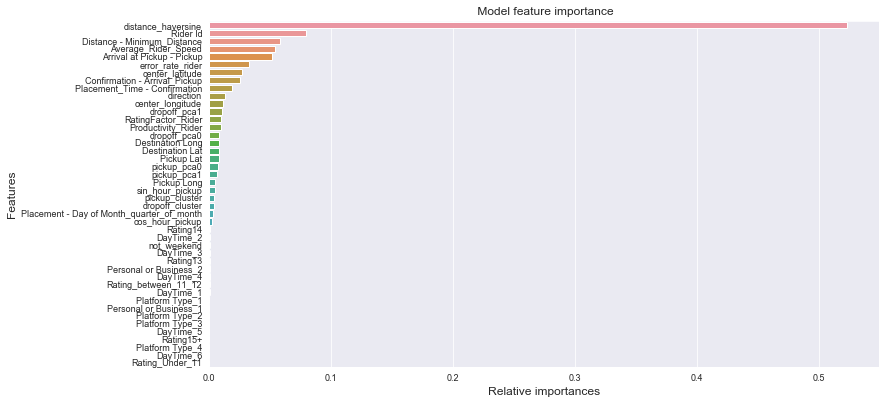

In [141]:
# fitting the LGBMRegressor model
oof_train_3, oof_test_3 = model_fitting(model_gbr, 'LGBMRegressor', X, y)

# plotting the relative importance of Features
relative_importance(X, model_gbr)

Iteration : 1 - Train GradientBoostingRegressor Score : 0.7152807702965456 - CV GradientBoostingRegressor Score : 0.4788593414387571
Iteration : 2 - Train GradientBoostingRegressor Score : 0.7109768072204885 - CV GradientBoostingRegressor Score : 0.4862327286520737
Iteration : 3 - Train GradientBoostingRegressor Score : 0.7155778348271467 - CV GradientBoostingRegressor Score : 0.5079087178201536
Iteration : 4 - Train GradientBoostingRegressor Score : 0.7176303048802524 - CV GradientBoostingRegressor Score : 0.5148540679635366
Iteration : 5 - Train GradientBoostingRegressor Score : 0.7179251673751084 - CV GradientBoostingRegressor Score : 0.4696124593048039
Iteration : 6 - Train GradientBoostingRegressor Score : 0.7162804262977626 - CV GradientBoostingRegressor Score : 0.5029530568954885
Iteration : 7 - Train GradientBoostingRegressor Score : 0.7157834981184934 - CV GradientBoostingRegressor Score : 0.4548809095286003
Iteration : 8 - Train GradientBoostingRegressor Score : 0.71132342103

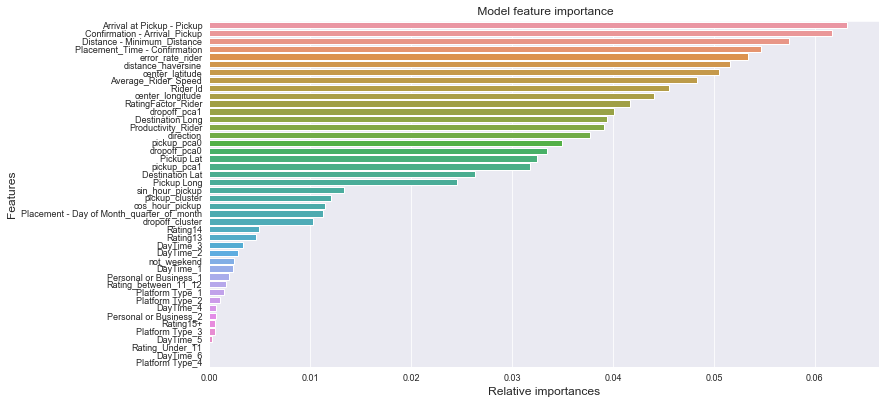

In [142]:
# fitting the GradientBoostingRegressor model
oof_train_4, oof_test_4 = model_fitting(model_lgbm, 'GradientBoostingRegressor', X, y)

# plotting the relative importance of Features
relative_importance(X, model_lgbm)

### Final Tweaking

In [145]:
from ipywidgets import interact

final_df = pd.DataFrame(columns=['Order No','Time from Pickup to Arrival']) #Initializing the dataframe

def weight_tuning(a, b, c, d):
    final_df['Time from Pickup to Arrival'] =  oof_train_1 * a + oof_train_2 * b + oof_train_3 * c + oof_train_4 * d
    
    return np.sqrt(mean_squared_error(y, final_df['Time from Pickup to Arrival']))

# create a slider
interact(weight_tuning, a = (0.0, 1.0), b = (0.0, 1.0), c = (0.0, 1.0), d = (0.0, 1.0))

interactive(children=(FloatSlider(value=0.5, description='a', max=1.0), FloatSlider(value=0.5, description='b'…

<function __main__.weight_tuning(a, b, c, d)>

In [ ]:
final_df.loc[final_df['Time from Pickup to Arrival']<=1,'Time from Pickup to Arrival'] = 2

In [ ]:
print(np.sqrt(mean_squared_error(y, final_df['Time from Pickup to Arrival'])))

### Submission

In [ ]:
submission_df = pd.DataFrame(index=test.index,columns=['Order No','Time from Pickup to Arrival'])
submission_df['Order No'] = test['Order No']

#Note: we start by assigning random weights to 4 out of fold predictions , and we probe the Leaderboard until we get the weights that perform best.
# The diving by 10 comes as a result of number of iterations (There's 10 iteration per model)
submission_df['Time from Pickup to Arrival'] = (oof_test_1 / 10) * 0.00 + (oof_test_2 / 10) * 0.6 + (oof_test_3/10) * 0.4 + (oof_test_4 / 10) * 0.00

In [ ]:
submission_df.loc[submission_df['Time from Pickup to Arrival']<=1,'Time from Pickup to Arrival']=1

In [ ]:
submission_df.to_csv('Submission_new_1.csv',index=False)

In [ ]:
Submission_df = pd.read_csv('Submission_new_1.csv')
Submission_df.head()

### Saving the Model

In [ ]:

model_save_path = "SLC_version6_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)